# 2. Histogram of oriented gradients


In [8]:
import os
import cv2
import numpy as np
import pandas as pd

def compute_HOG(image, resize_dim=(64, 128), cell_size=(8, 8)):
    # Resize the image
    resized_image = cv2.resize(image, resize_dim)
    
    # Convert the image to grayscale
    gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    
    # Initialize HOG descriptor
    hog = cv2.HOGDescriptor()
    
    # Compute HOG features
    features = hog.compute(gray)
    
    # Reshape features to match the HOG descriptor
    features = features.reshape((-1, hog.getDescriptorSize()))
    
    # Perform mean pooling to reduce dimensions
    pooled_features = []
    for i in range(0, features.shape[1], cell_size[0]):
        for j in range(0, features.shape[0], cell_size[1]):
            cell_features = features[j:j+cell_size[1], i:i+cell_size[0]]
            pooled_features.append(np.mean(cell_features))
    
    return np.array(pooled_features)

# Function to save HOG features along with car name and image name to a CSV file
def save_to_csv(data, filename):
    np.savetxt(filename, data, delimiter=',', fmt='%s')

# Path to the folder containing images
folder_path = "images/"
# Load the CSV containing car name and image name mapping
csv_data = np.genfromtxt('Datasets/raw/CarsWithStocksPrices.csv', delimiter=',', dtype=str, skip_header=1)

# Initialize list to store extracted features
feature_data = []

# Iterate over each entry in the mapping CSV
for entry in csv_data:
    # Extract car name and image name
    car_name = entry[0]
    image_name = entry[4]
    price = entry[3]
    stock=entry[2]
    # Construct full path to the image
    image_path = os.path.join(folder_path, image_name +  '.jpg')
    print("Image path:", image_path)  # Print the image path for debugging
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Unable to load image", image_path)
        continue
    # Compute HOG features
    hog_features = compute_HOG(image)
    # Append car name, image name, and features to the list
    feature_data.append(np.hstack((car_name, image_name,price,stock, hog_features)))


# Save the feature data to CSV
save_to_csv(feature_data, 'Datasets/HOG_car_features.csv')

# Adding coulmns names
df = pd.read_csv('Datasets/HOG_car_features.csv')
df = df.iloc[:, 1:]

# Rename the columns
df.columns = ["CarName","Price","Stock"] + [f"Feature_{i}" for i in range(1, len(df.columns) - 2)]

# Save the DataFrame back to the same CSV file
df.to_csv('Datasets/HOG_car_features.csv', index=False)

print("Features saved to car_features.csv")


Image path: images/BMW 1 Series 2019.jpg
Image path: images/BMW 2 Series Active Tourer 2022.jpg
Image path: images/BMW 2 Series Gran Coupe 2020.jpg
Image path: images/BMW 3 Series 2014.jpg
Image path: images/BMW 4 Series 2015.jpg
Image path: images/BMW 4 Series Convertible 2021.jpg
Image path: images/BMW 5 Series 2017.jpg
Image path: images/BMW 6 Series 2017.jpg
Image path: images/BMW 7 Series 2015.jpg
Image path: images/BMW 7 Series 2023.jpg
Image path: images/BMW 8 Series 2018.jpg
Image path: images/BMW i3 2016.jpg
Image path: images/BMW i4 2022.jpg
Image path: images/BMW i7 2023.jpg
Image path: images/BMW i8 2014.jpg
Image path: images/BMW iX 2021.jpg
Image path: images/BMW iX3 2020.jpg
Image path: images/BMW M2 2016.jpg
Image path: images/BMW M8 2019.jpg
Image path: images/BMW X1 2016.jpg
Image path: images/BMW X2 2018.jpg
Image path: images/BMW X3 2017.jpg
Image path: images/BMW X3 M 2022.jpg
Image path: images/BMW X4 2021.jpg
Image path: images/BMW X5 2014.jpg
Image path: images/

# Predict Stock price using HOG Features


First apply PCA to reduce dimension

In [9]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

# Load the dataset
input_csv = 'Datasets/HOG_car_features.csv'
output_csv = 'Datasets/HOG_car_featuresPCA.csv'

print("Loading dataset...")
df = pd.read_csv(input_csv)
print(f"Dataset loaded with shape: {df.shape}")

# Separating out the features for PCA (starting from the 5th column to the end)
X = df.iloc[:, 3:].values

# Perform PCA
n_components = 199  # Adjust the number of components based on your needs
print(f"Performing PCA to reduce dimensions to {n_components}...")
pca = PCA(n_components=n_components)
principalComponents = pca.fit_transform(X)

# Creating a DataFrame with the first 5 columns and the principal components
print("Creating DataFrame with the first 5 columns and principal components...")
principalDf = pd.DataFrame(data=principalComponents, columns=[f'PC{i+1}' for i in range(n_components)])

# Combine the first 5 columns with the principal components
result_df = pd.concat([df.iloc[:, :3], principalDf], axis=1)

# Saving the new dataset to a CSV file
print(f"Saving the new dataset to {output_csv}...")
result_df.to_csv(output_csv, index=False)
print("Process completed successfully.")


Loading dataset...
Dataset loaded with shape: (396, 476)
Performing PCA to reduce dimensions to 199...
Creating DataFrame with the first 5 columns and principal components...
Saving the new dataset to Datasets/HOG_car_featuresPCA.csv...
Process completed successfully.


In [10]:
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load the CSV file into a DataFrame
df = pd.read_csv('Datasets/HOG_car_featuresPCA.csv')

# Identify the numerical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Standardize all numerical columns
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Specify the directory to save the file
output_directory = 'Datasets/HOG'
os.makedirs(output_directory, exist_ok=True)  # Create the directory if it doesn't exist

# Save the standardized DataFrame to a new CSV file
output_file = os.path.join(output_directory, 'HOG_car_featuresPCAstand.csv')
df.to_csv(output_file, index=False)

print("Standardization complete. The standardized data has been saved to 'Standardized_Dataset.csv' in the '{}' directory.".format(output_directory))


Standardization complete. The standardized data has been saved to 'Standardized_Dataset.csv' in the 'Datasets/HOG' directory.


Predict Stock price using Machine learning model

In [9]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Function to perform Linear Regression with Cross-Validation
def perform_linear_regression_cv(df):
    X = df.drop(columns=['Price'])  # Features
    y = df['Price']  # Target variable

    # Linear Regression with Cross-Validation
    linear_reg = LinearRegression()
    mse_scores = -cross_val_score(linear_reg, X, y, cv=5, scoring='neg_mean_squared_error')
    return mse_scores.mean()

# Function to perform XGBoost Regression with Cross-Validation
def perform_xgboost_regression_cv(df):
    X = df.drop(columns=['Price'])  # Features
    y = df['Price']  # Target variable

    # Best parameters for XGBoost Regression
    best_params = {
        'learning_rate': 0.1,
        'max_depth': 3,
        'n_estimators': 100,
        'subsample': 0.8
    }

    # XGBoost Regression with Cross-Validation
    xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', **best_params)
    mse_scores = -cross_val_score(xgb_reg, X, y, cv=5, scoring='neg_mean_squared_error')
    return mse_scores.mean()

# Function to perform Random Forest Regression with Cross-Validation
def perform_random_forest_regression_cv(df):
    X = df.drop(columns=['Price'])  # Features
    y = df['Price']  # Target variable

    # Random Forest Regression with Cross-Validation
    rf_reg = RandomForestRegressor(random_state=42)
    mse_scores = -cross_val_score(rf_reg, X, y, cv=5, scoring='neg_mean_squared_error')
    return mse_scores.mean()

# Function to perform Neural Network Regression with Cross-Validation
def perform_neural_network_regression_cv(df):
    X = df.drop(columns=['Price'])  # Features
    y = df['Price']  # Target variable
    
    # Define the neural network architecture
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[X.shape[1]]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Define K-fold cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    mse_scores = []
    
    # Perform K-fold cross-validation
    for train_idx, val_idx in kfold.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Train the model
        model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
        
        # Evaluate the model on the validation set
        val_loss = model.evaluate(X_val, y_val, verbose=0)
        mse_scores.append(val_loss)
    
    return np.mean(mse_scores)

# Folder containing individual CSV files
folder_path = "Datasets/HOG/ml"

# Function to perform data preprocessing and feature engineering
from category_encoders import TargetEncoder

# Function to preprocess data with enhanced feature engineering and encoding
def preprocess_data(df):

       
    # Drop original 'Date' and 'Quarter_Date' columns
    df.drop(columns=['CarName'], inplace=True)

    # Use target encoding for the 'Stock' column
    encoder = TargetEncoder()
    df['Stock_Encoded'] = encoder.fit_transform(df['Stock'], df['Price'])

    # Drop the original 'Stock' column
    df.drop(columns=['Stock'], inplace=True)
    
    return df

# Iterate over CSV files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        print("Processing file:", filename)

        df = pd.read_csv(file_path)
        
        # Preprocess data
        df = preprocess_data(df)
        
        # Assuming 'Price' is the target column
        if 'Price' in df.columns:
            # Perform Linear Regression with Cross-Validation
            linear_reg_cv_mse = perform_linear_regression_cv(df)
            print("Cross-Validation MSE (Linear Regression):", linear_reg_cv_mse)
            
            # Perform XGBoost Regression with Cross-Validation
            xgb_reg_cv_mse = perform_xgboost_regression_cv(df)
            print("Cross-Validation MSE (XGBoost Regression):", xgb_reg_cv_mse)
            
            # Perform Random Forest Regression with Cross-Validation
            rf_reg_cv_mse = perform_random_forest_regression_cv(df)
            print("Cross-Validation MSE (Random Forest Regression):", rf_reg_cv_mse)
            
            # Perform Neural Network Regression with Cross-Validation
            nn_reg_cv_mse = perform_neural_network_regression_cv(df)
            print("Cross-Validation MSE (Neural Network Regression):", nn_reg_cv_mse)
        else:
            print("Error: 'Price' column not found in", filename)


Processing file: HOG_car_featuresPCAstand.csv
Cross-Validation MSE (Linear Regression): 0.8033439129512961
Cross-Validation MSE (XGBoost Regression): 0.4587360977621904
Cross-Validation MSE (Random Forest Regression): 0.3484463336487714


D:\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Cross-Validation MSE (Neural Network Regression): 0.2251421763561666


Summary Statistics:
              Price           PC1           PC2           PC3           PC4  \
count  3.960000e+02  3.960000e+02  3.960000e+02  3.960000e+02  3.960000e+02   
mean  -1.435440e-16  2.691450e-17  8.971499e-18  4.485750e-18  2.691450e-17   
std    1.001265e+00  1.001265e+00  1.001265e+00  1.001265e+00  1.001265e+00   
min   -7.858578e-01 -1.279586e+00 -2.682632e+00 -4.077952e+00 -3.686927e+00   
25%   -6.221408e-01 -6.768636e-01 -5.074561e-01 -5.183304e-01 -6.052888e-01   
50%   -4.774360e-01 -3.939345e-01 -1.270550e-01 -7.791967e-02 -3.023620e-02   
75%    3.260162e-01  3.094309e-01  6.030023e-01  3.774877e-01  5.558031e-01   
max    5.590755e+00  3.529804e+00  4.506553e+00  5.014941e+00  4.029222e+00   

                PC5           PC6           PC7           PC8           PC9  \
count  3.960000e+02  3.960000e+02  3.960000e+02  3.960000e+02  3.960000e+02   
mean  -3.588600e-17 -4.485750e-18  2.242875e-17 -1.570012e-17 -1.794300e-17   
std    1.001265e+00  1.001265e+

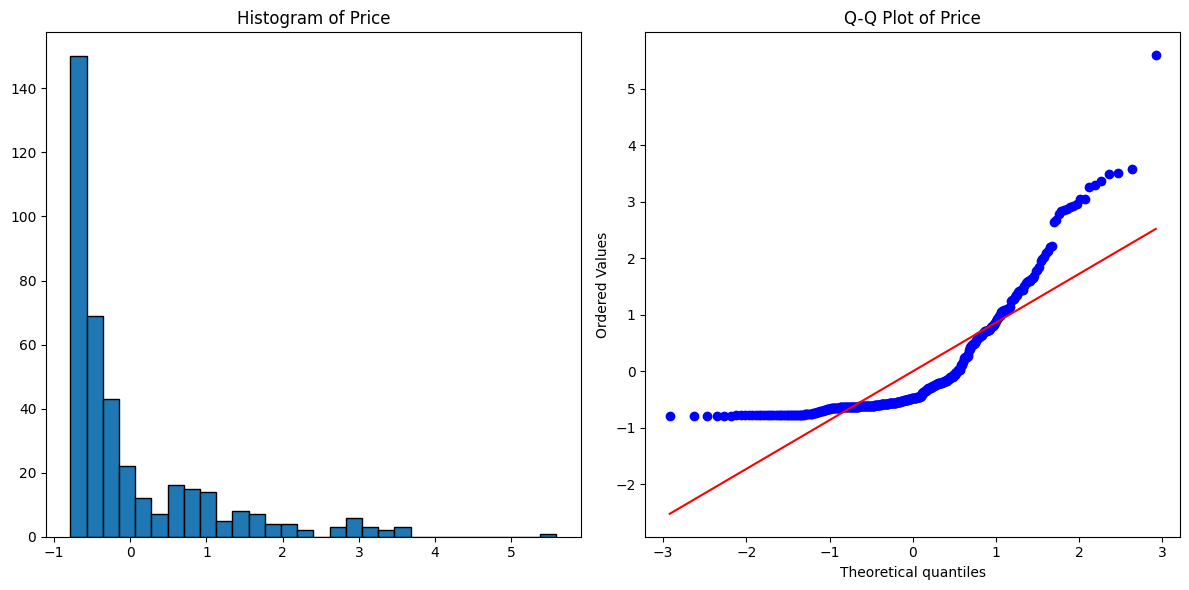

Shapiro-Wilk Test for Price:
Statistic: 0.7361, p-value: 0.0000
Price: Sample does not look Gaussian (reject H0)


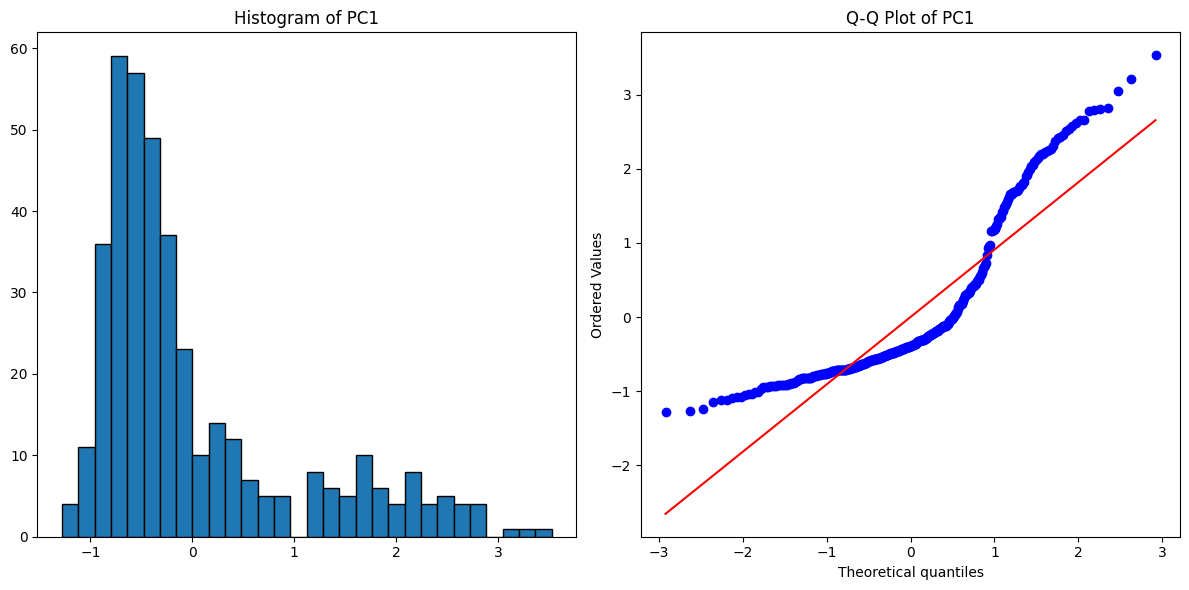

Shapiro-Wilk Test for PC1:
Statistic: 0.8147, p-value: 0.0000
PC1: Sample does not look Gaussian (reject H0)


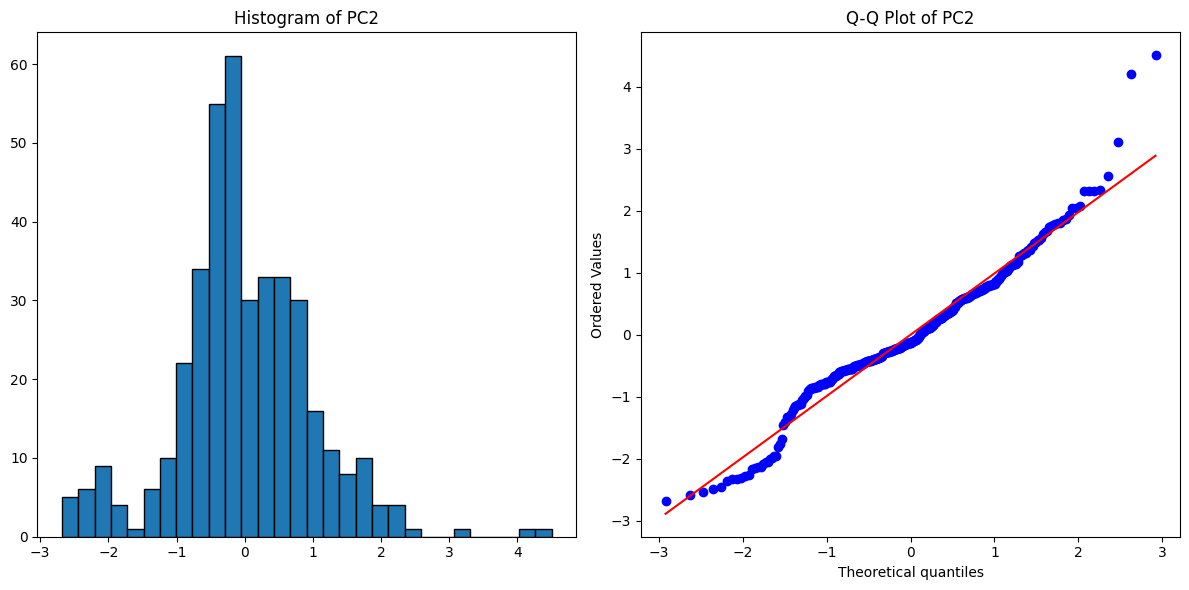

Shapiro-Wilk Test for PC2:
Statistic: 0.9670, p-value: 0.0000
PC2: Sample does not look Gaussian (reject H0)


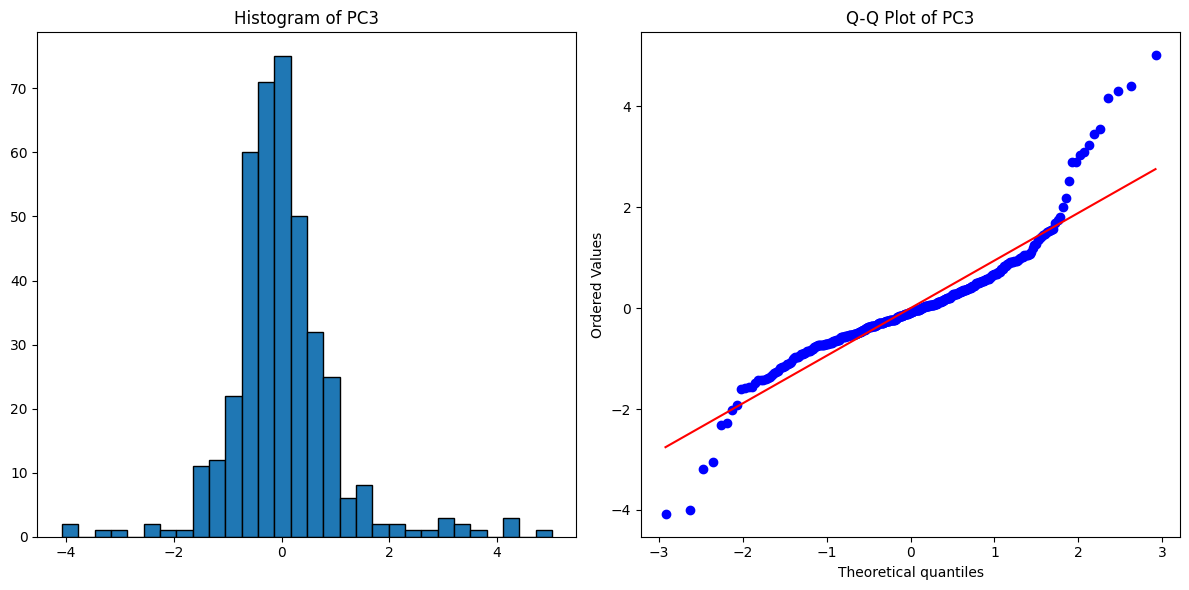

Shapiro-Wilk Test for PC3:
Statistic: 0.8853, p-value: 0.0000
PC3: Sample does not look Gaussian (reject H0)


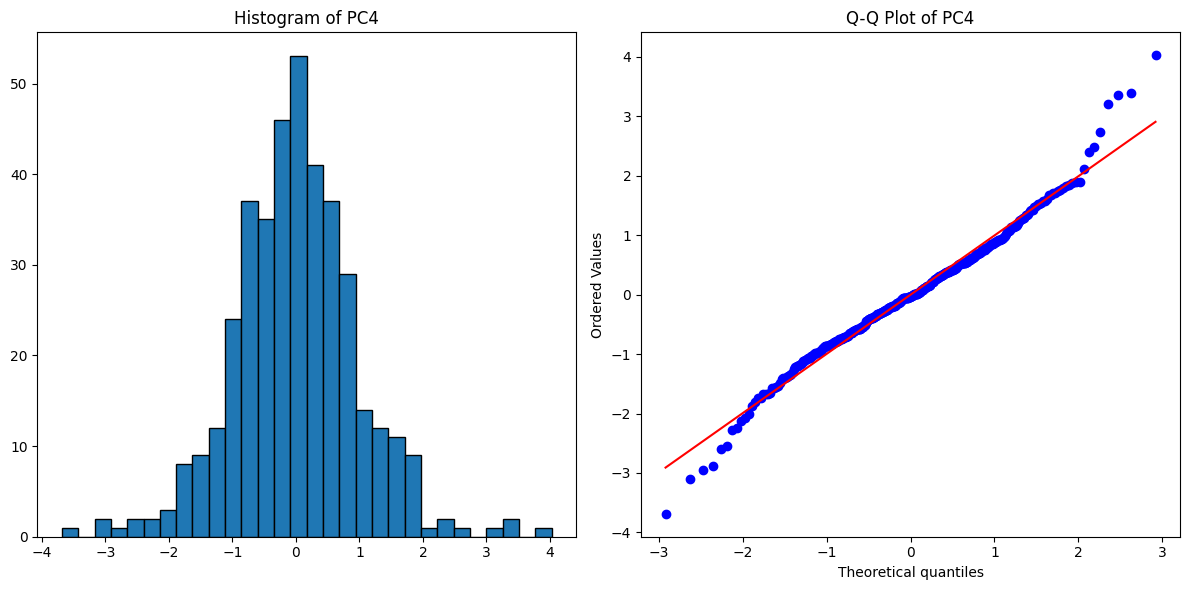

Shapiro-Wilk Test for PC4:
Statistic: 0.9826, p-value: 0.0001
PC4: Sample does not look Gaussian (reject H0)


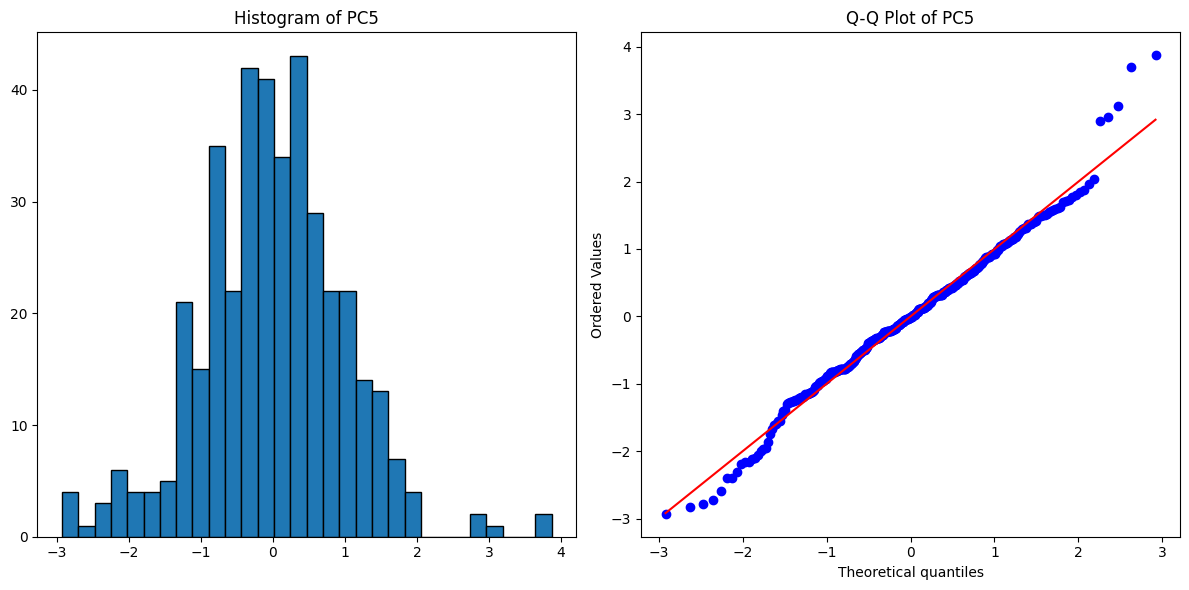

Shapiro-Wilk Test for PC5:
Statistic: 0.9863, p-value: 0.0009
PC5: Sample does not look Gaussian (reject H0)


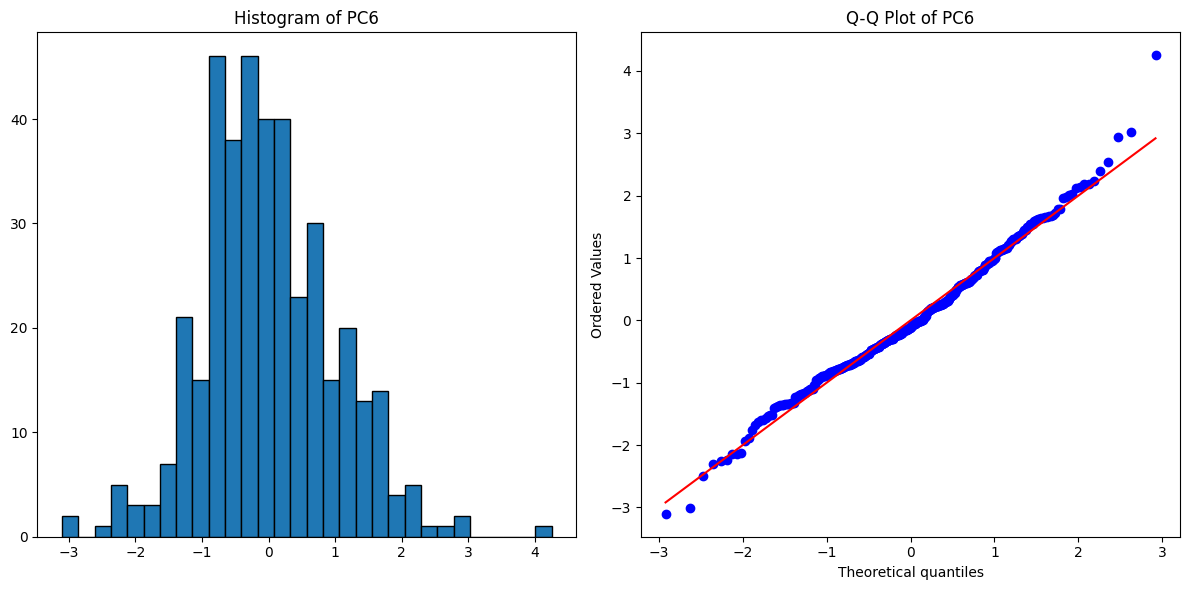

Shapiro-Wilk Test for PC6:
Statistic: 0.9886, p-value: 0.0034
PC6: Sample does not look Gaussian (reject H0)


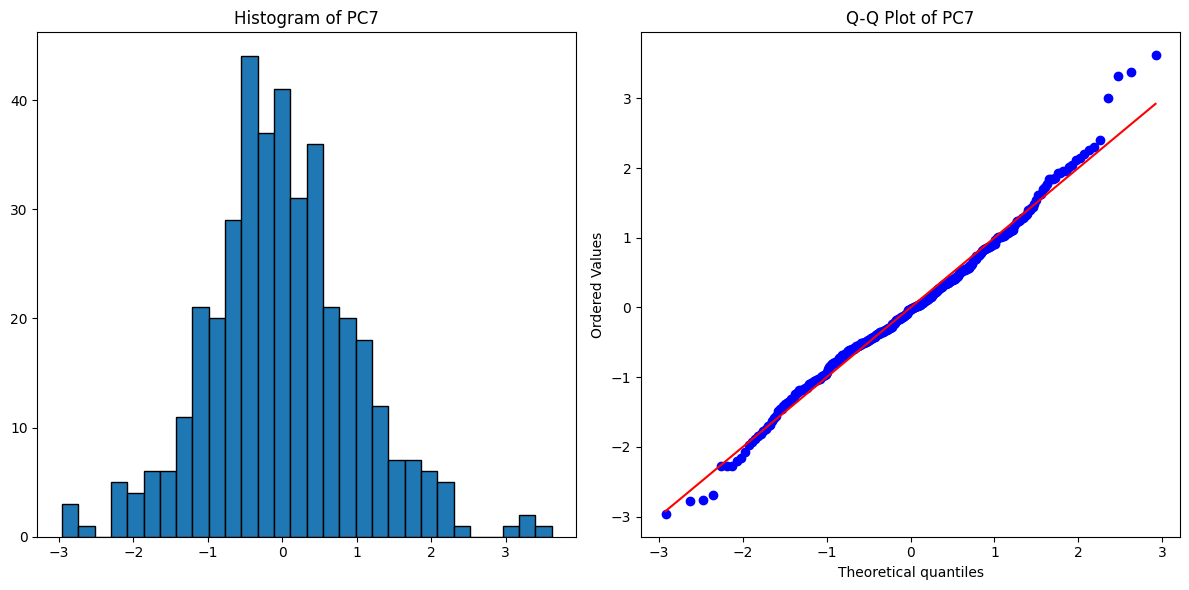

Shapiro-Wilk Test for PC7:
Statistic: 0.9887, p-value: 0.0036
PC7: Sample does not look Gaussian (reject H0)


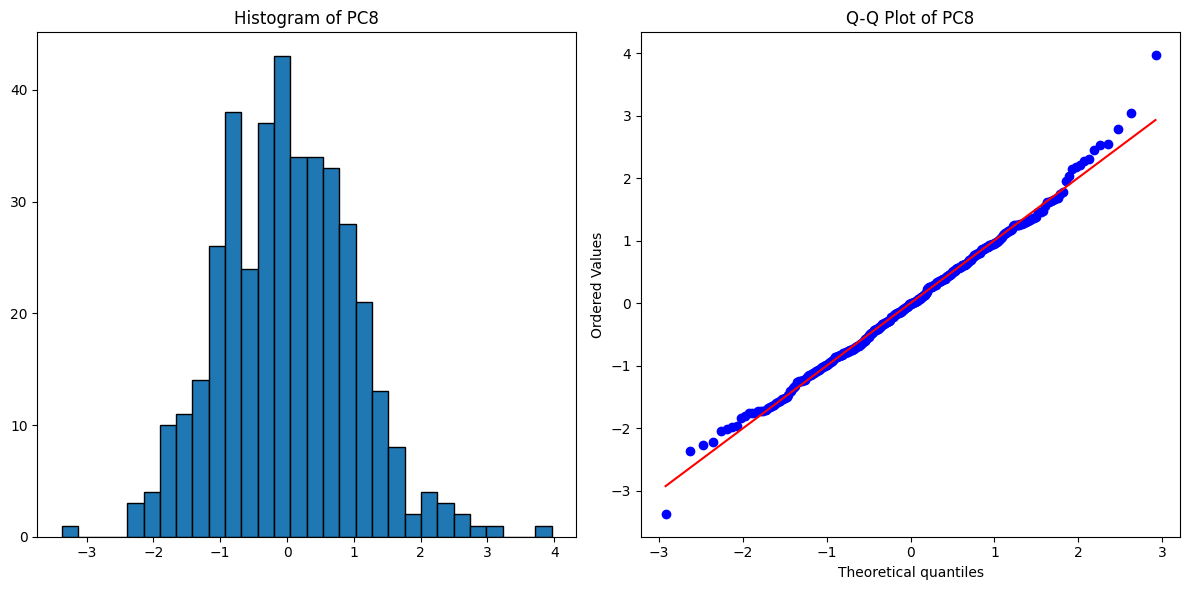

Shapiro-Wilk Test for PC8:
Statistic: 0.9947, p-value: 0.1879
PC8: Sample looks Gaussian (fail to reject H0)


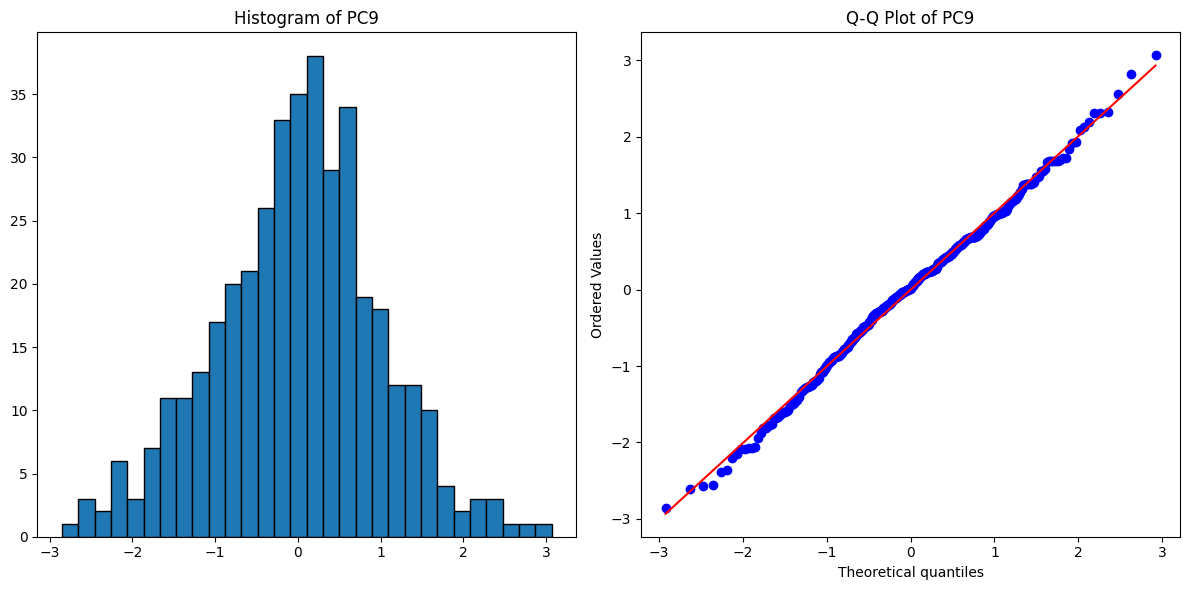

Shapiro-Wilk Test for PC9:
Statistic: 0.9963, p-value: 0.4795
PC9: Sample looks Gaussian (fail to reject H0)


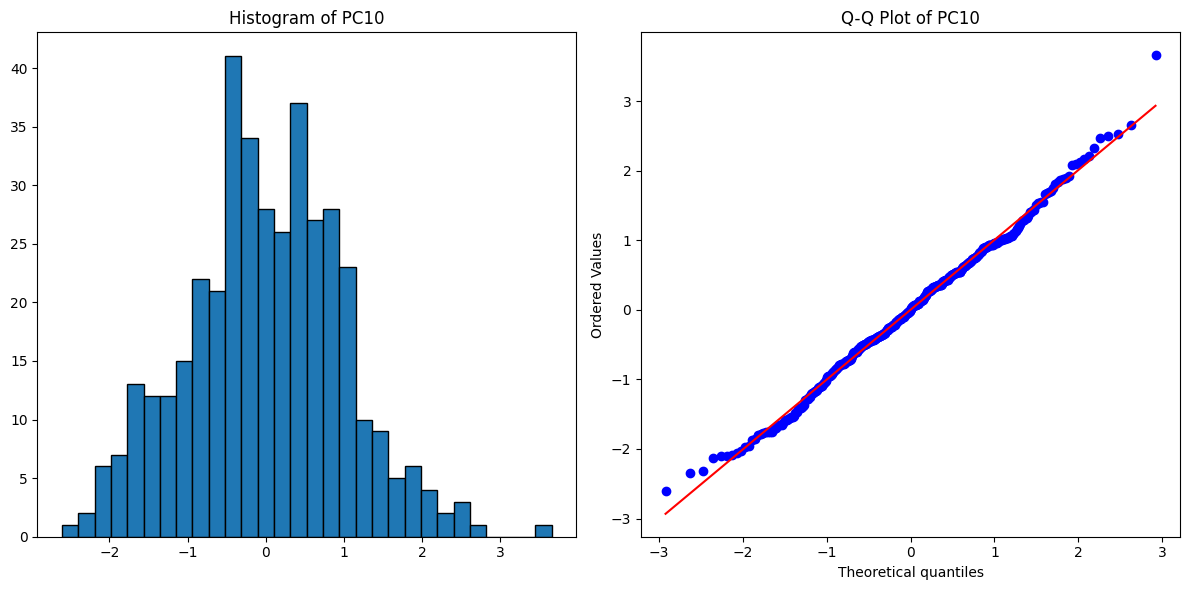

Shapiro-Wilk Test for PC10:
Statistic: 0.9956, p-value: 0.3275
PC10: Sample looks Gaussian (fail to reject H0)


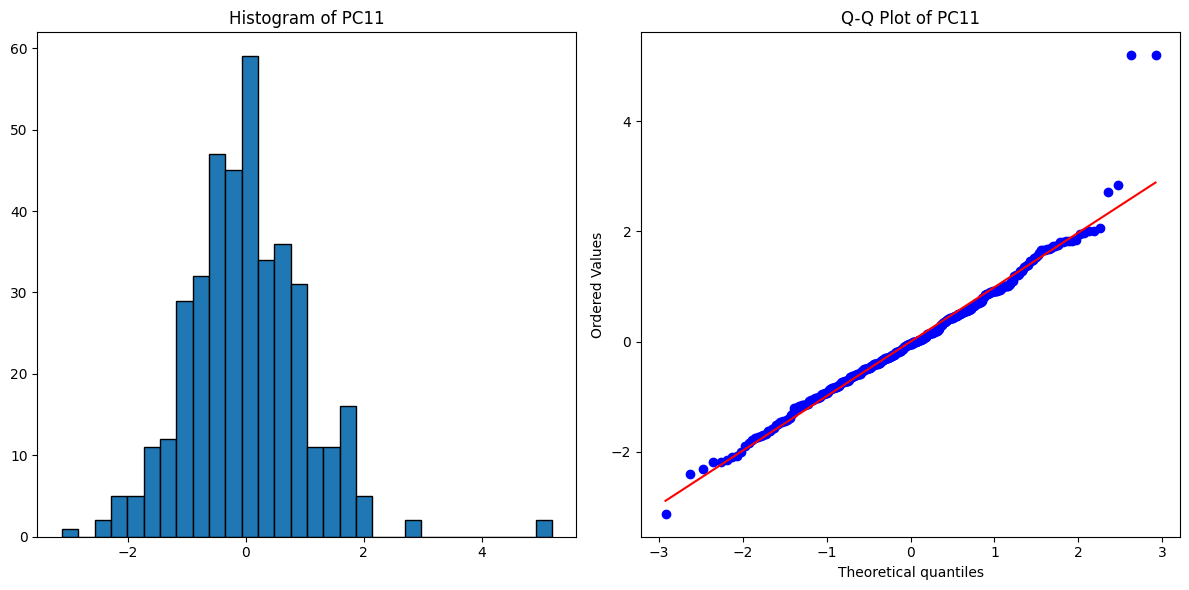

Shapiro-Wilk Test for PC11:
Statistic: 0.9673, p-value: 0.0000
PC11: Sample does not look Gaussian (reject H0)


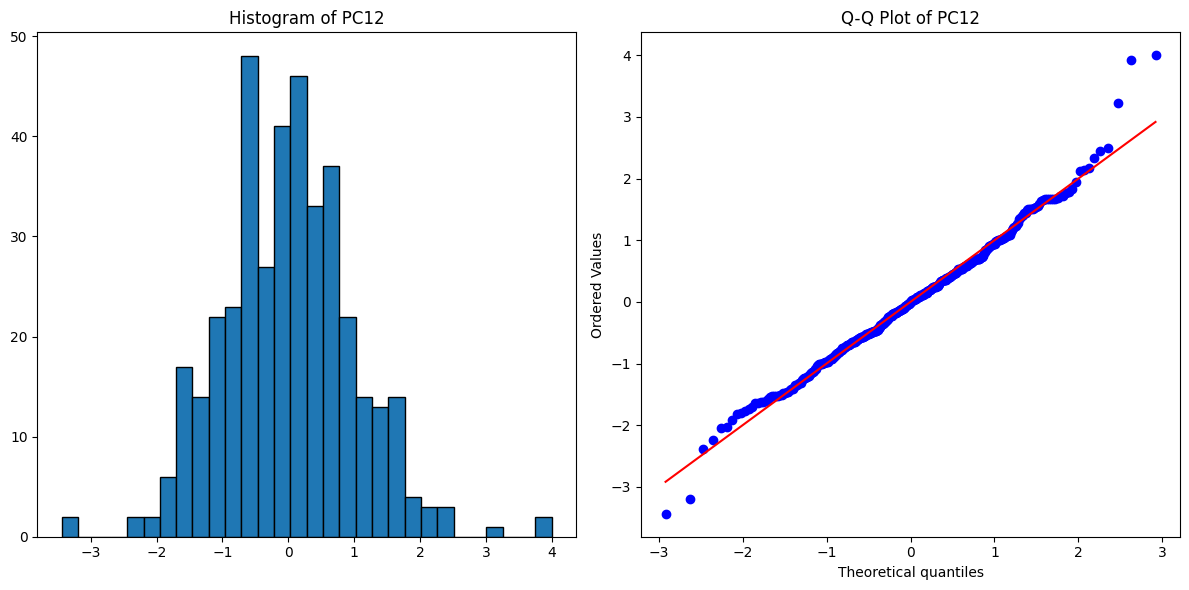

Shapiro-Wilk Test for PC12:
Statistic: 0.9883, p-value: 0.0029
PC12: Sample does not look Gaussian (reject H0)


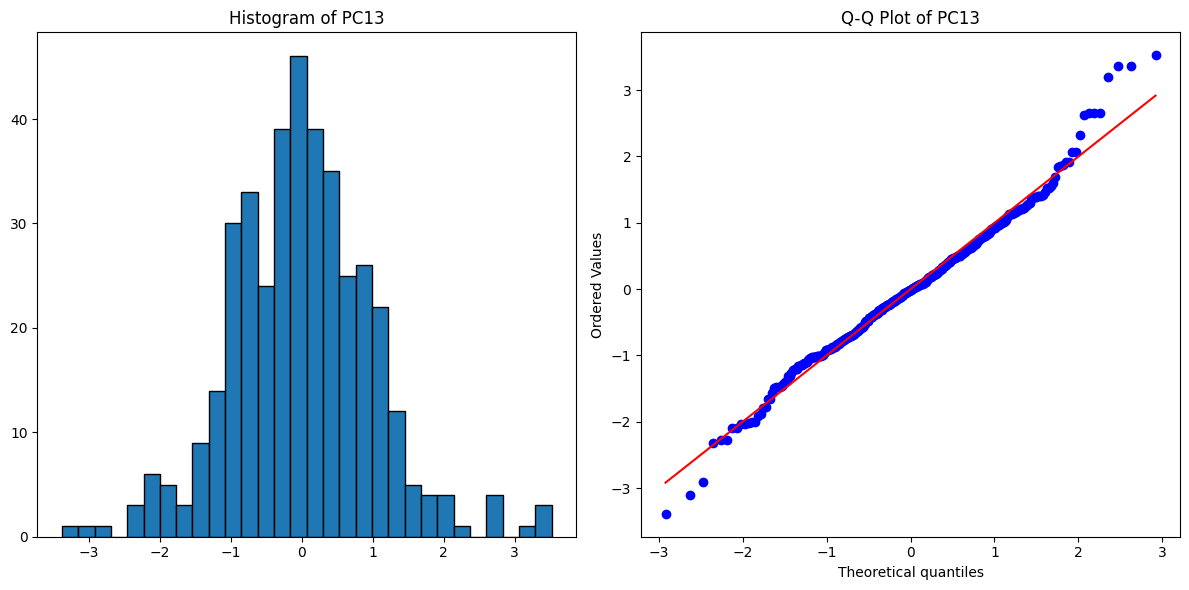

Shapiro-Wilk Test for PC13:
Statistic: 0.9861, p-value: 0.0007
PC13: Sample does not look Gaussian (reject H0)


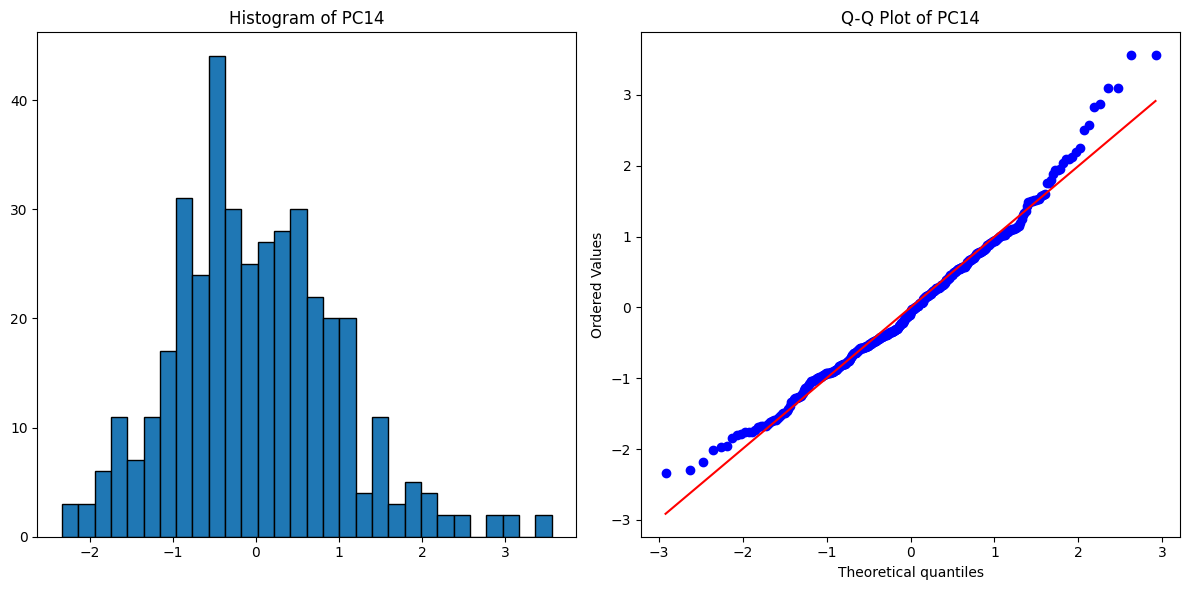

Shapiro-Wilk Test for PC14:
Statistic: 0.9831, p-value: 0.0001
PC14: Sample does not look Gaussian (reject H0)


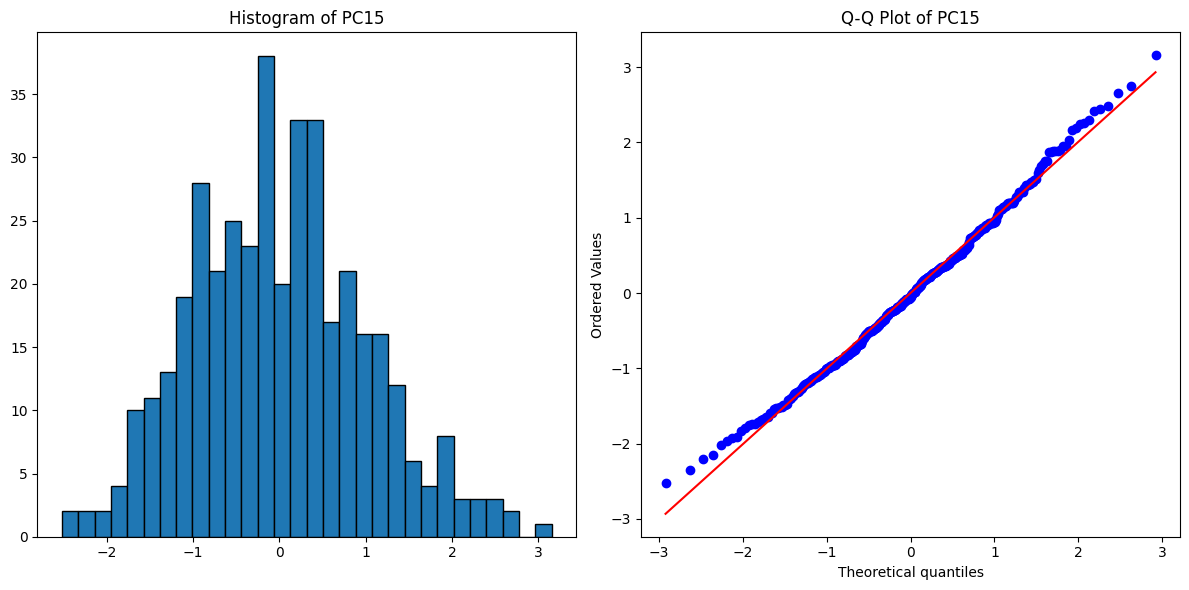

Shapiro-Wilk Test for PC15:
Statistic: 0.9943, p-value: 0.1465
PC15: Sample looks Gaussian (fail to reject H0)


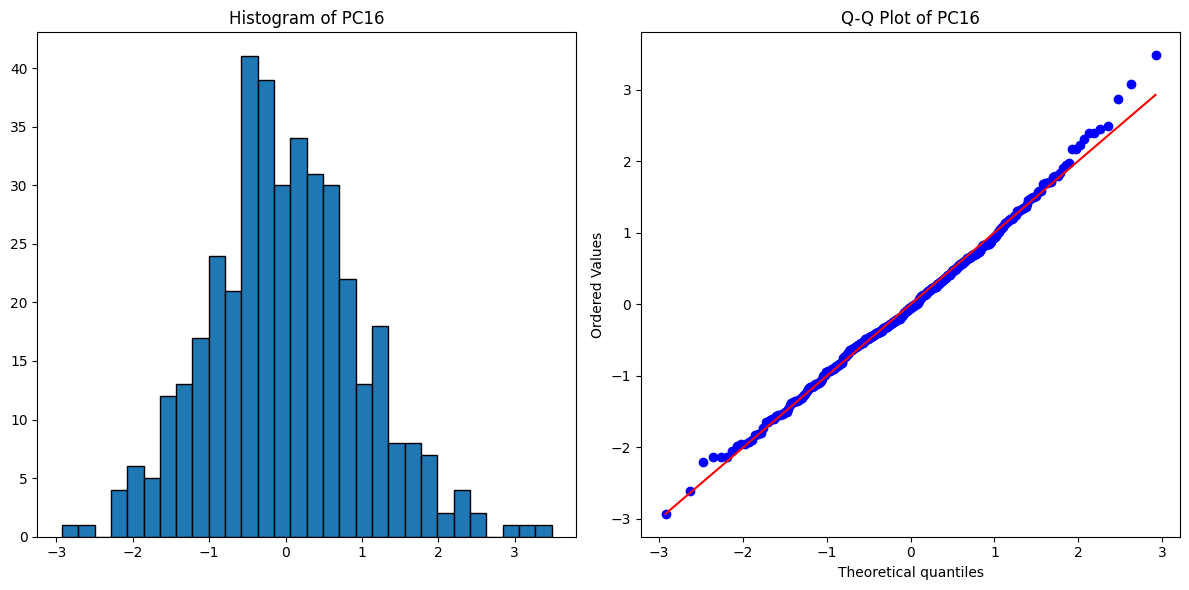

Shapiro-Wilk Test for PC16:
Statistic: 0.9956, p-value: 0.3350
PC16: Sample looks Gaussian (fail to reject H0)


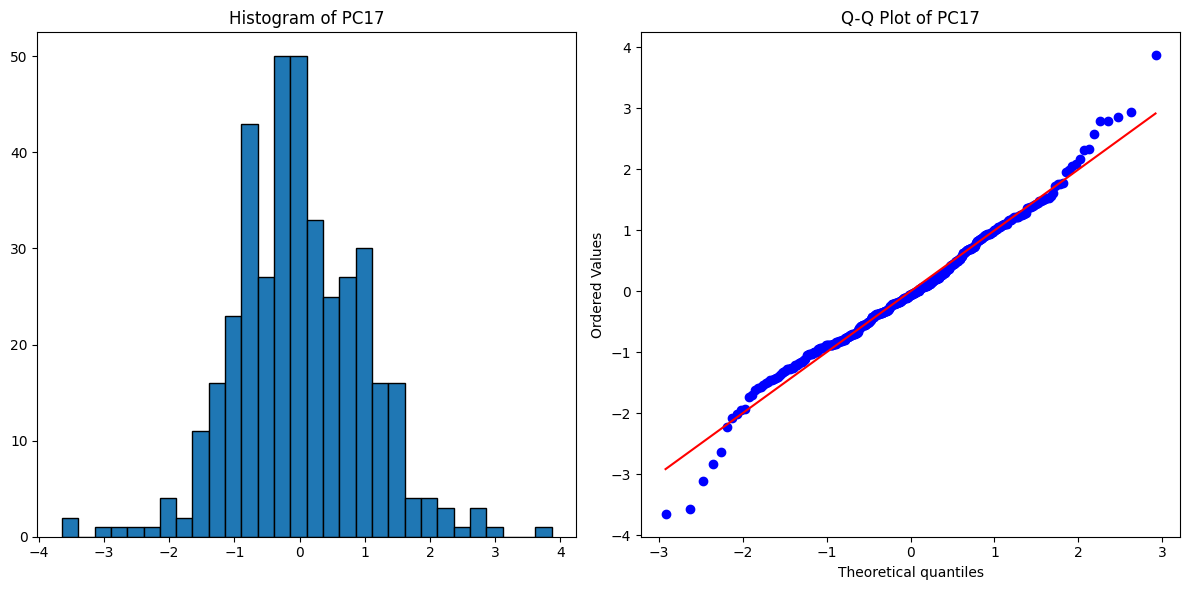

Shapiro-Wilk Test for PC17:
Statistic: 0.9855, p-value: 0.0006
PC17: Sample does not look Gaussian (reject H0)


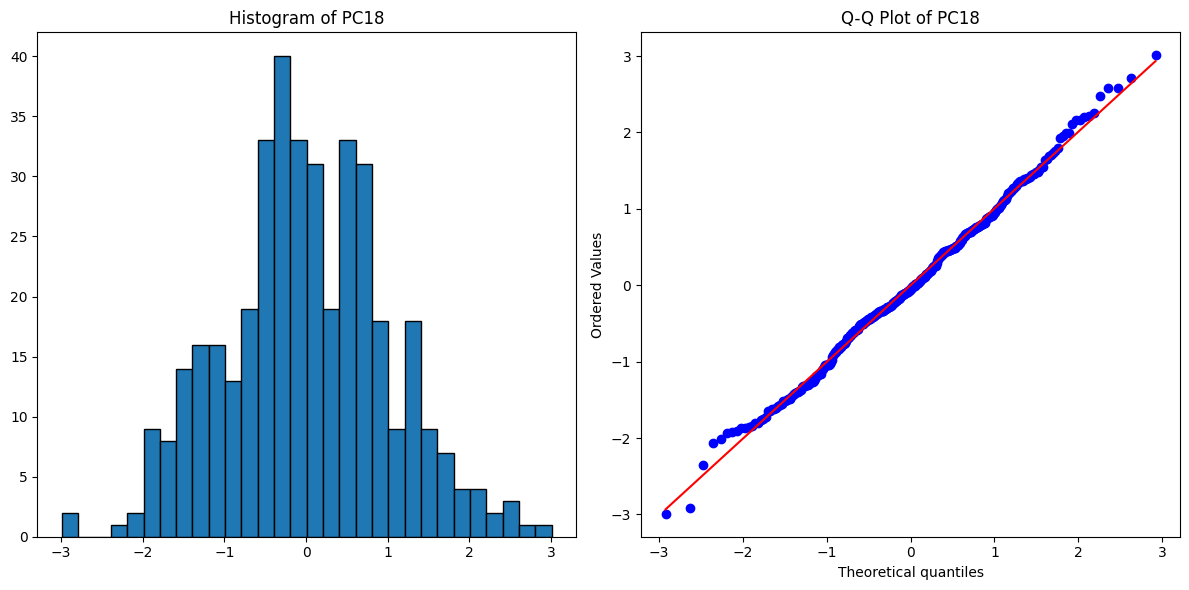

Shapiro-Wilk Test for PC18:
Statistic: 0.9964, p-value: 0.5193
PC18: Sample looks Gaussian (fail to reject H0)


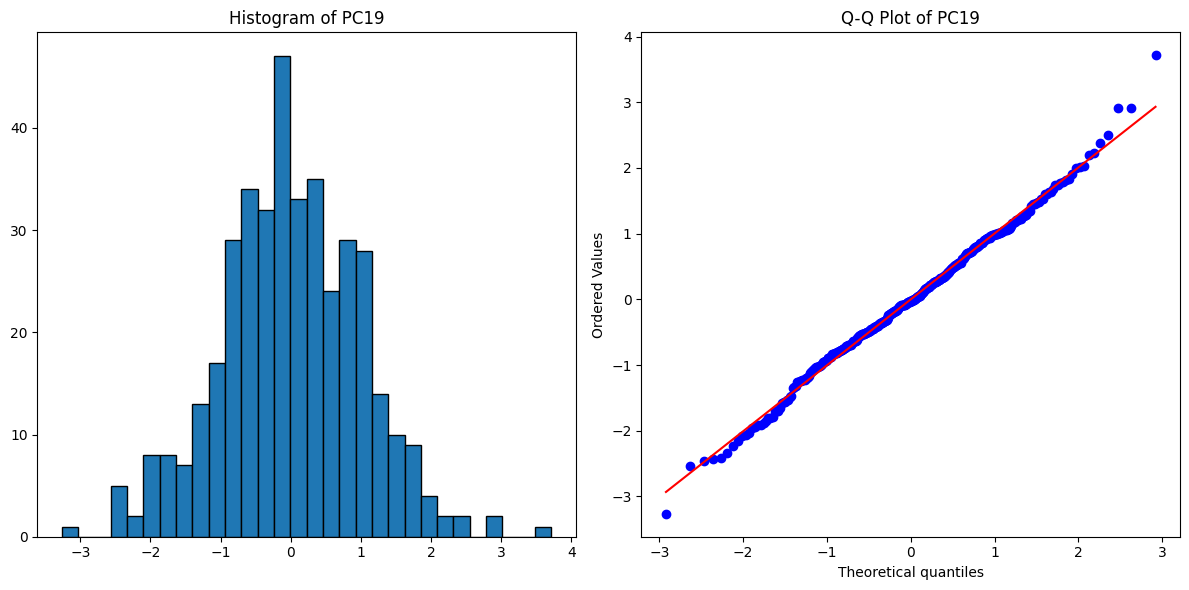

Shapiro-Wilk Test for PC19:
Statistic: 0.9961, p-value: 0.4431
PC19: Sample looks Gaussian (fail to reject H0)


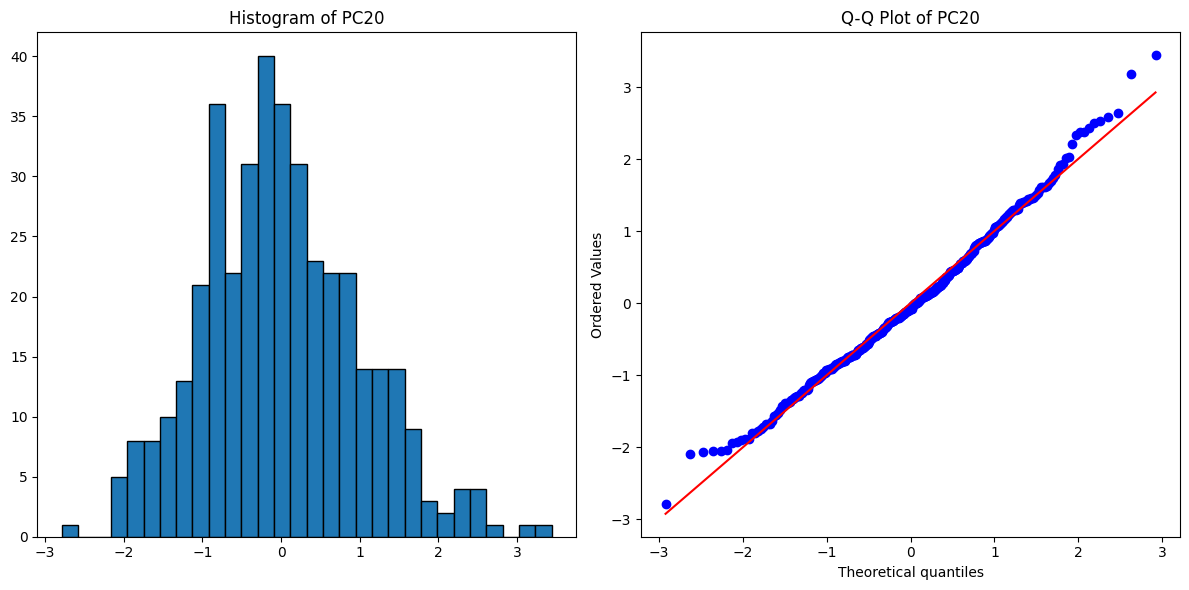

Shapiro-Wilk Test for PC20:
Statistic: 0.9919, p-value: 0.0288
PC20: Sample does not look Gaussian (reject H0)


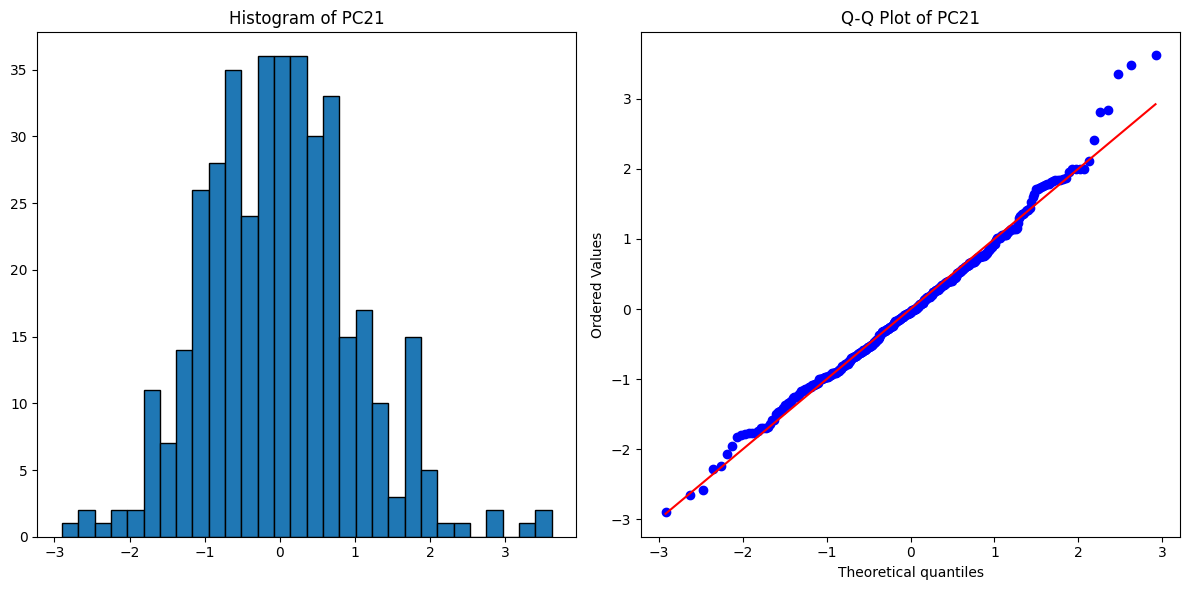

Shapiro-Wilk Test for PC21:
Statistic: 0.9899, p-value: 0.0082
PC21: Sample does not look Gaussian (reject H0)


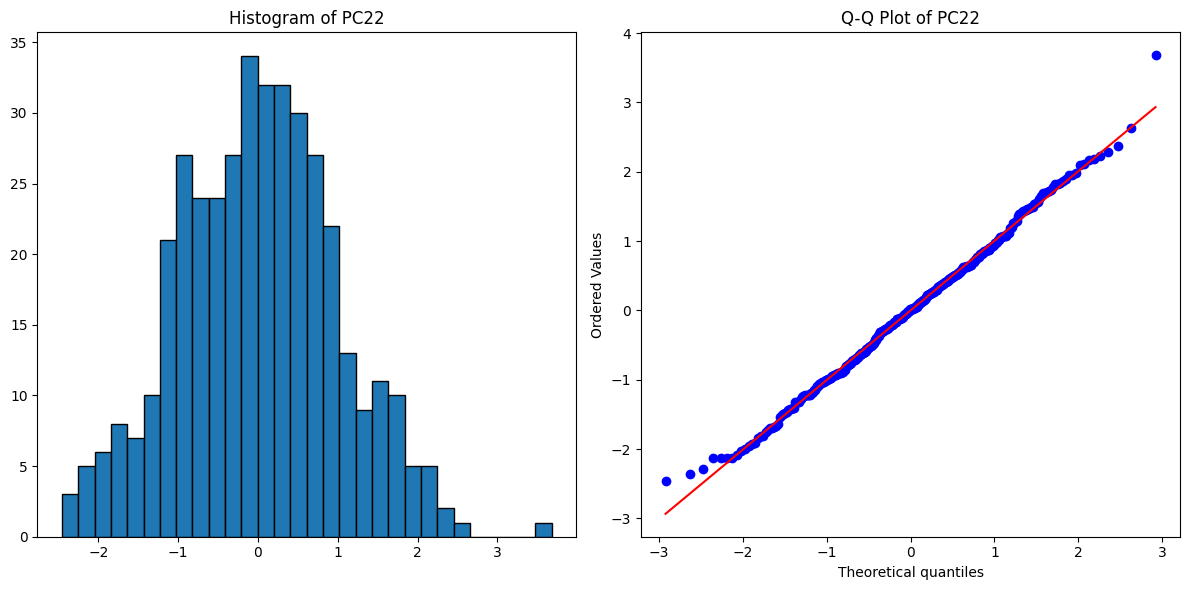

Shapiro-Wilk Test for PC22:
Statistic: 0.9962, p-value: 0.4773
PC22: Sample looks Gaussian (fail to reject H0)


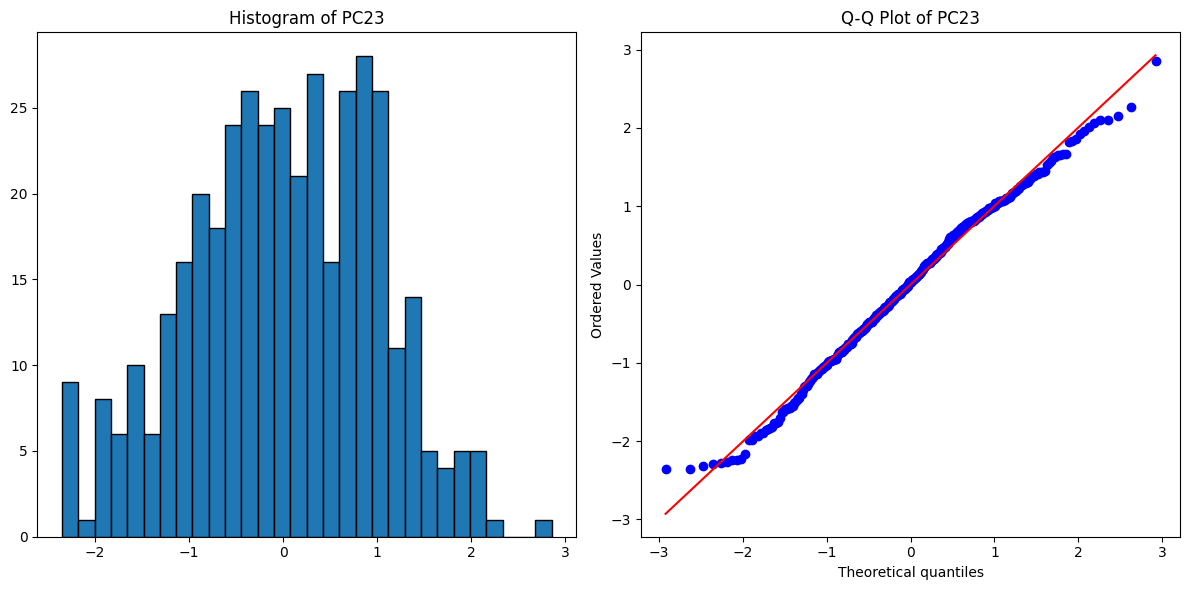

Shapiro-Wilk Test for PC23:
Statistic: 0.9922, p-value: 0.0361
PC23: Sample does not look Gaussian (reject H0)


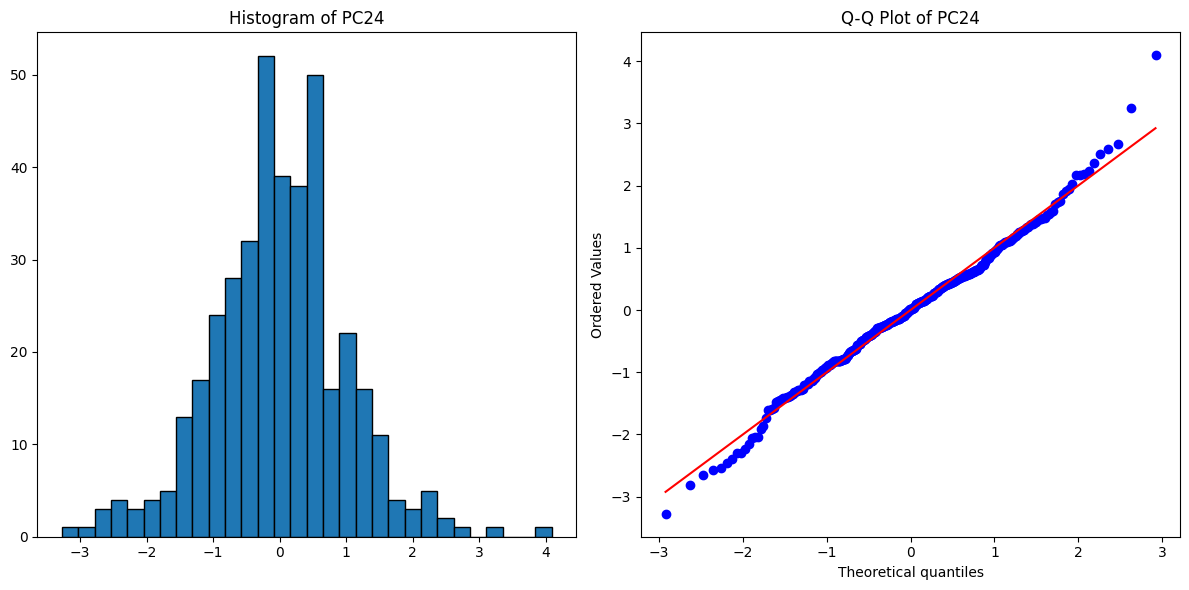

Shapiro-Wilk Test for PC24:
Statistic: 0.9906, p-value: 0.0127
PC24: Sample does not look Gaussian (reject H0)


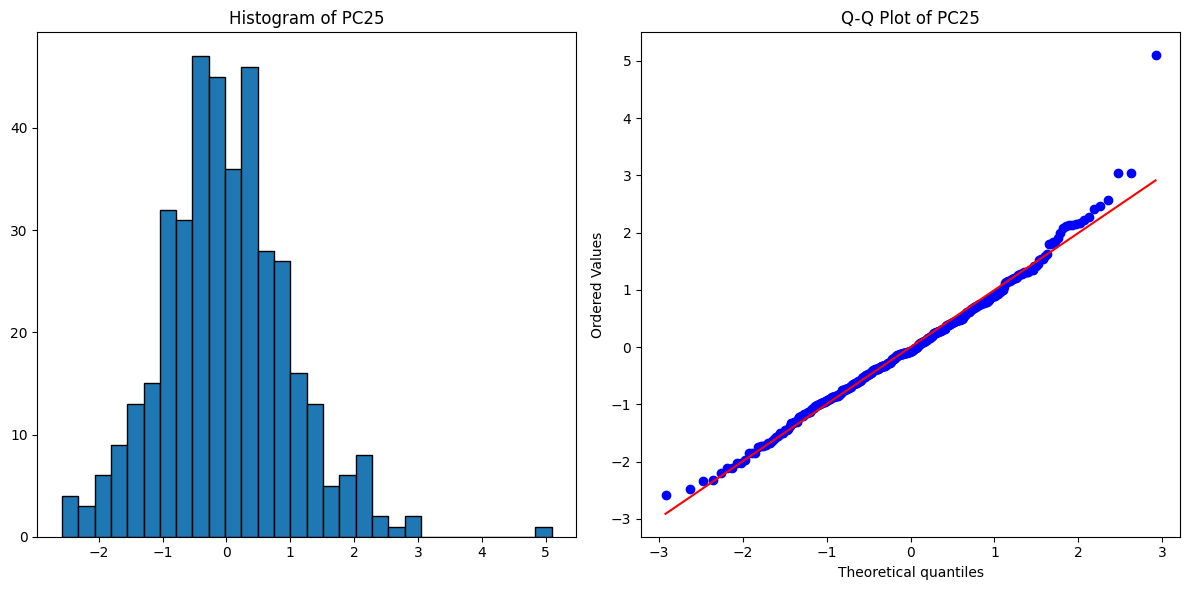

Shapiro-Wilk Test for PC25:
Statistic: 0.9835, p-value: 0.0002
PC25: Sample does not look Gaussian (reject H0)


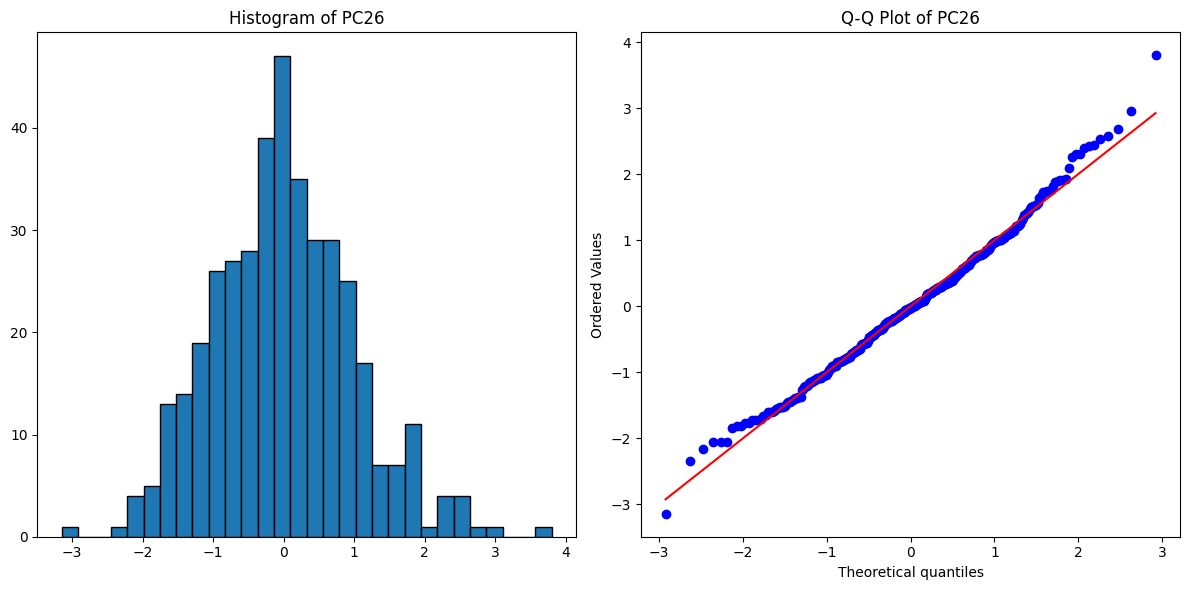

Shapiro-Wilk Test for PC26:
Statistic: 0.9929, p-value: 0.0582
PC26: Sample looks Gaussian (fail to reject H0)


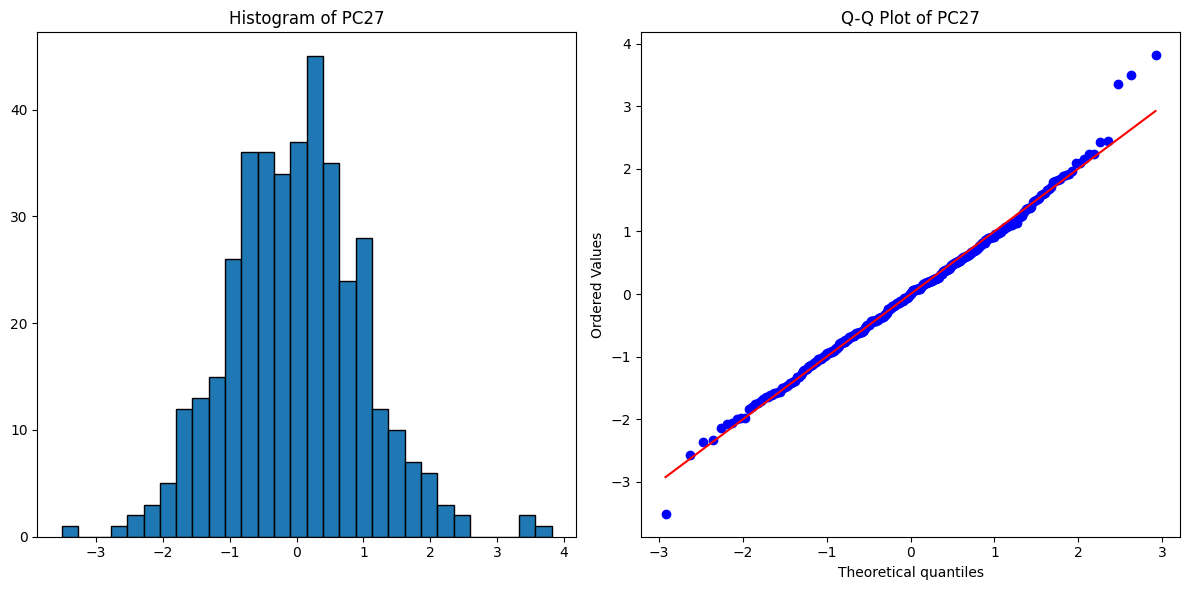

Shapiro-Wilk Test for PC27:
Statistic: 0.9929, p-value: 0.0593
PC27: Sample looks Gaussian (fail to reject H0)


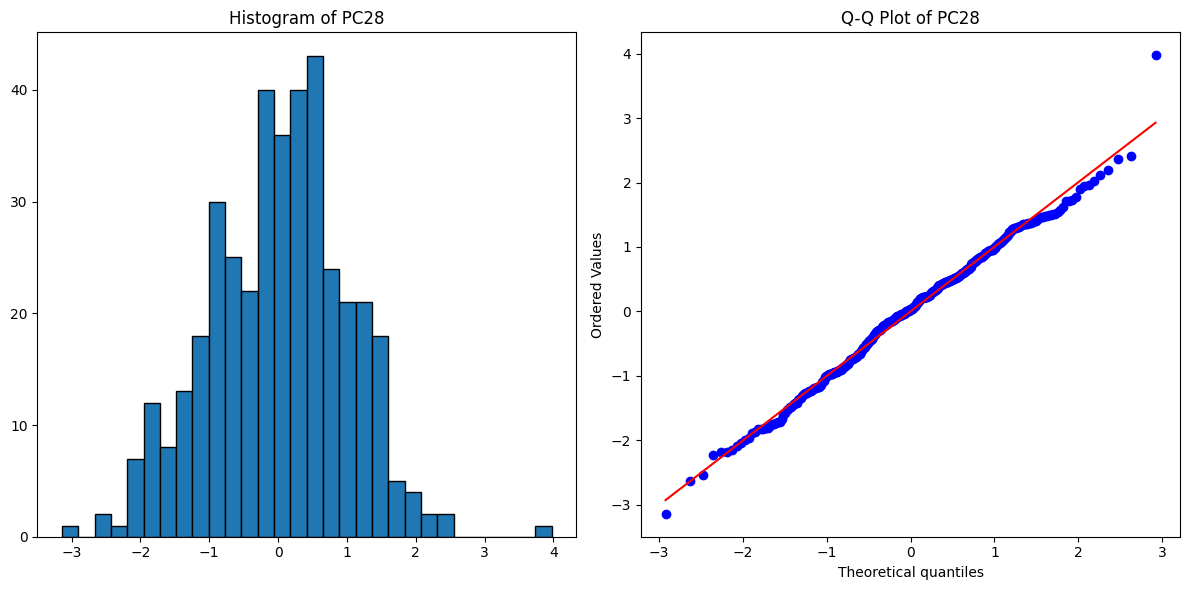

Shapiro-Wilk Test for PC28:
Statistic: 0.9941, p-value: 0.1328
PC28: Sample looks Gaussian (fail to reject H0)


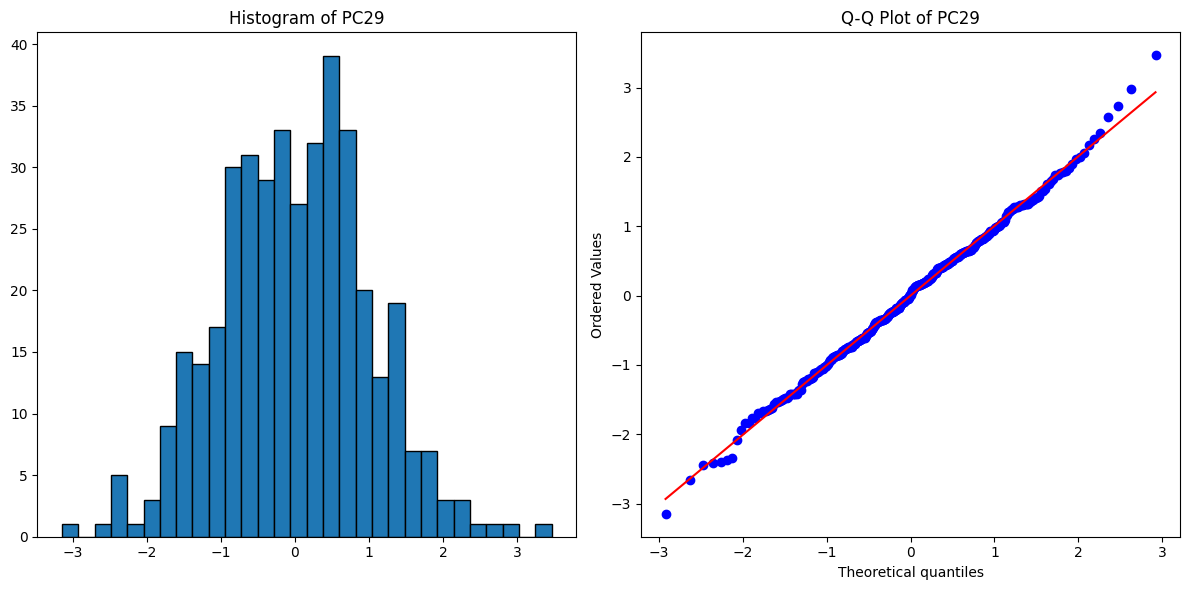

Shapiro-Wilk Test for PC29:
Statistic: 0.9977, p-value: 0.8574
PC29: Sample looks Gaussian (fail to reject H0)


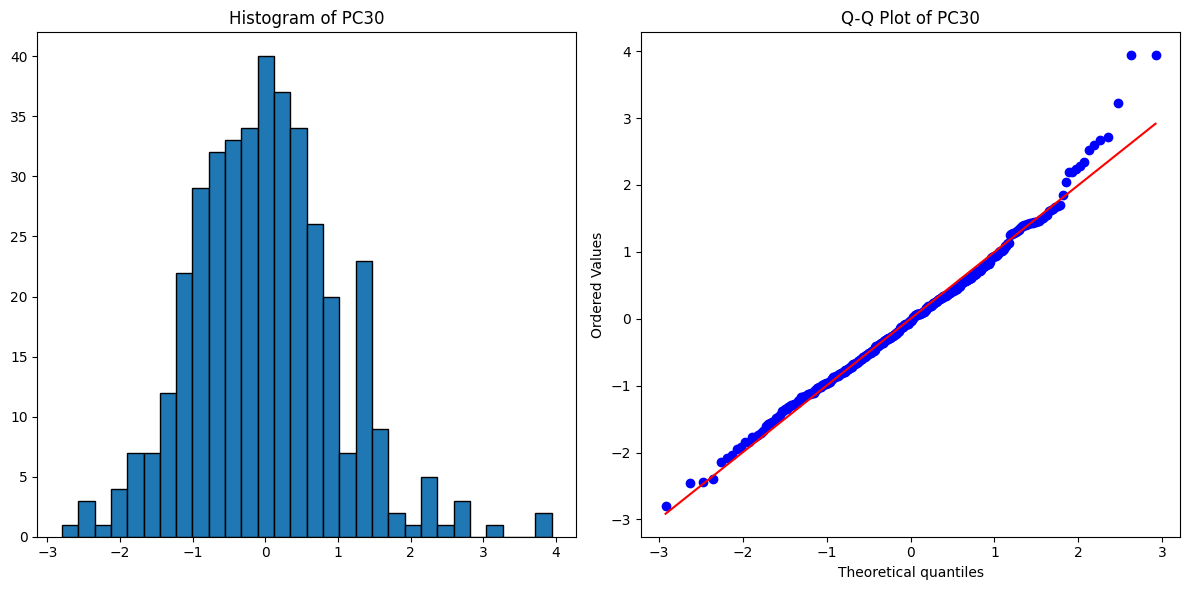

Shapiro-Wilk Test for PC30:
Statistic: 0.9861, p-value: 0.0007
PC30: Sample does not look Gaussian (reject H0)


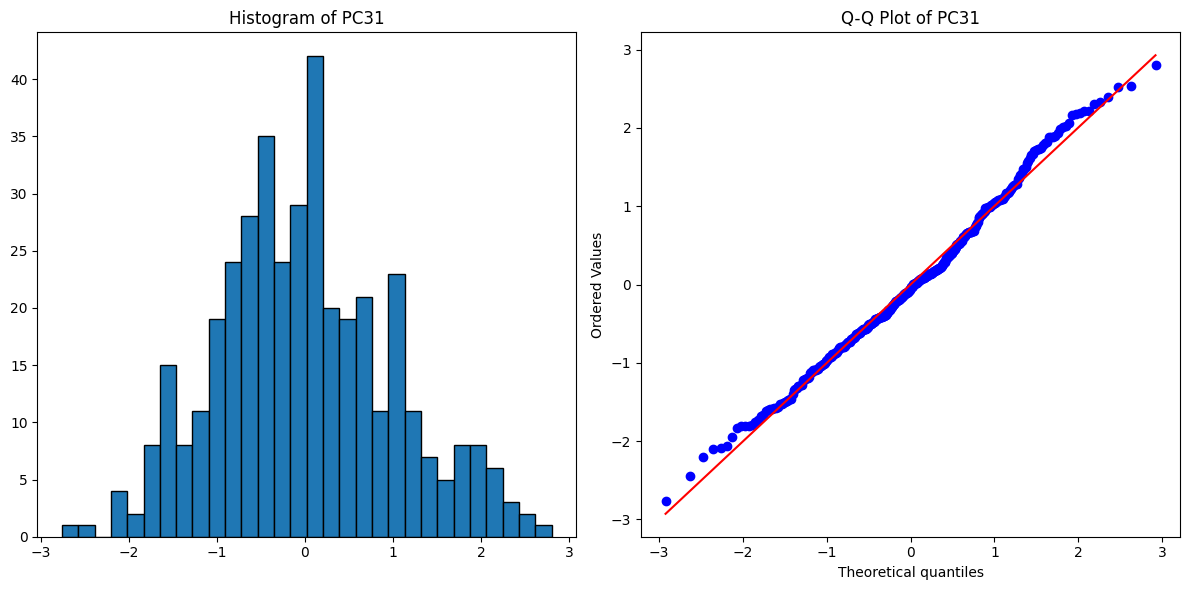

Shapiro-Wilk Test for PC31:
Statistic: 0.9923, p-value: 0.0387
PC31: Sample does not look Gaussian (reject H0)


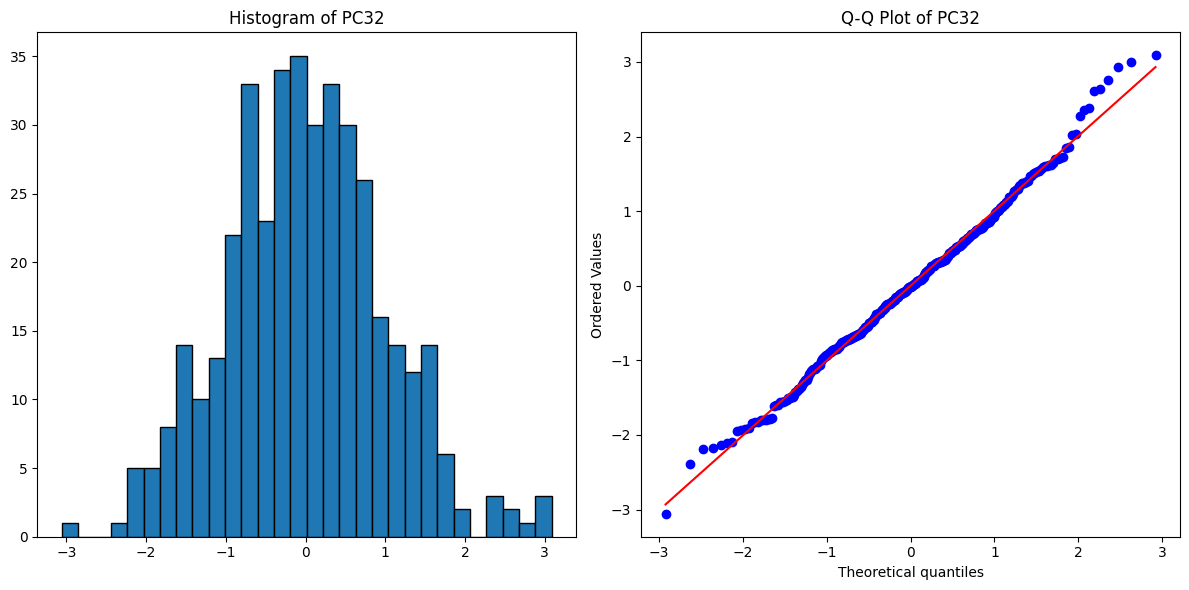

Shapiro-Wilk Test for PC32:
Statistic: 0.9954, p-value: 0.2919
PC32: Sample looks Gaussian (fail to reject H0)


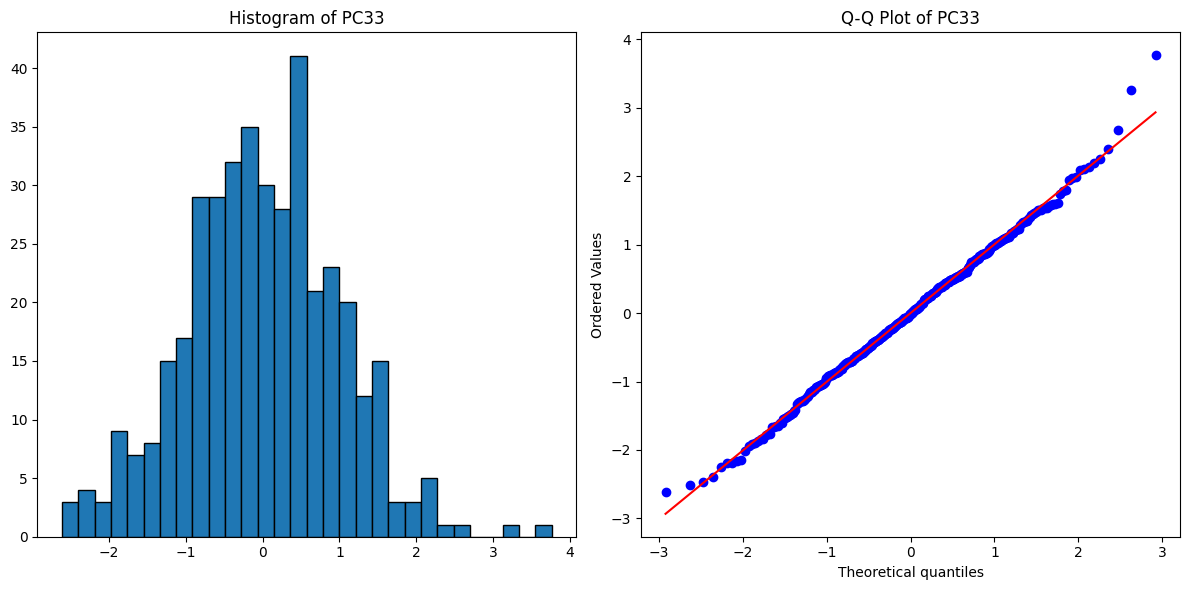

Shapiro-Wilk Test for PC33:
Statistic: 0.9964, p-value: 0.5115
PC33: Sample looks Gaussian (fail to reject H0)


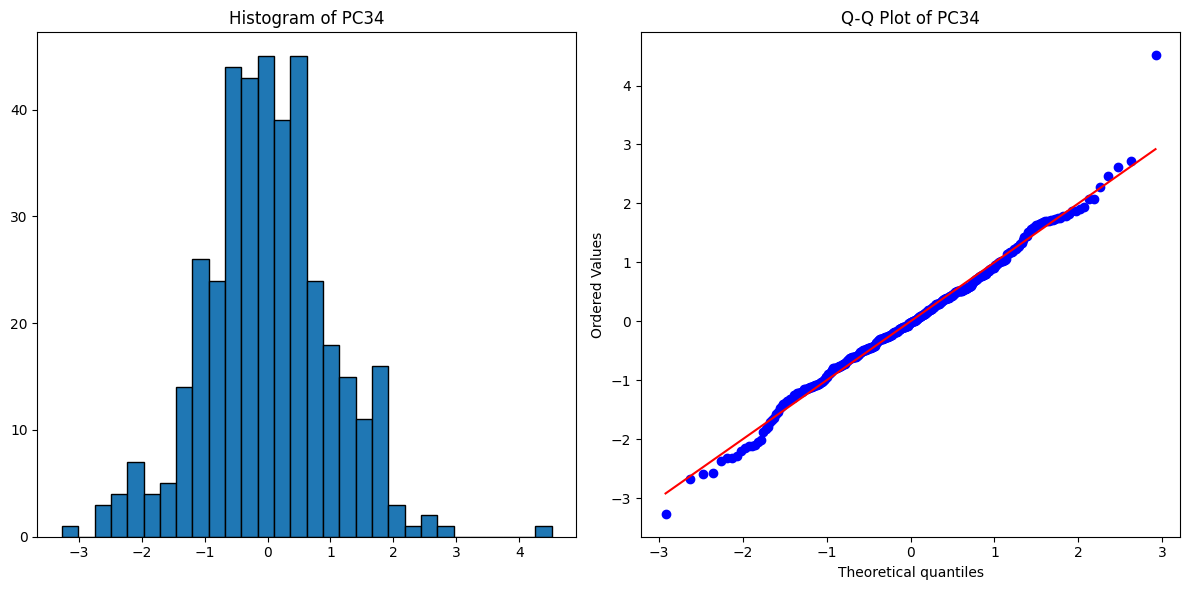

Shapiro-Wilk Test for PC34:
Statistic: 0.9901, p-value: 0.0091
PC34: Sample does not look Gaussian (reject H0)


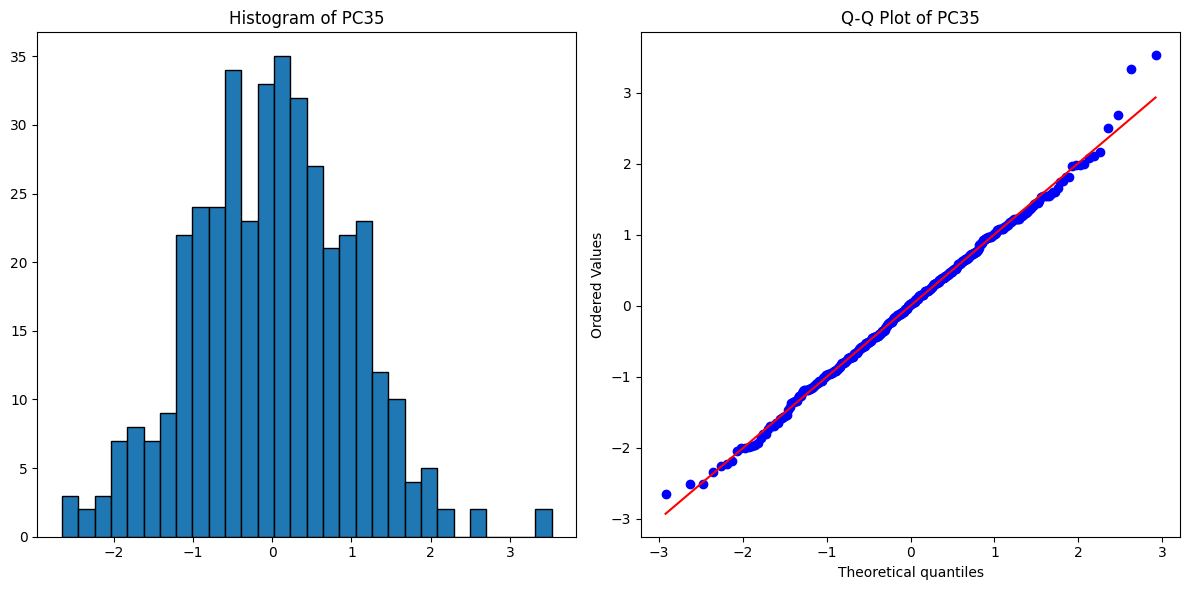

Shapiro-Wilk Test for PC35:
Statistic: 0.9966, p-value: 0.5785
PC35: Sample looks Gaussian (fail to reject H0)


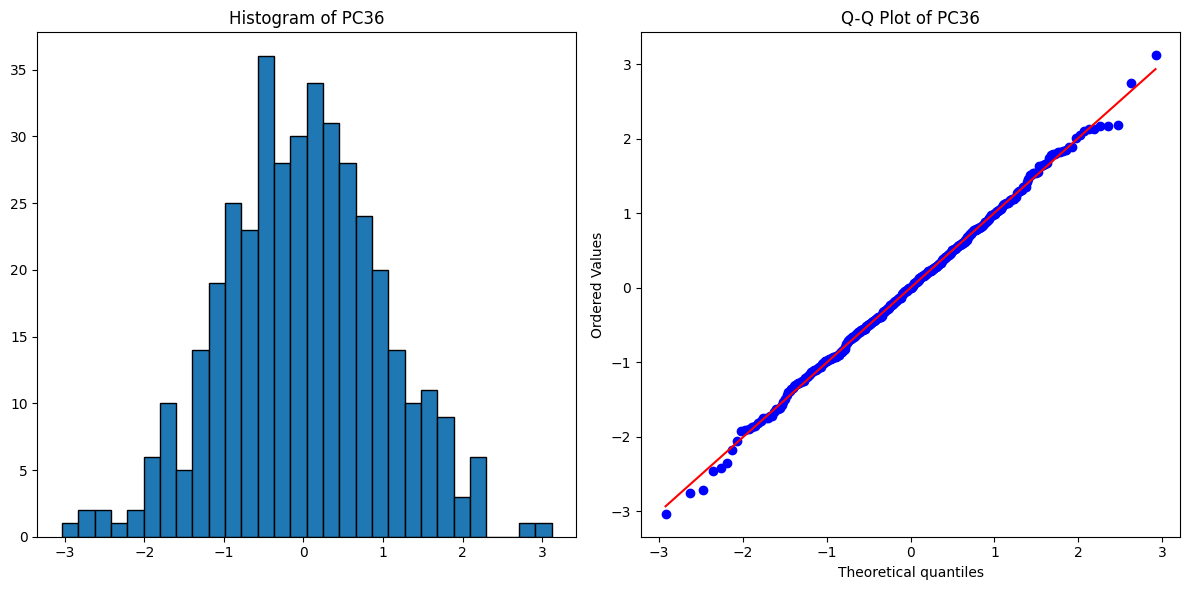

Shapiro-Wilk Test for PC36:
Statistic: 0.9985, p-value: 0.9860
PC36: Sample looks Gaussian (fail to reject H0)


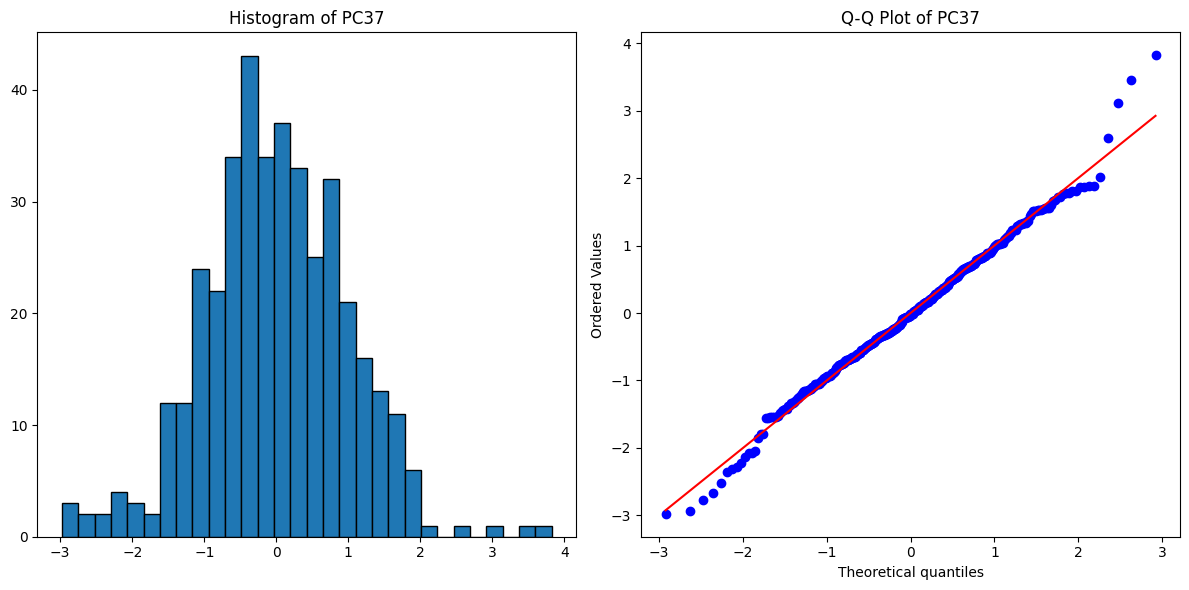

Shapiro-Wilk Test for PC37:
Statistic: 0.9923, p-value: 0.0379
PC37: Sample does not look Gaussian (reject H0)


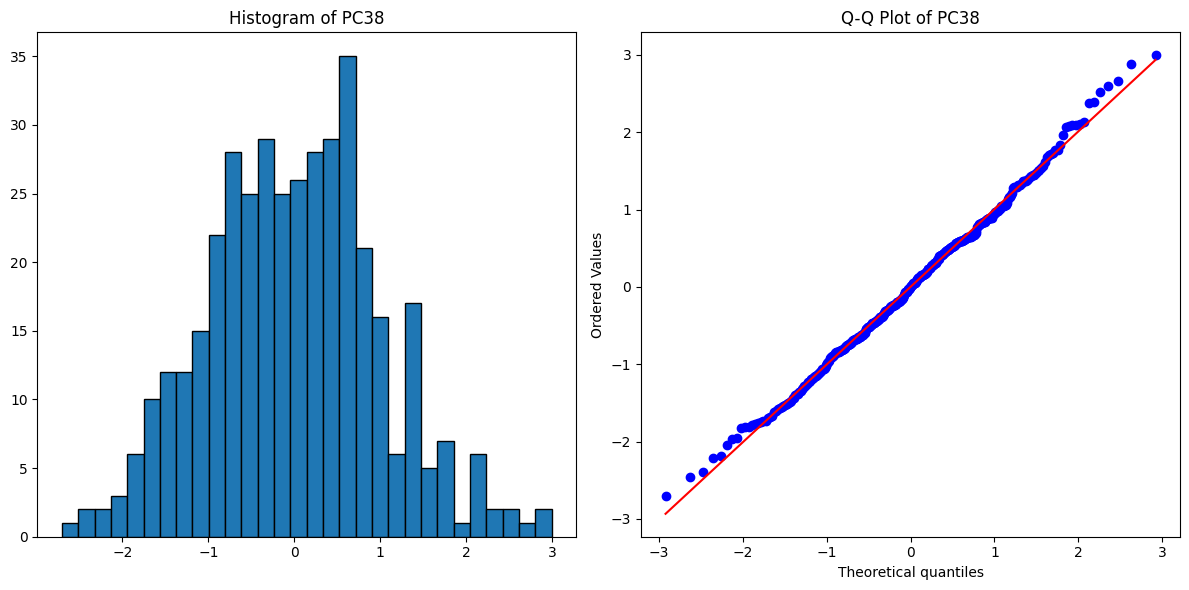

Shapiro-Wilk Test for PC38:
Statistic: 0.9966, p-value: 0.5834
PC38: Sample looks Gaussian (fail to reject H0)


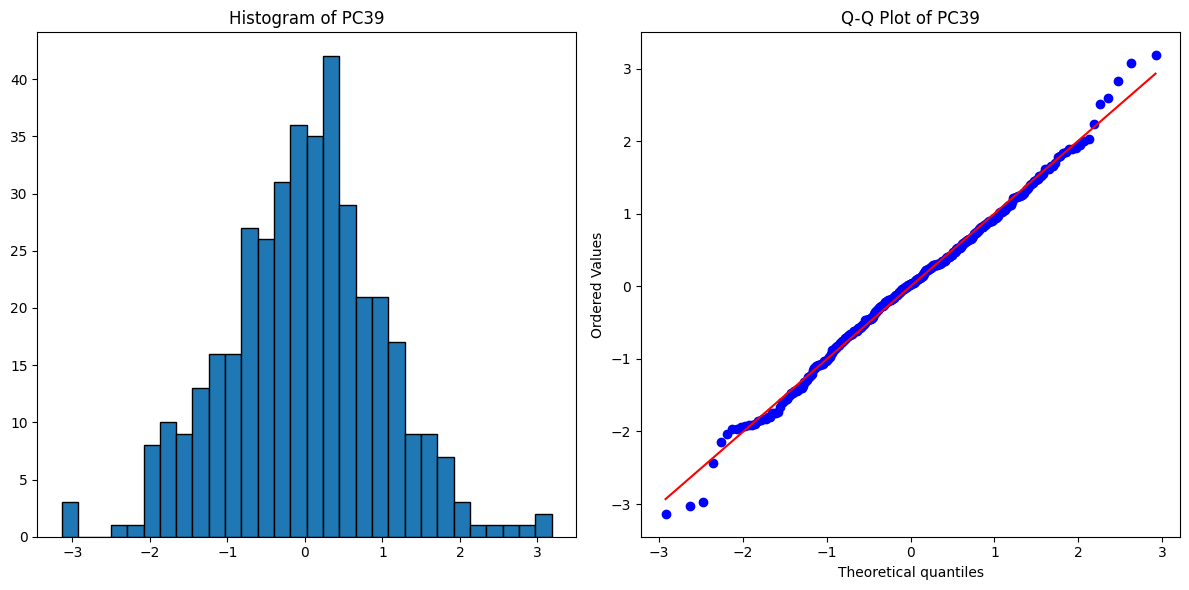

Shapiro-Wilk Test for PC39:
Statistic: 0.9954, p-value: 0.3032
PC39: Sample looks Gaussian (fail to reject H0)


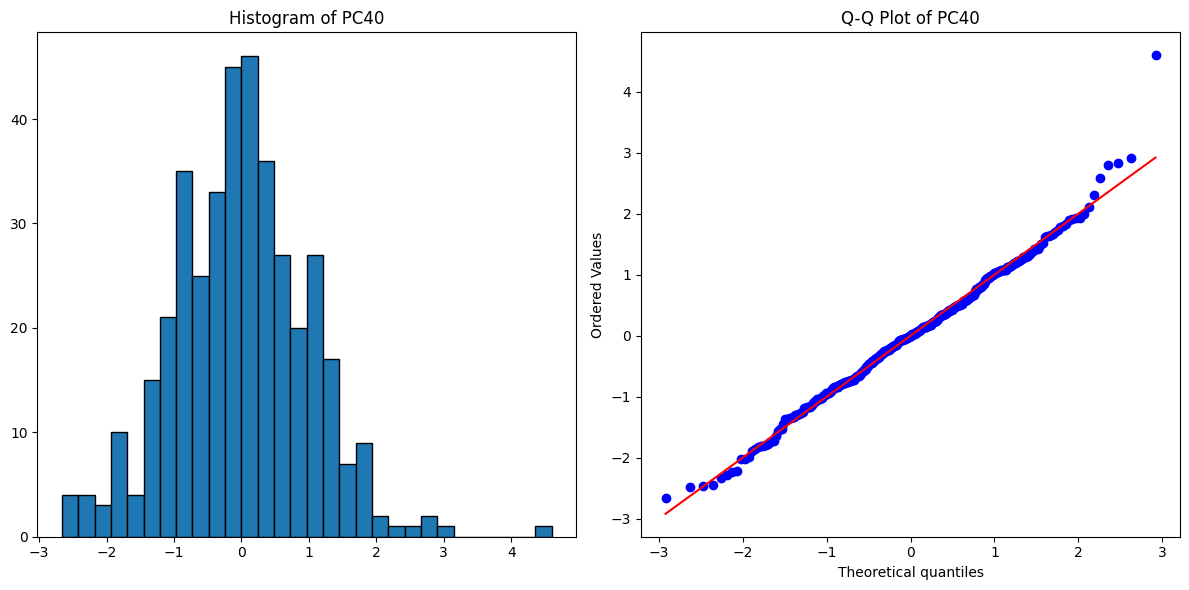

Shapiro-Wilk Test for PC40:
Statistic: 0.9907, p-value: 0.0131
PC40: Sample does not look Gaussian (reject H0)


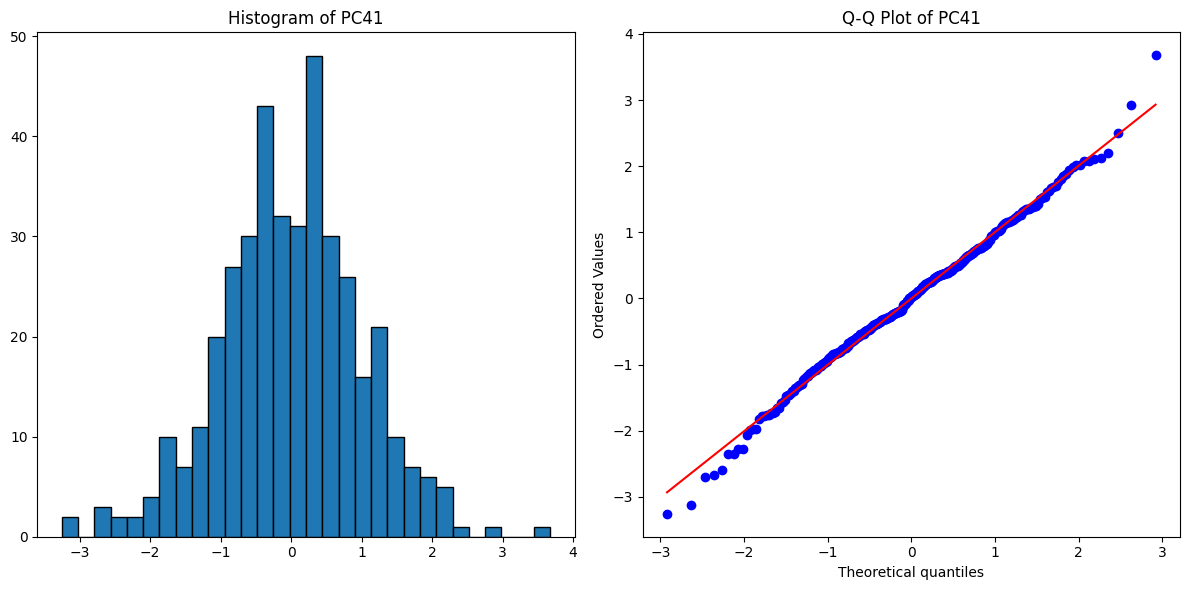

Shapiro-Wilk Test for PC41:
Statistic: 0.9955, p-value: 0.3047
PC41: Sample looks Gaussian (fail to reject H0)


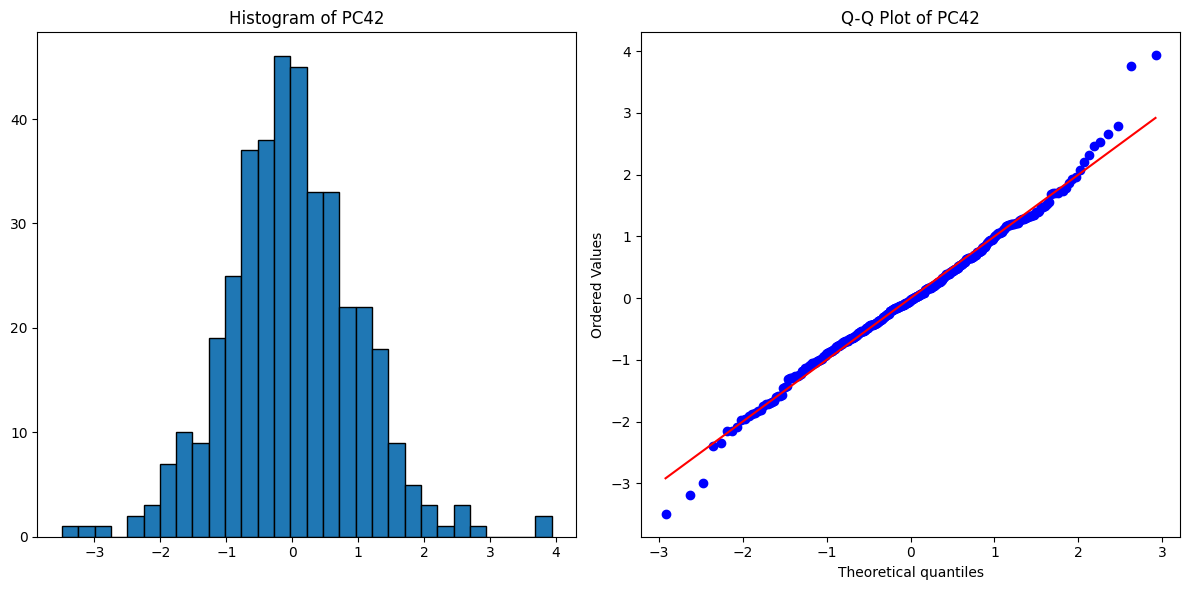

Shapiro-Wilk Test for PC42:
Statistic: 0.9896, p-value: 0.0064
PC42: Sample does not look Gaussian (reject H0)


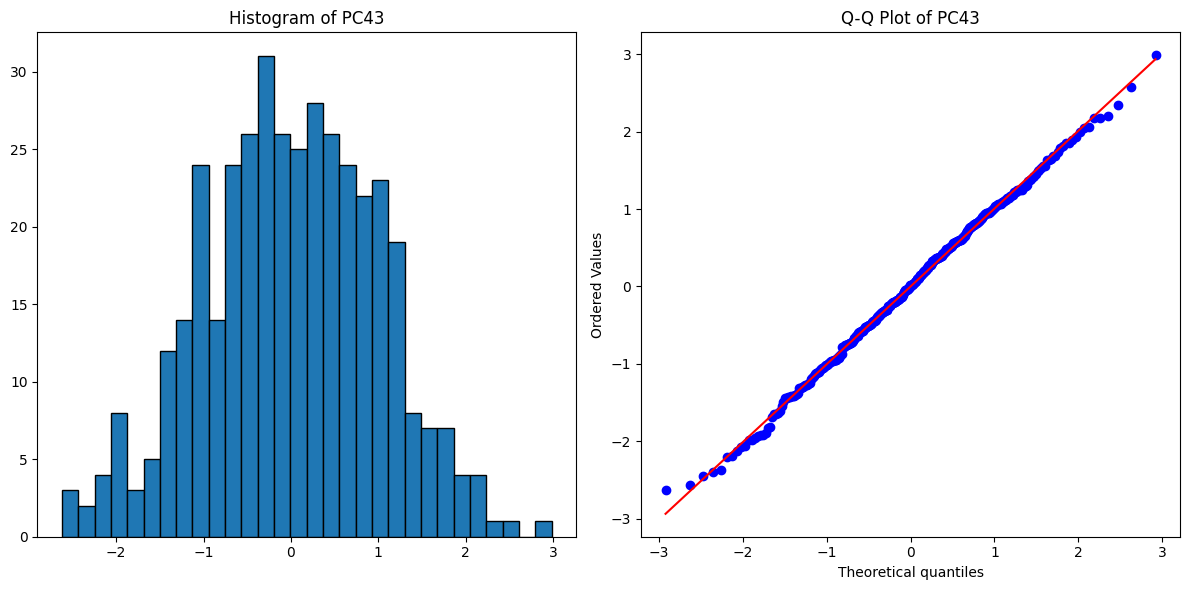

Shapiro-Wilk Test for PC43:
Statistic: 0.9977, p-value: 0.8605
PC43: Sample looks Gaussian (fail to reject H0)


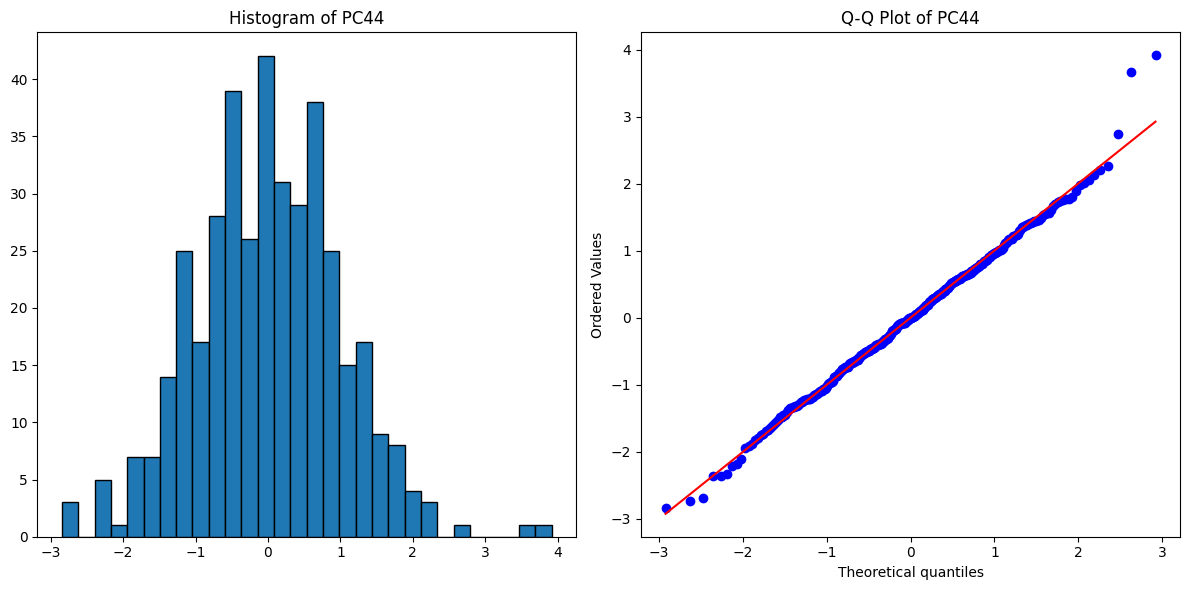

Shapiro-Wilk Test for PC44:
Statistic: 0.9944, p-value: 0.1575
PC44: Sample looks Gaussian (fail to reject H0)


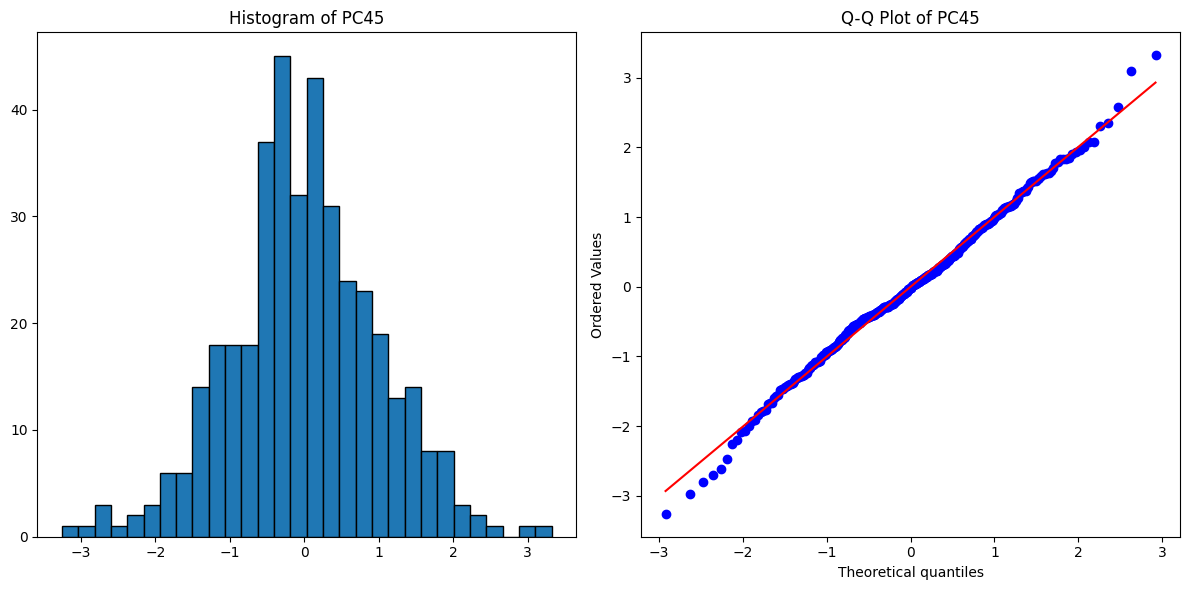

Shapiro-Wilk Test for PC45:
Statistic: 0.9957, p-value: 0.3593
PC45: Sample looks Gaussian (fail to reject H0)


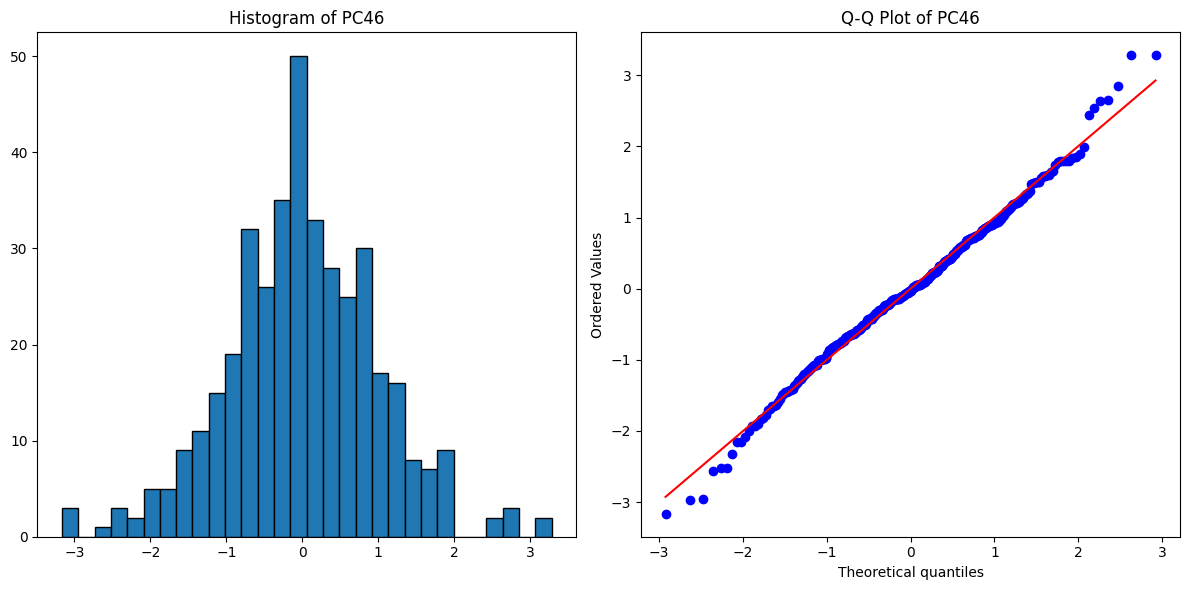

Shapiro-Wilk Test for PC46:
Statistic: 0.9933, p-value: 0.0778
PC46: Sample looks Gaussian (fail to reject H0)


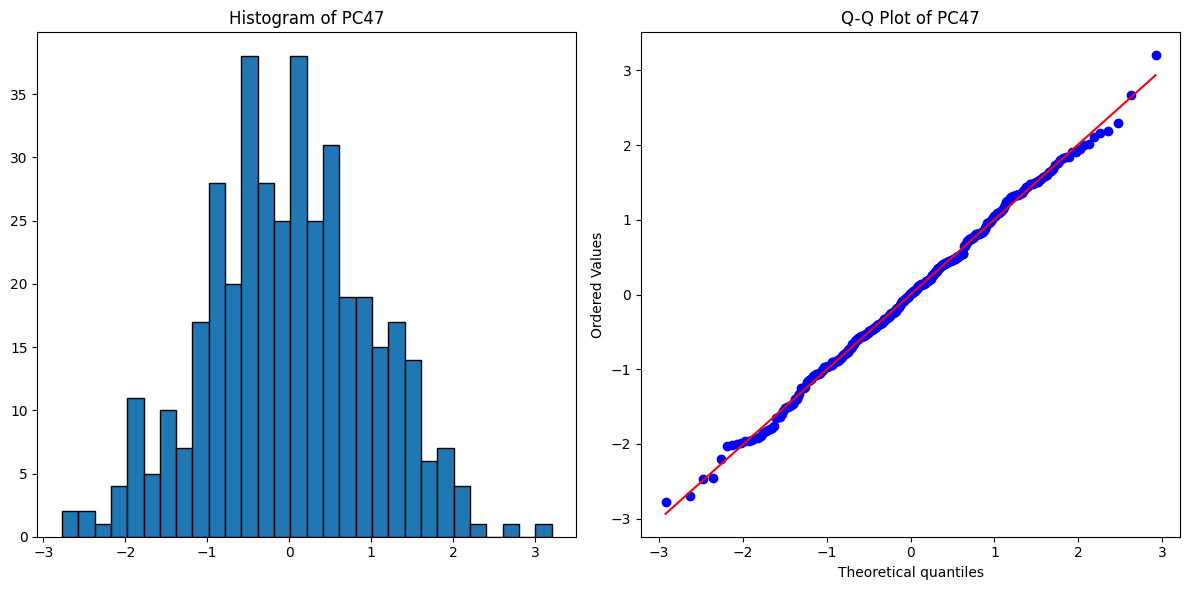

Shapiro-Wilk Test for PC47:
Statistic: 0.9978, p-value: 0.8948
PC47: Sample looks Gaussian (fail to reject H0)


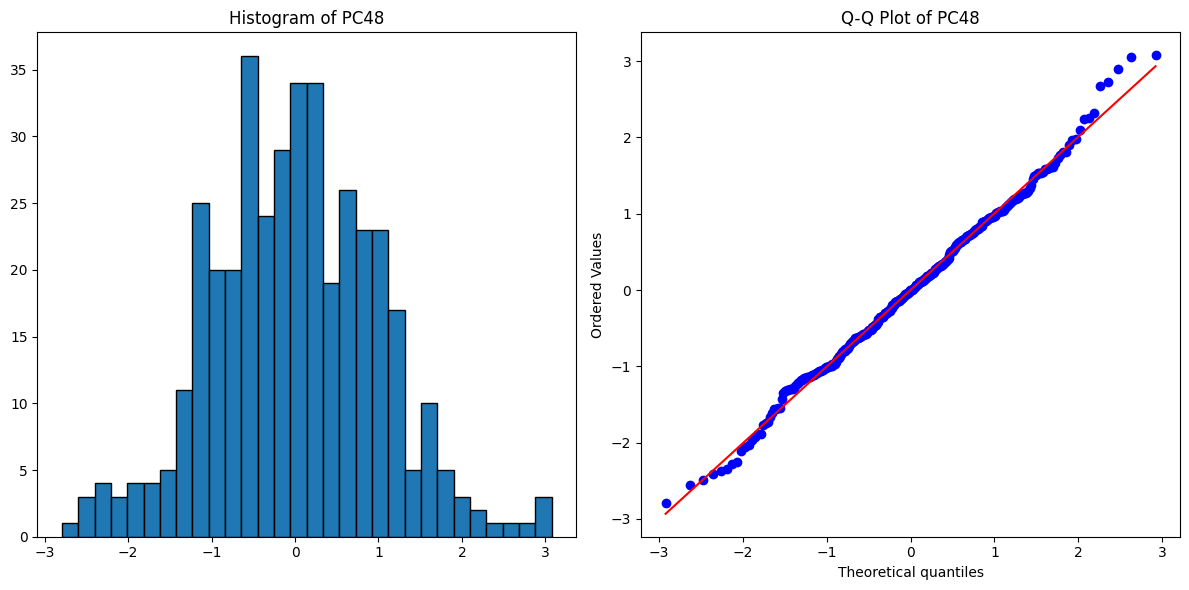

Shapiro-Wilk Test for PC48:
Statistic: 0.9957, p-value: 0.3606
PC48: Sample looks Gaussian (fail to reject H0)


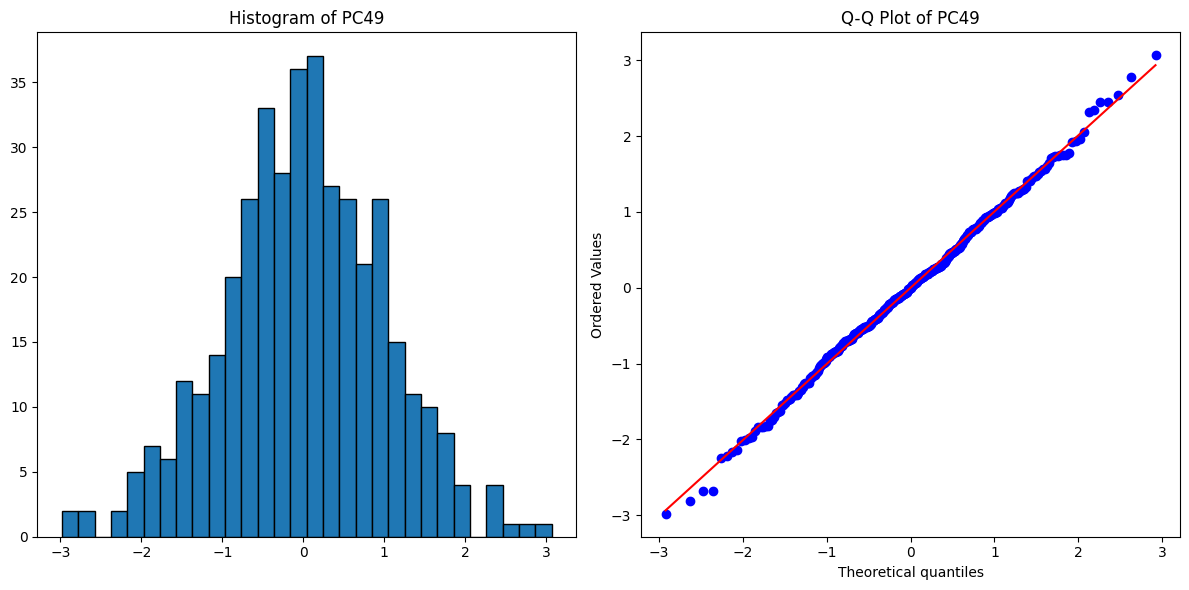

Shapiro-Wilk Test for PC49:
Statistic: 0.9980, p-value: 0.9178
PC49: Sample looks Gaussian (fail to reject H0)


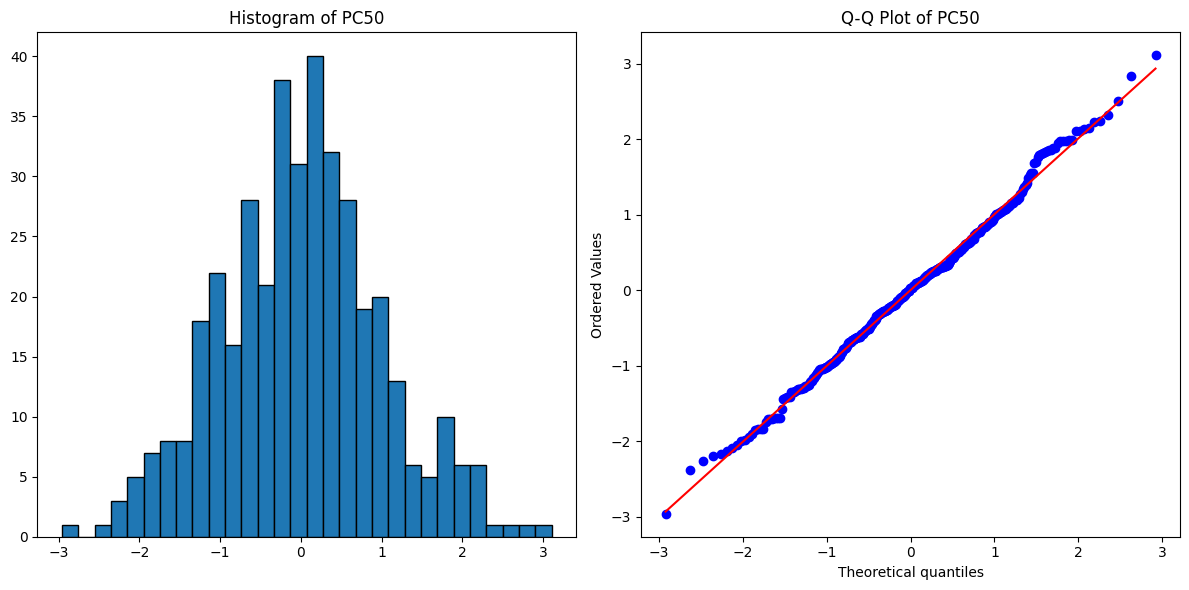

Shapiro-Wilk Test for PC50:
Statistic: 0.9959, p-value: 0.4002
PC50: Sample looks Gaussian (fail to reject H0)


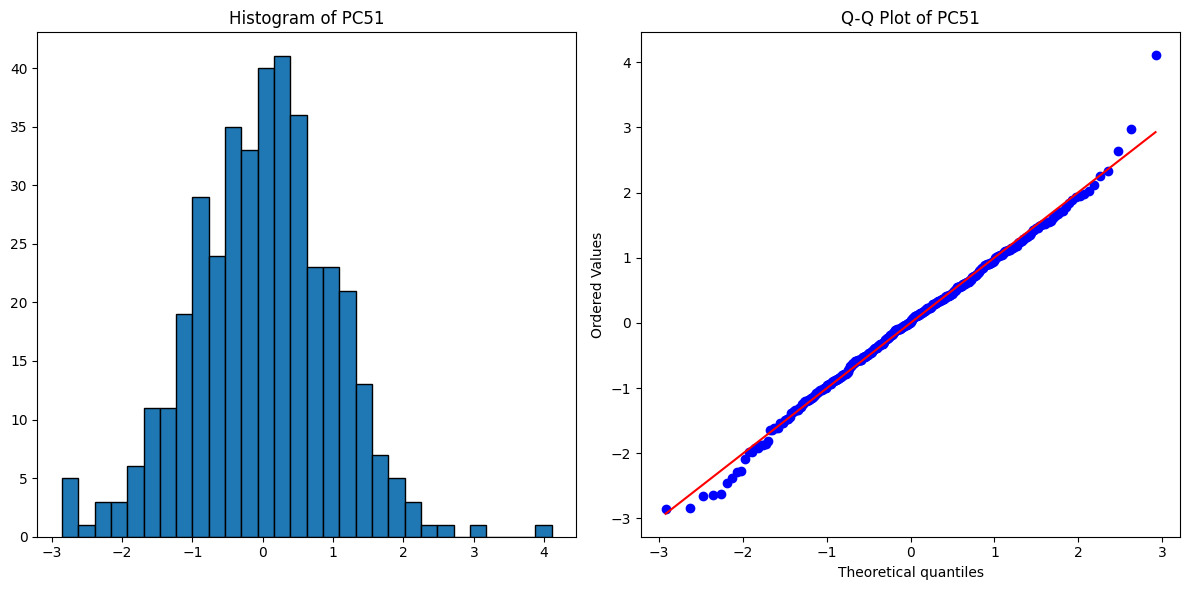

Shapiro-Wilk Test for PC51:
Statistic: 0.9942, p-value: 0.1385
PC51: Sample looks Gaussian (fail to reject H0)


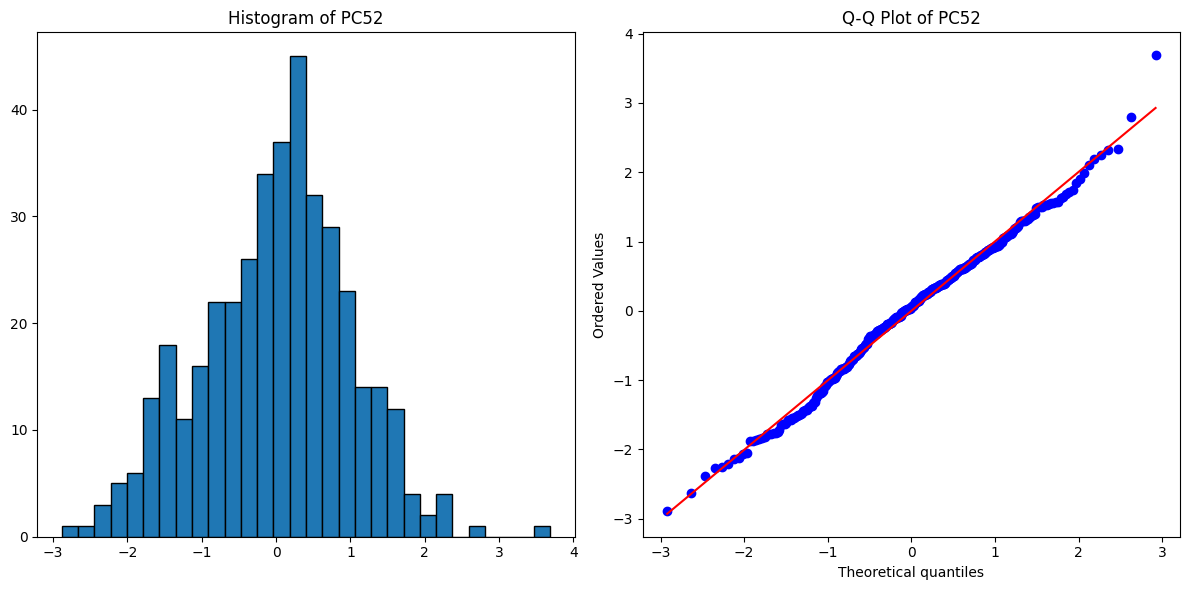

Shapiro-Wilk Test for PC52:
Statistic: 0.9934, p-value: 0.0804
PC52: Sample looks Gaussian (fail to reject H0)


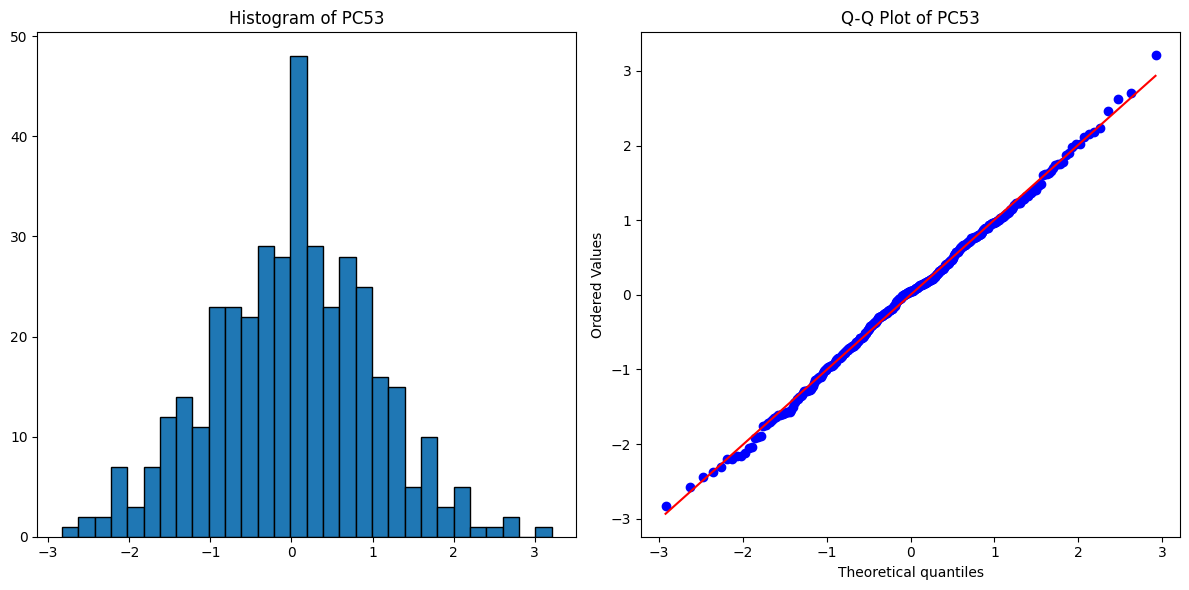

Shapiro-Wilk Test for PC53:
Statistic: 0.9976, p-value: 0.8310
PC53: Sample looks Gaussian (fail to reject H0)


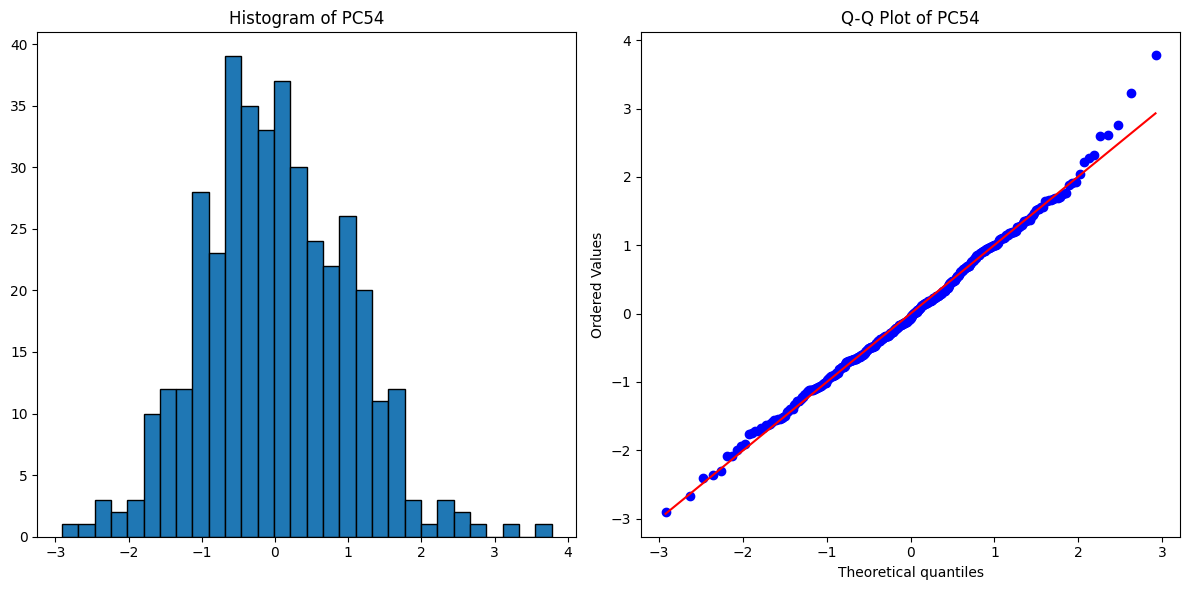

Shapiro-Wilk Test for PC54:
Statistic: 0.9955, p-value: 0.3098
PC54: Sample looks Gaussian (fail to reject H0)


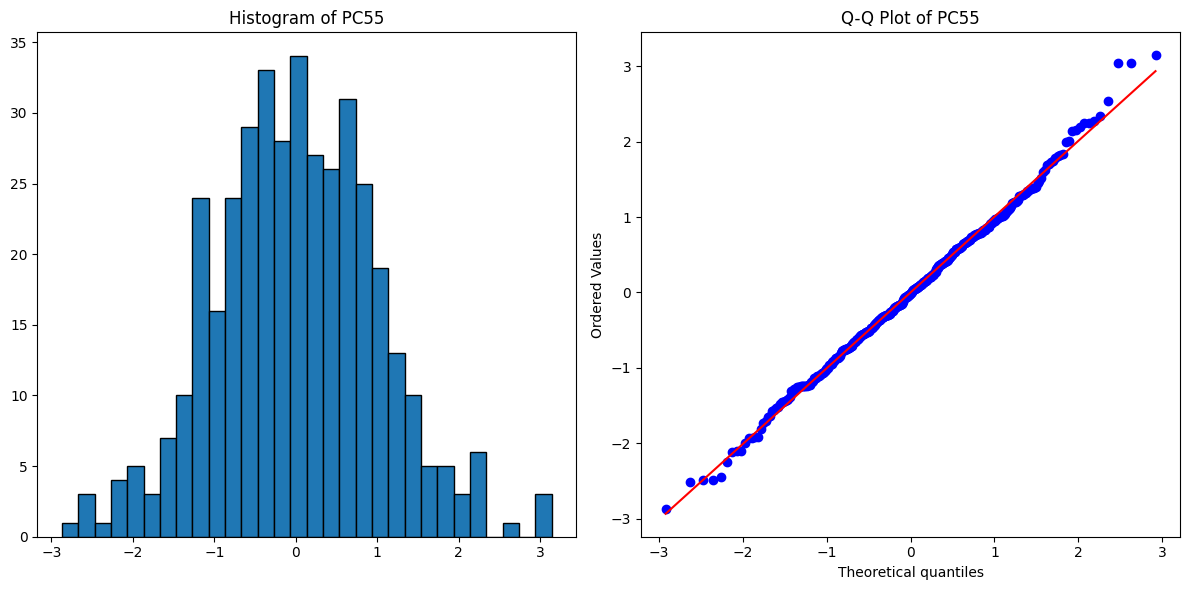

Shapiro-Wilk Test for PC55:
Statistic: 0.9967, p-value: 0.6118
PC55: Sample looks Gaussian (fail to reject H0)


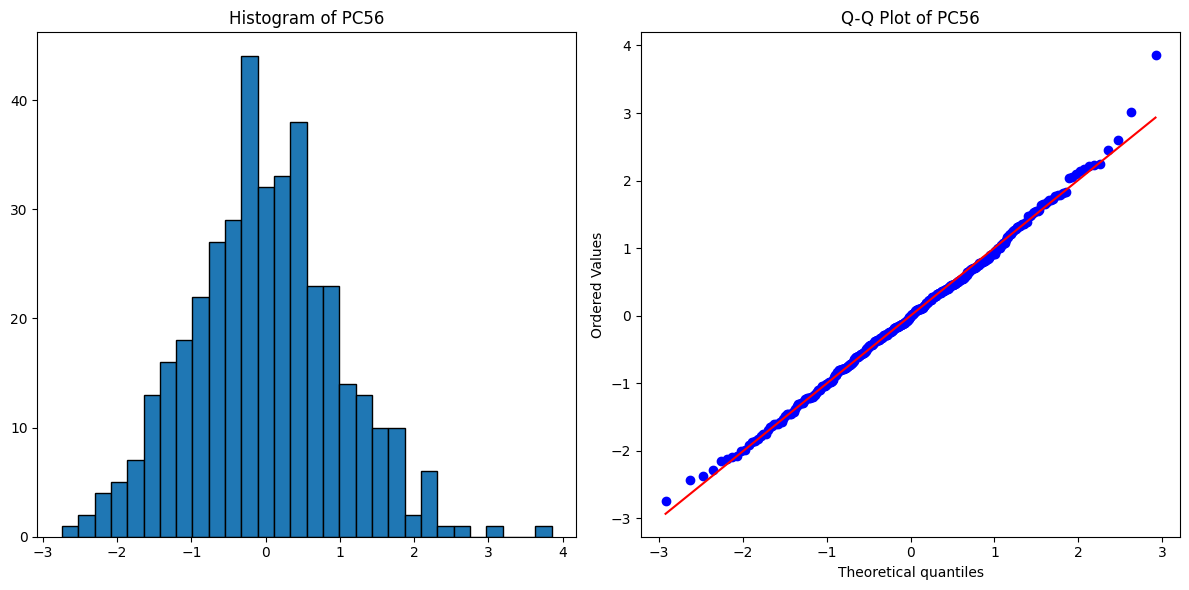

Shapiro-Wilk Test for PC56:
Statistic: 0.9965, p-value: 0.5345
PC56: Sample looks Gaussian (fail to reject H0)


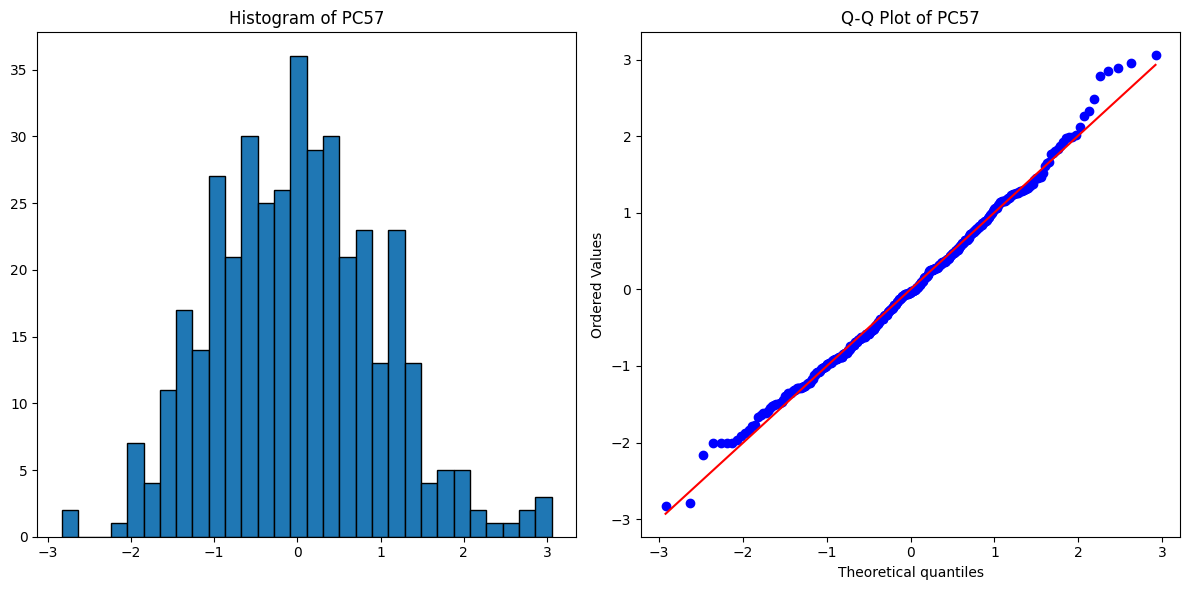

Shapiro-Wilk Test for PC57:
Statistic: 0.9943, p-value: 0.1431
PC57: Sample looks Gaussian (fail to reject H0)


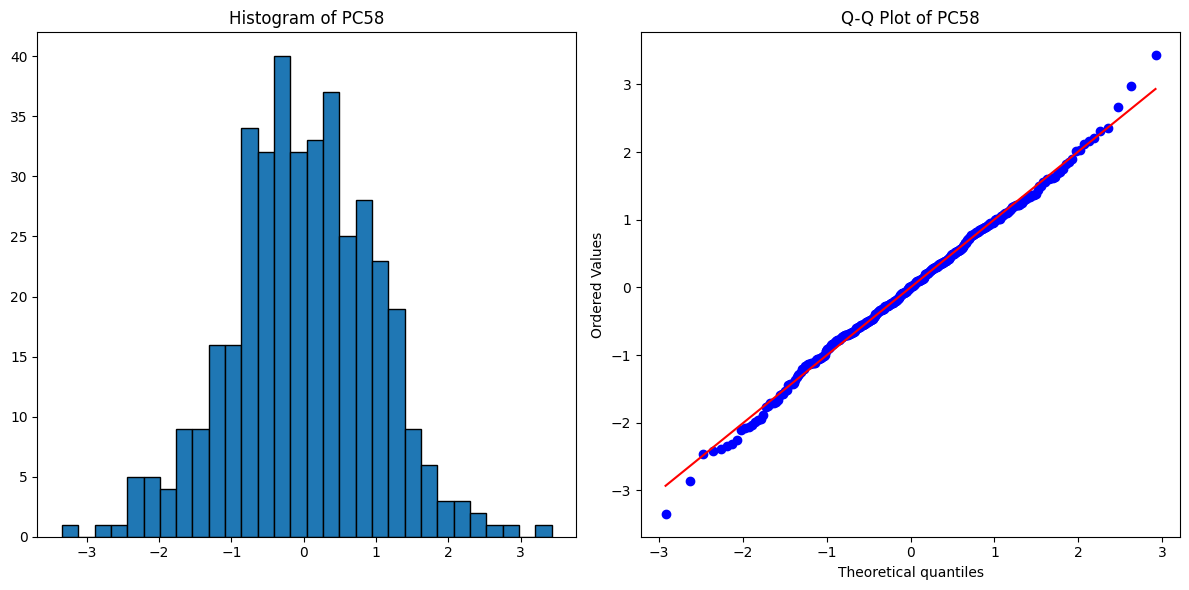

Shapiro-Wilk Test for PC58:
Statistic: 0.9972, p-value: 0.7467
PC58: Sample looks Gaussian (fail to reject H0)


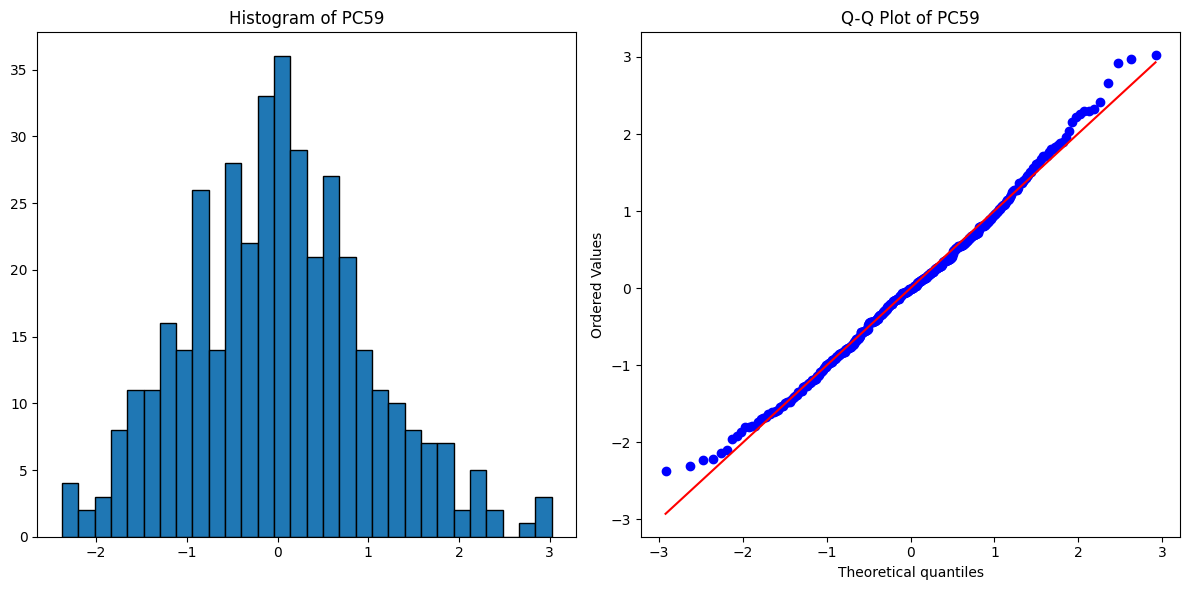

Shapiro-Wilk Test for PC59:
Statistic: 0.9937, p-value: 0.0975
PC59: Sample looks Gaussian (fail to reject H0)


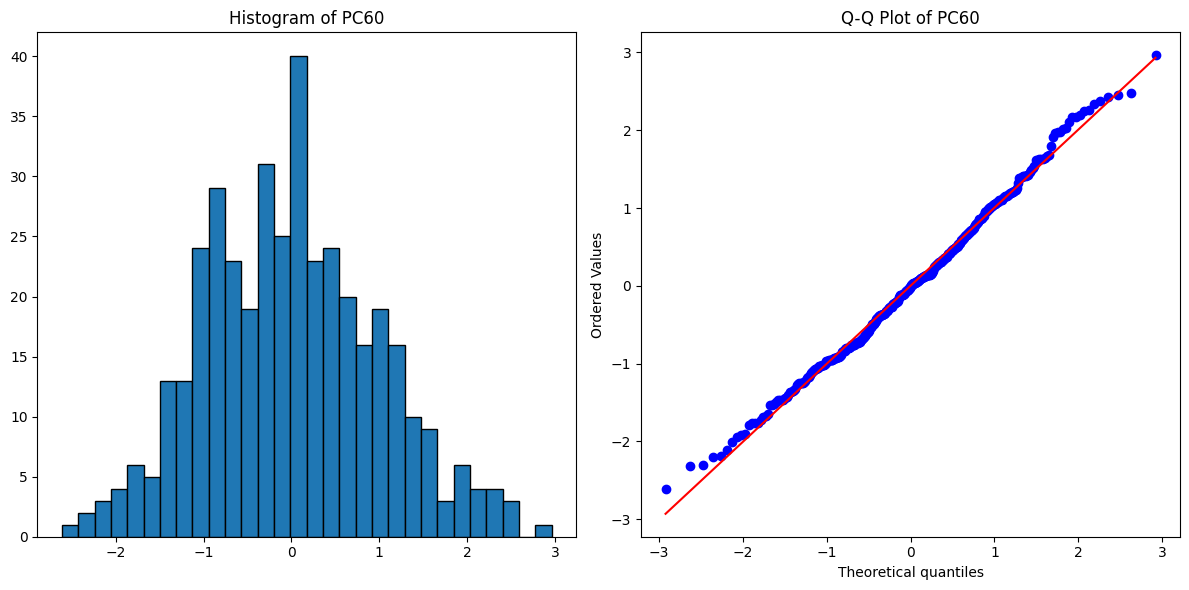

Shapiro-Wilk Test for PC60:
Statistic: 0.9946, p-value: 0.1735
PC60: Sample looks Gaussian (fail to reject H0)


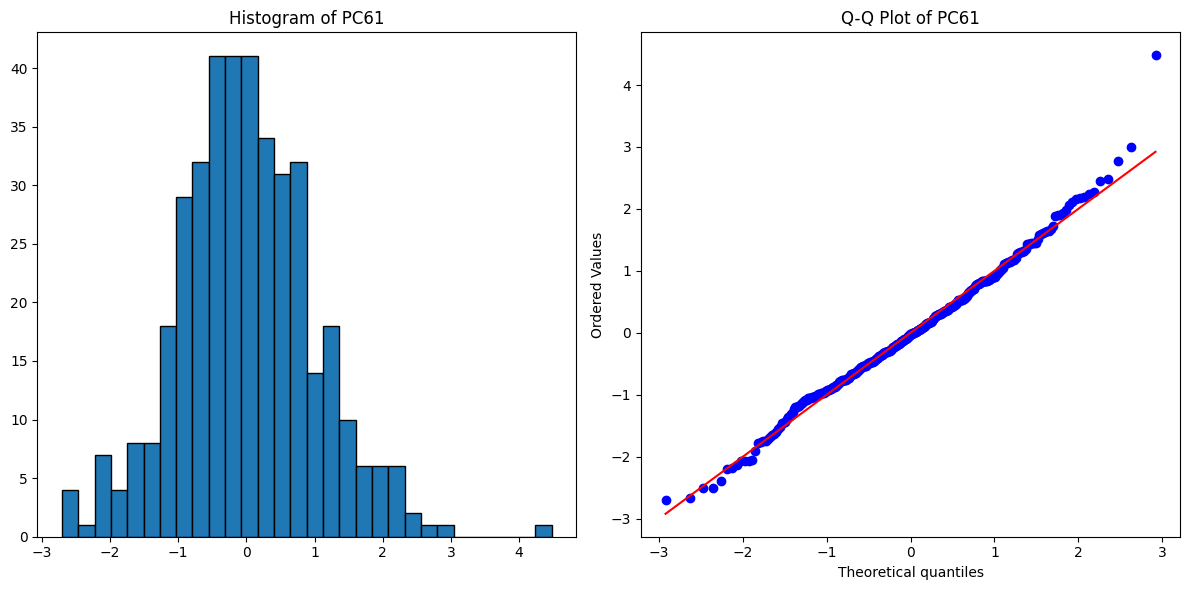

Shapiro-Wilk Test for PC61:
Statistic: 0.9905, p-value: 0.0119
PC61: Sample does not look Gaussian (reject H0)


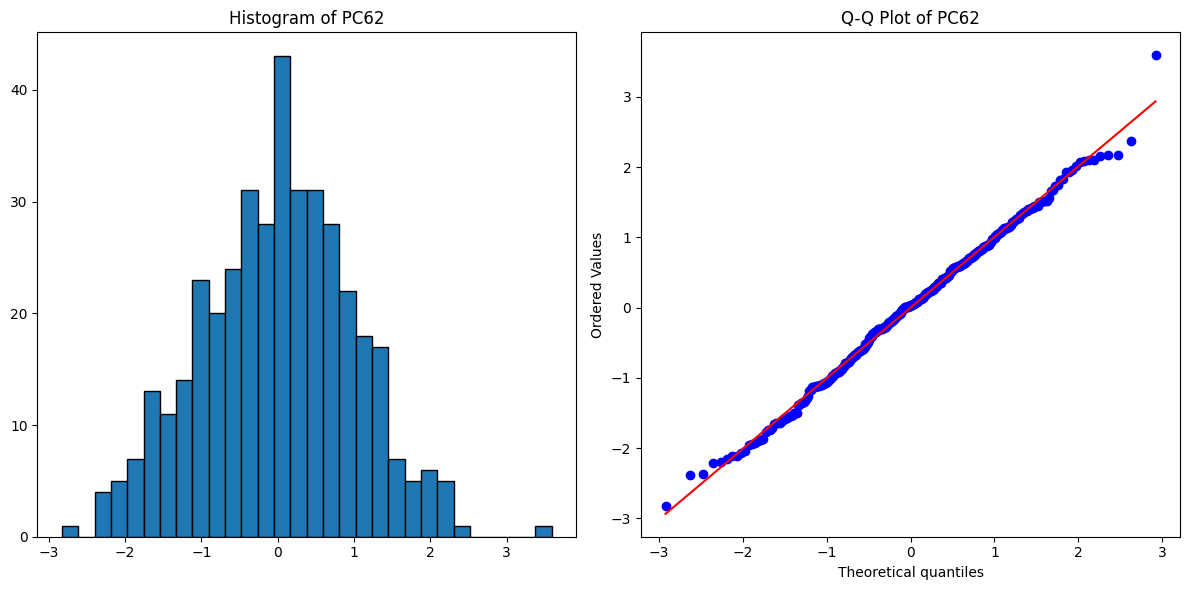

Shapiro-Wilk Test for PC62:
Statistic: 0.9967, p-value: 0.5954
PC62: Sample looks Gaussian (fail to reject H0)


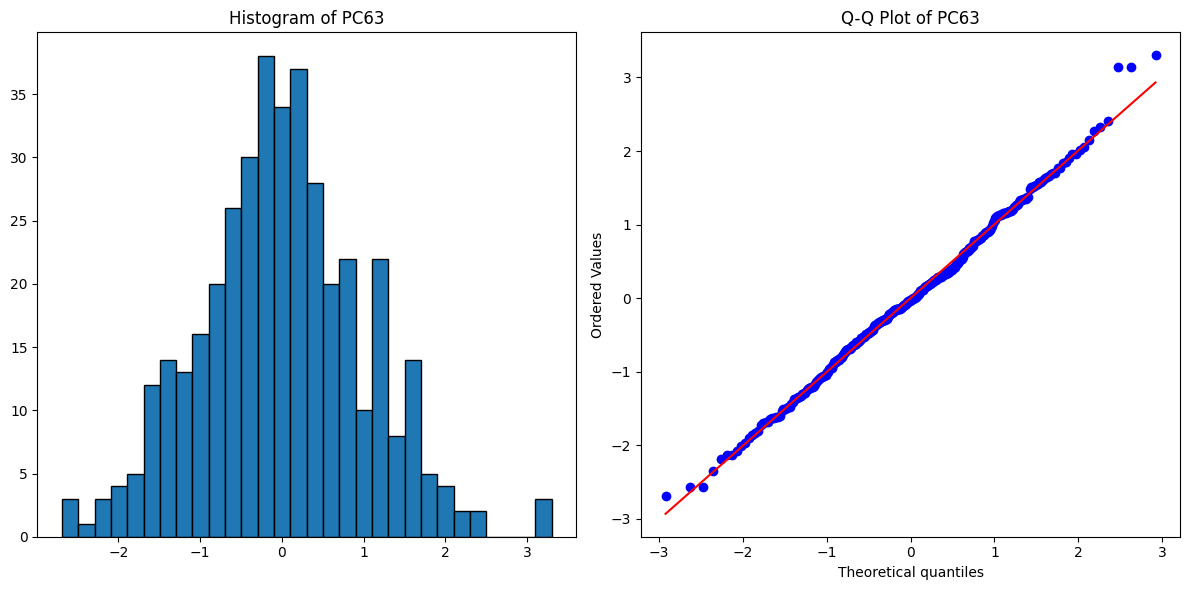

Shapiro-Wilk Test for PC63:
Statistic: 0.9960, p-value: 0.4172
PC63: Sample looks Gaussian (fail to reject H0)


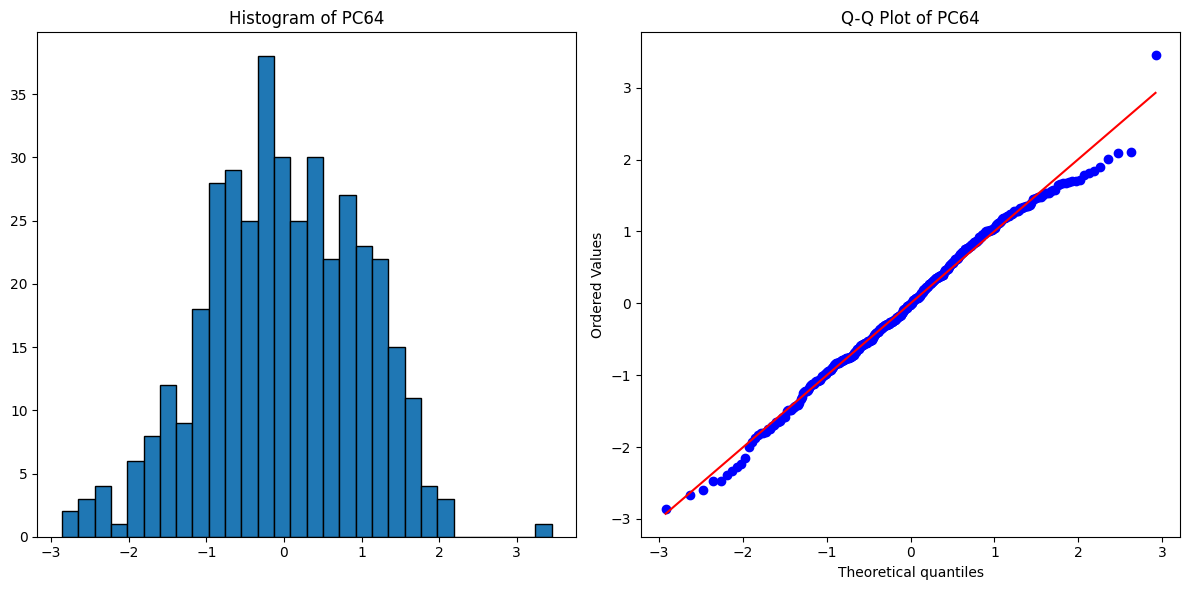

Shapiro-Wilk Test for PC64:
Statistic: 0.9932, p-value: 0.0691
PC64: Sample looks Gaussian (fail to reject H0)


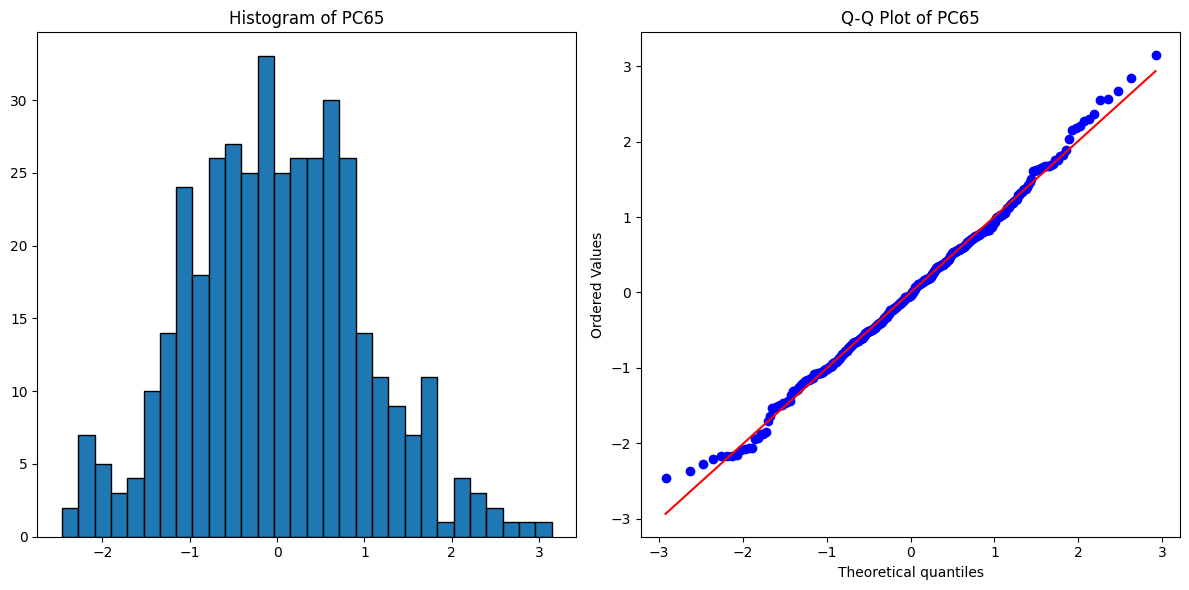

Shapiro-Wilk Test for PC65:
Statistic: 0.9955, p-value: 0.3172
PC65: Sample looks Gaussian (fail to reject H0)


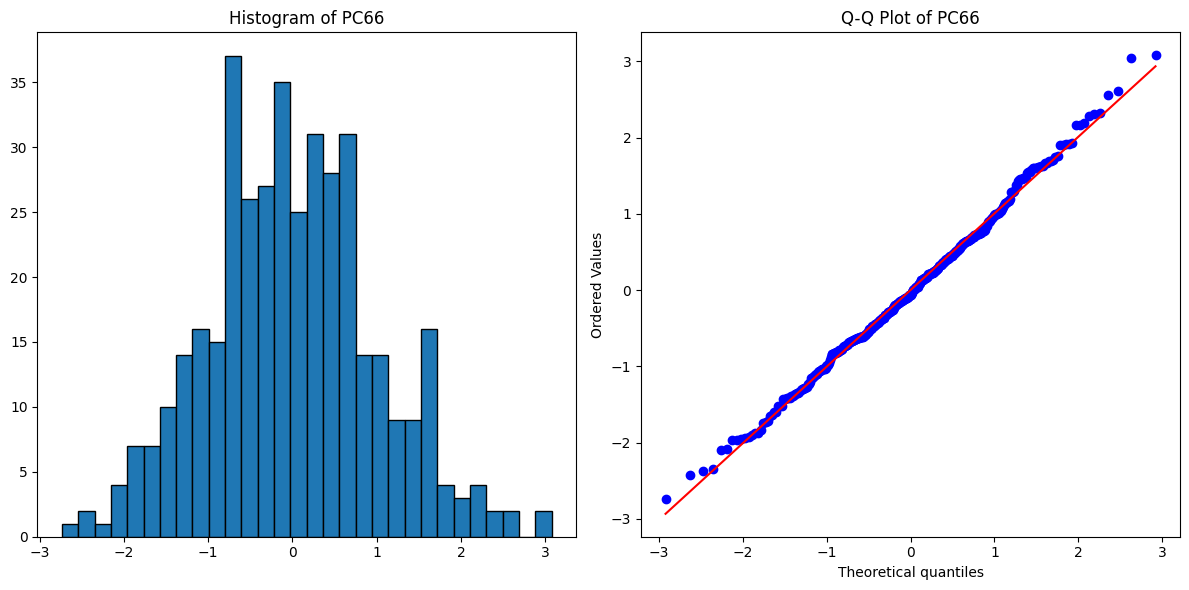

Shapiro-Wilk Test for PC66:
Statistic: 0.9962, p-value: 0.4695
PC66: Sample looks Gaussian (fail to reject H0)


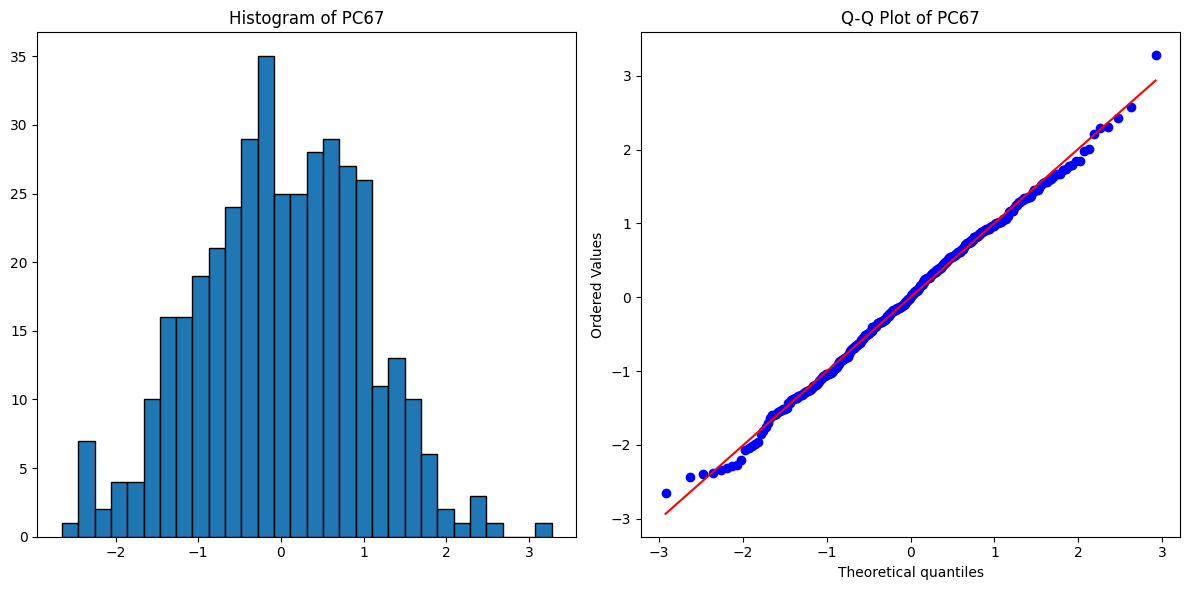

Shapiro-Wilk Test for PC67:
Statistic: 0.9968, p-value: 0.6340
PC67: Sample looks Gaussian (fail to reject H0)


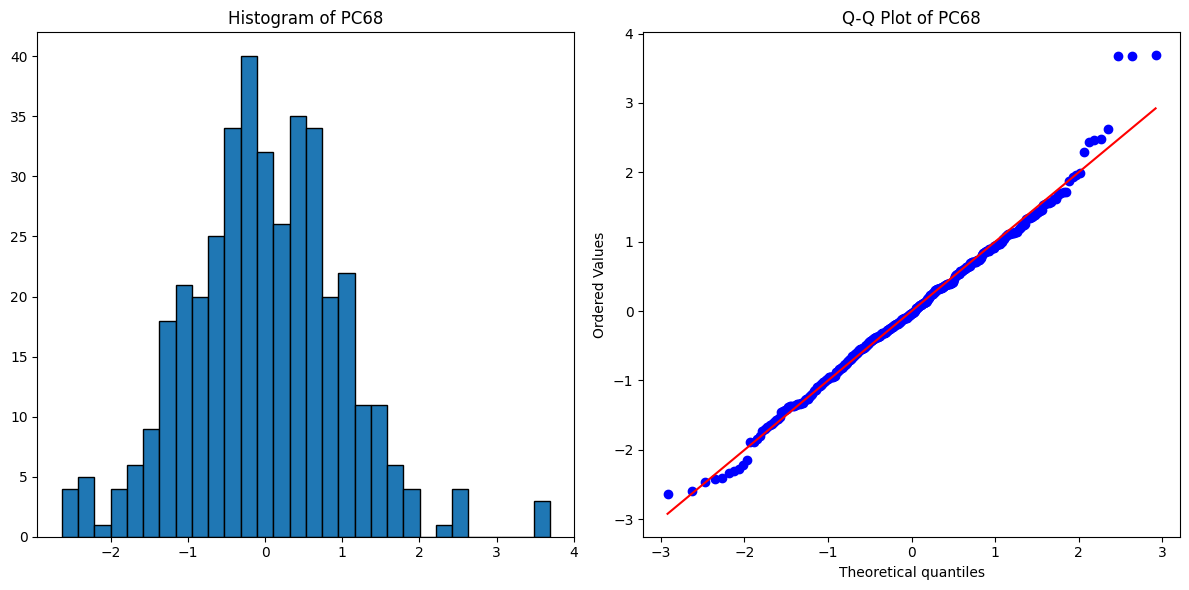

Shapiro-Wilk Test for PC68:
Statistic: 0.9891, p-value: 0.0049
PC68: Sample does not look Gaussian (reject H0)


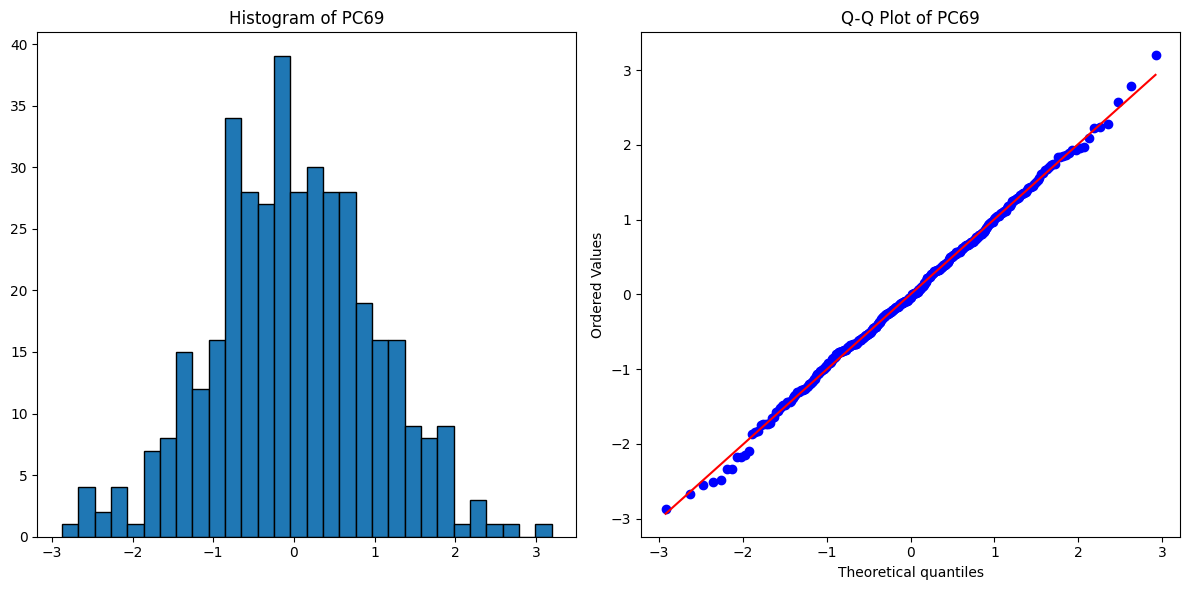

Shapiro-Wilk Test for PC69:
Statistic: 0.9983, p-value: 0.9698
PC69: Sample looks Gaussian (fail to reject H0)


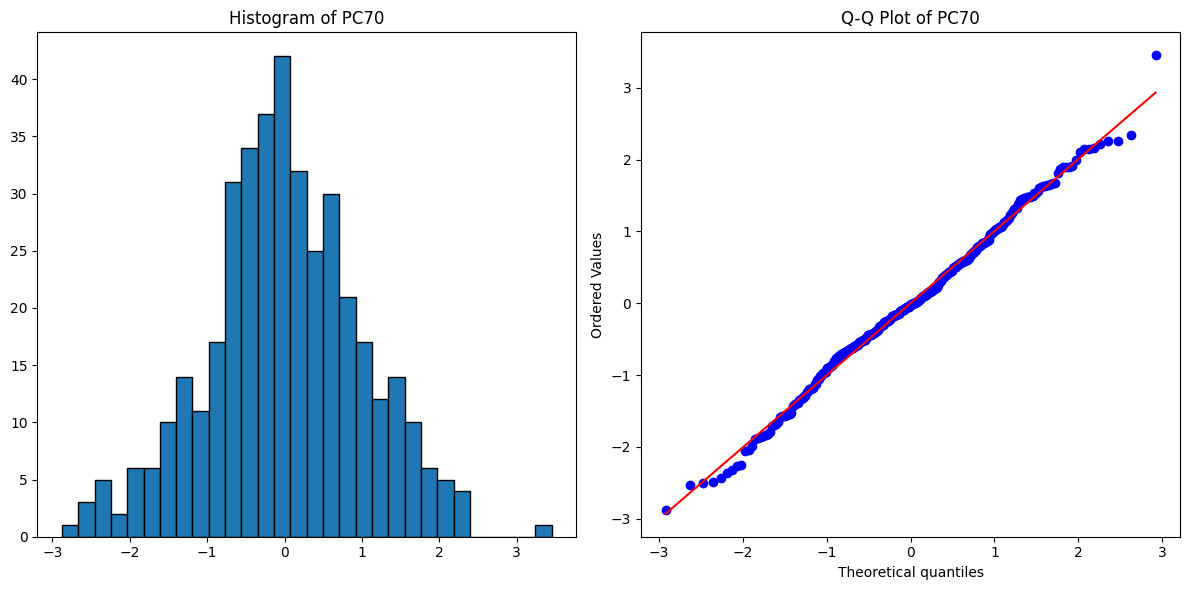

Shapiro-Wilk Test for PC70:
Statistic: 0.9957, p-value: 0.3423
PC70: Sample looks Gaussian (fail to reject H0)


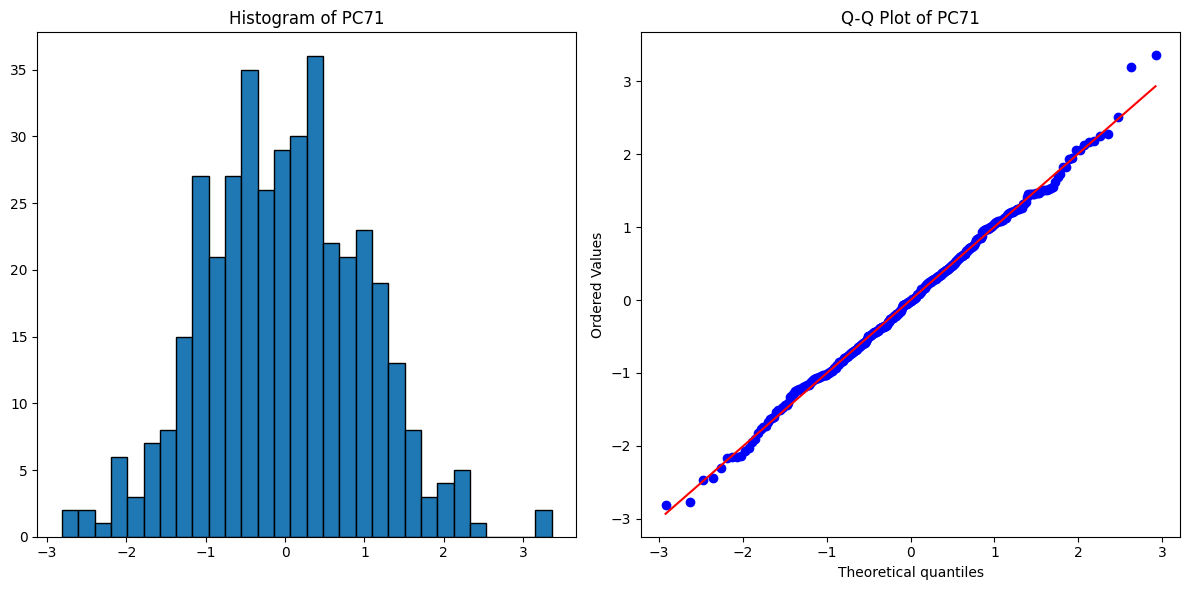

Shapiro-Wilk Test for PC71:
Statistic: 0.9973, p-value: 0.7647
PC71: Sample looks Gaussian (fail to reject H0)


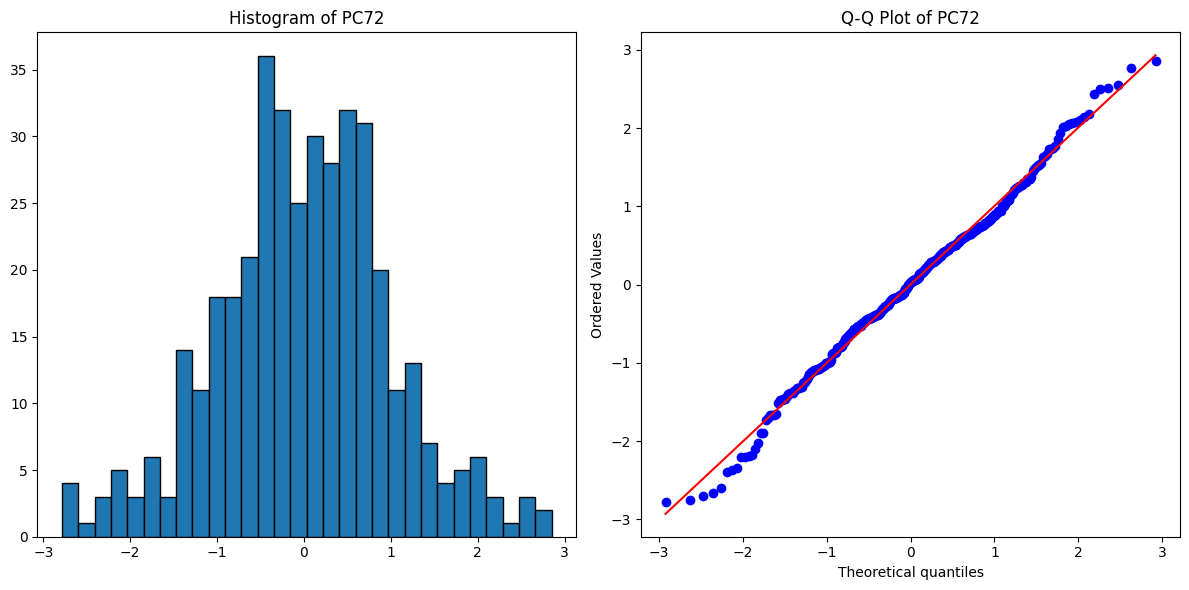

Shapiro-Wilk Test for PC72:
Statistic: 0.9940, p-value: 0.1168
PC72: Sample looks Gaussian (fail to reject H0)


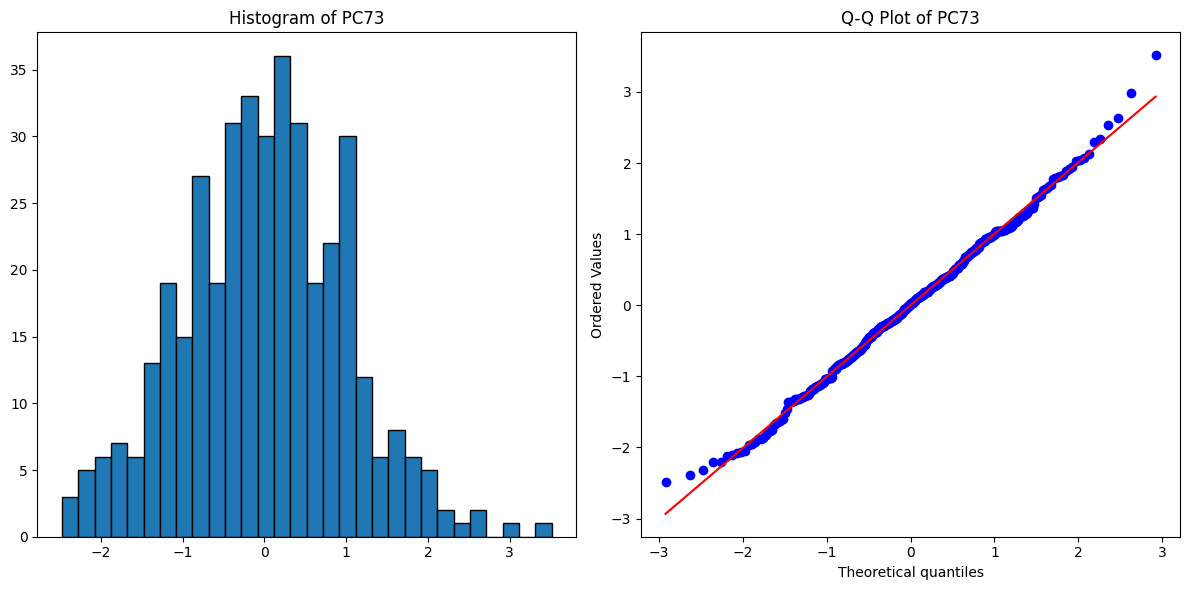

Shapiro-Wilk Test for PC73:
Statistic: 0.9964, p-value: 0.5222
PC73: Sample looks Gaussian (fail to reject H0)


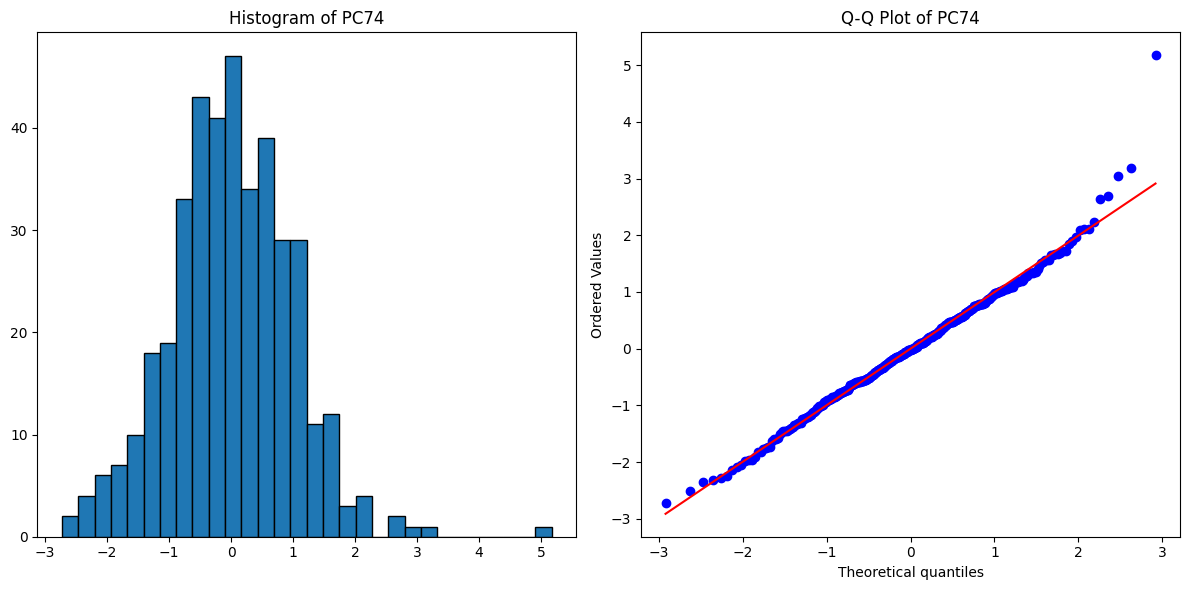

Shapiro-Wilk Test for PC74:
Statistic: 0.9850, p-value: 0.0004
PC74: Sample does not look Gaussian (reject H0)


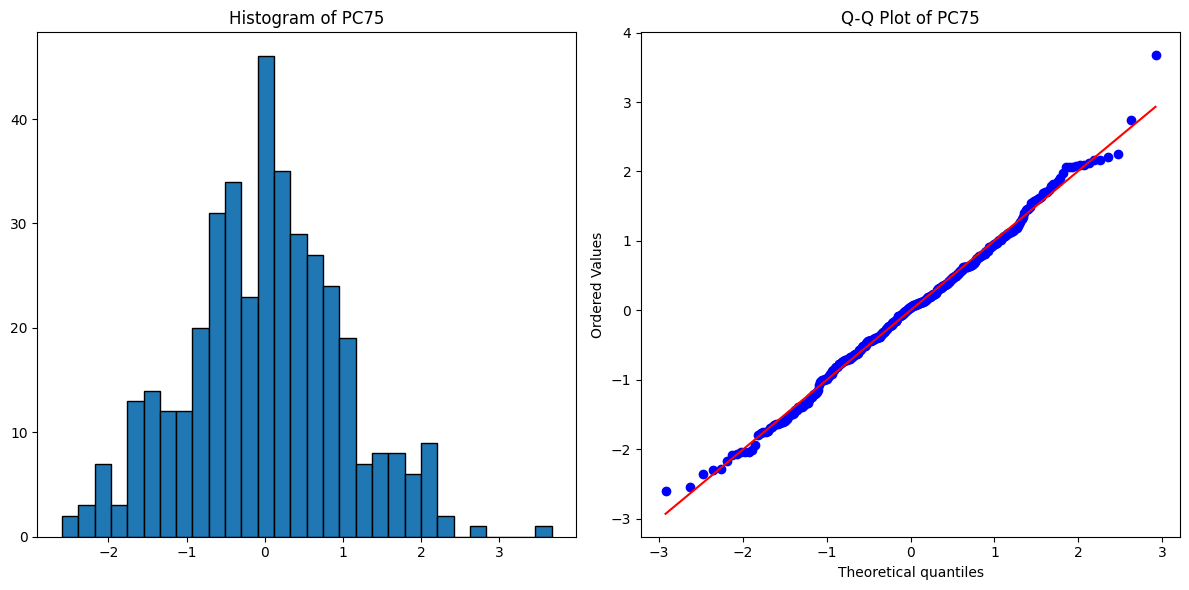

Shapiro-Wilk Test for PC75:
Statistic: 0.9954, p-value: 0.2970
PC75: Sample looks Gaussian (fail to reject H0)


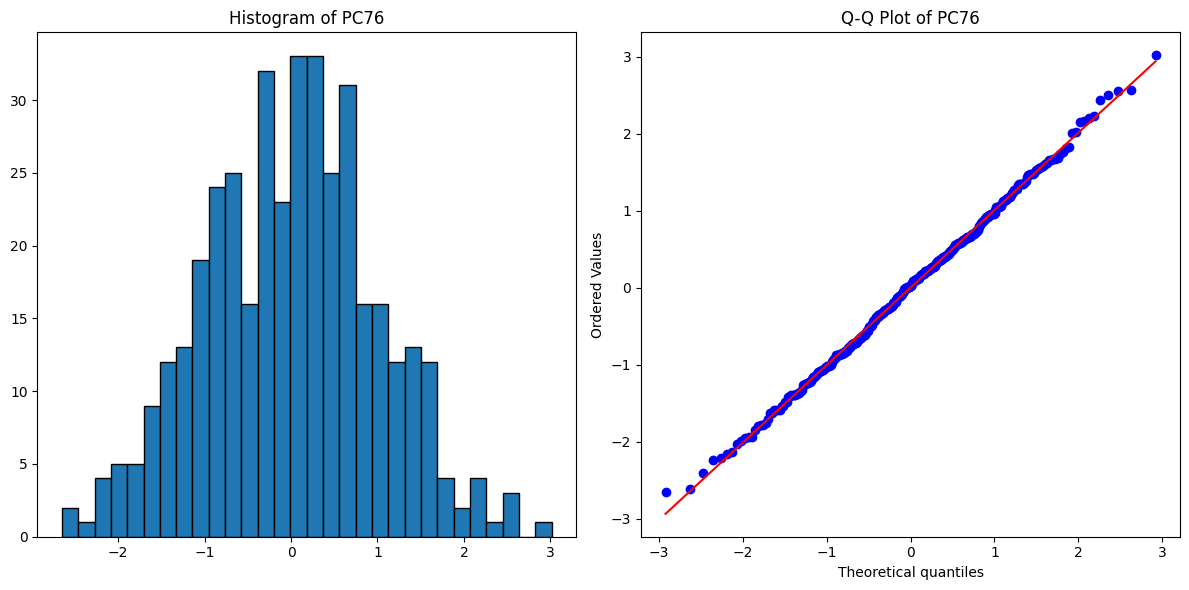

Shapiro-Wilk Test for PC76:
Statistic: 0.9981, p-value: 0.9399
PC76: Sample looks Gaussian (fail to reject H0)


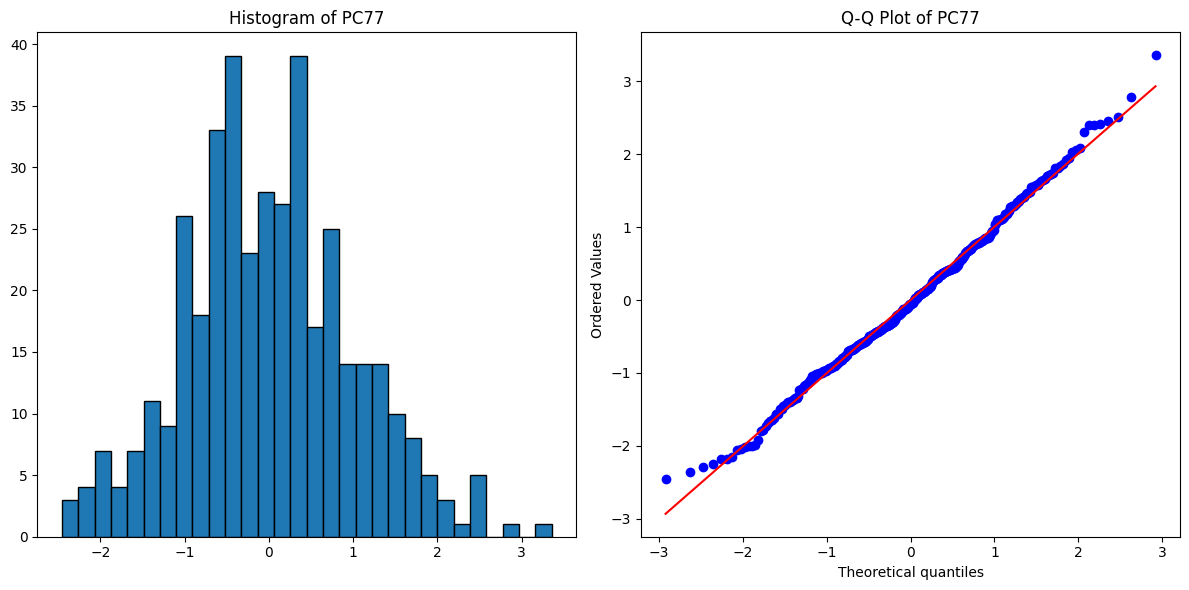

Shapiro-Wilk Test for PC77:
Statistic: 0.9951, p-value: 0.2381
PC77: Sample looks Gaussian (fail to reject H0)


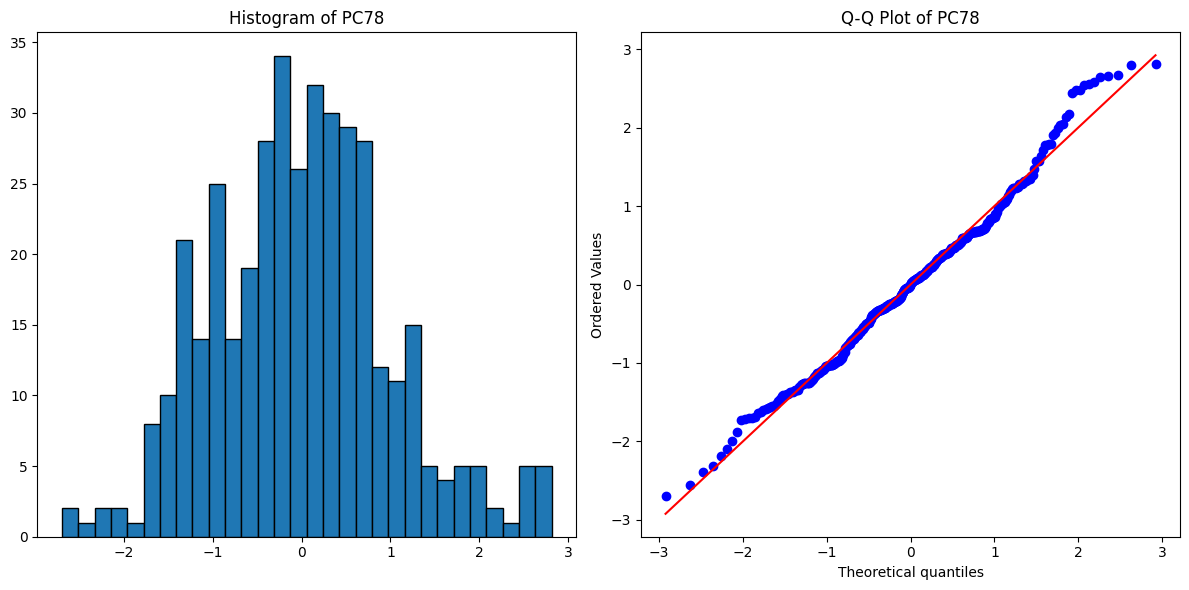

Shapiro-Wilk Test for PC78:
Statistic: 0.9896, p-value: 0.0066
PC78: Sample does not look Gaussian (reject H0)


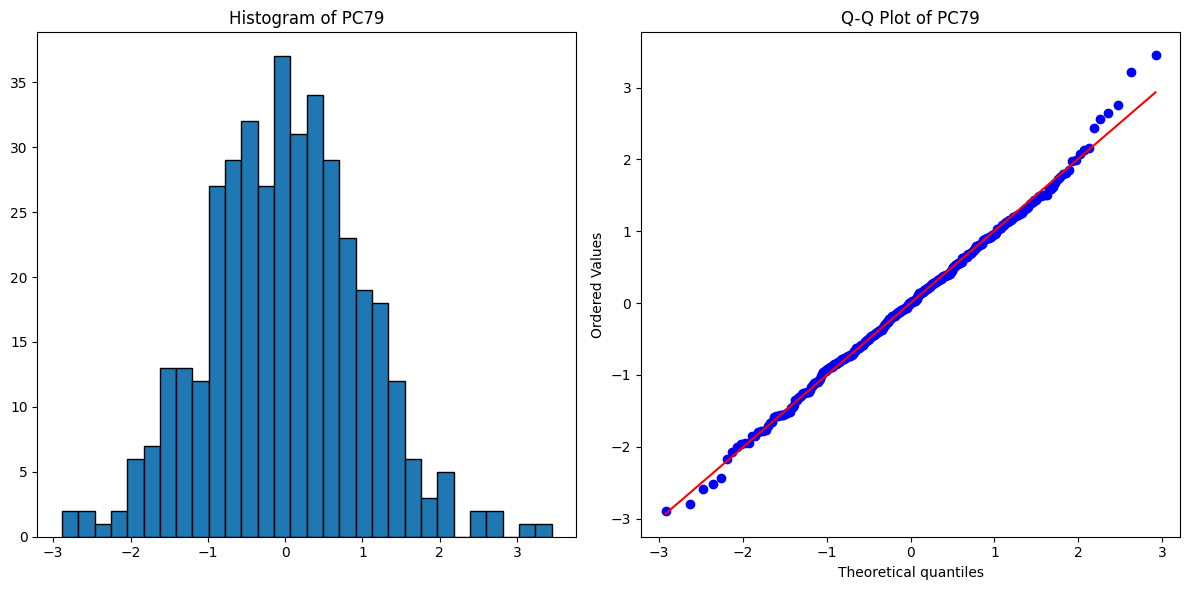

Shapiro-Wilk Test for PC79:
Statistic: 0.9970, p-value: 0.6759
PC79: Sample looks Gaussian (fail to reject H0)


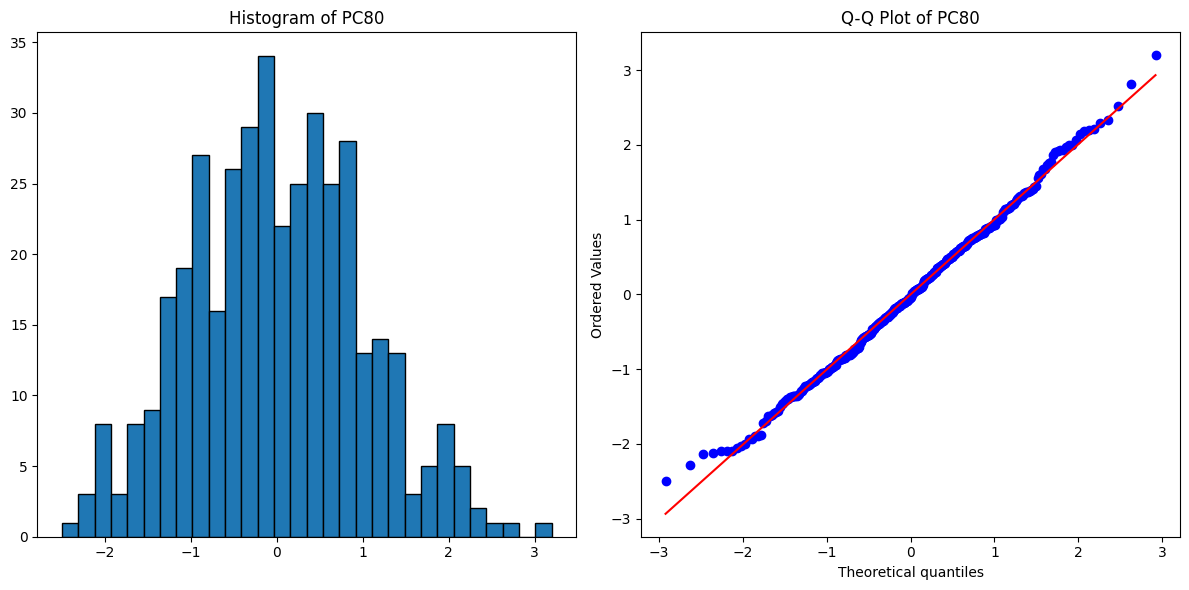

Shapiro-Wilk Test for PC80:
Statistic: 0.9962, p-value: 0.4698
PC80: Sample looks Gaussian (fail to reject H0)


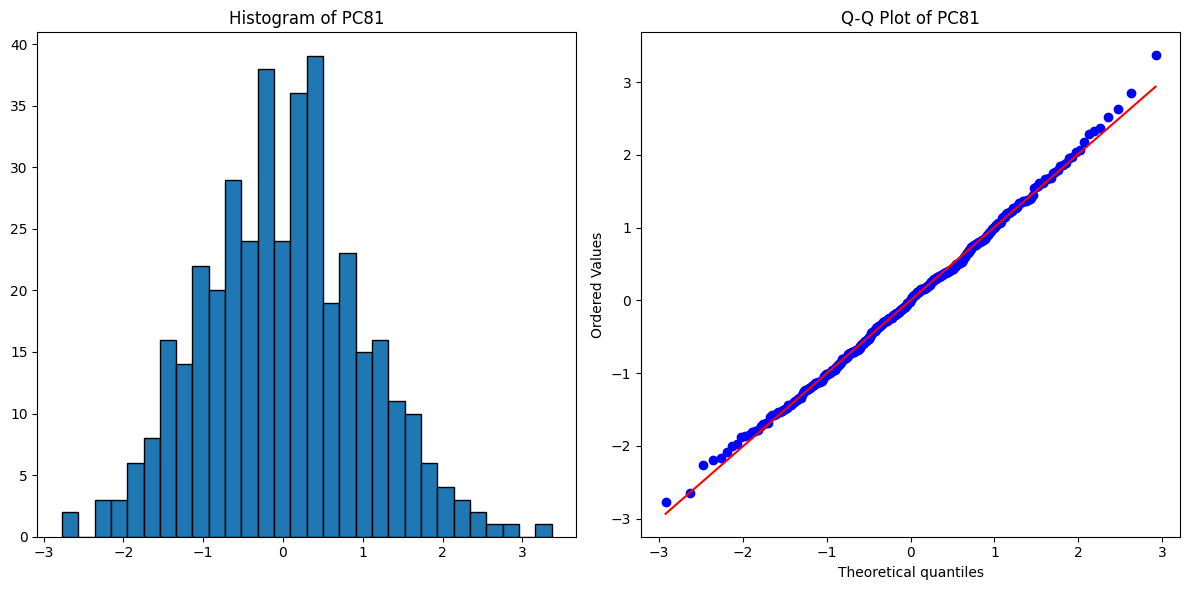

Shapiro-Wilk Test for PC81:
Statistic: 0.9978, p-value: 0.8949
PC81: Sample looks Gaussian (fail to reject H0)


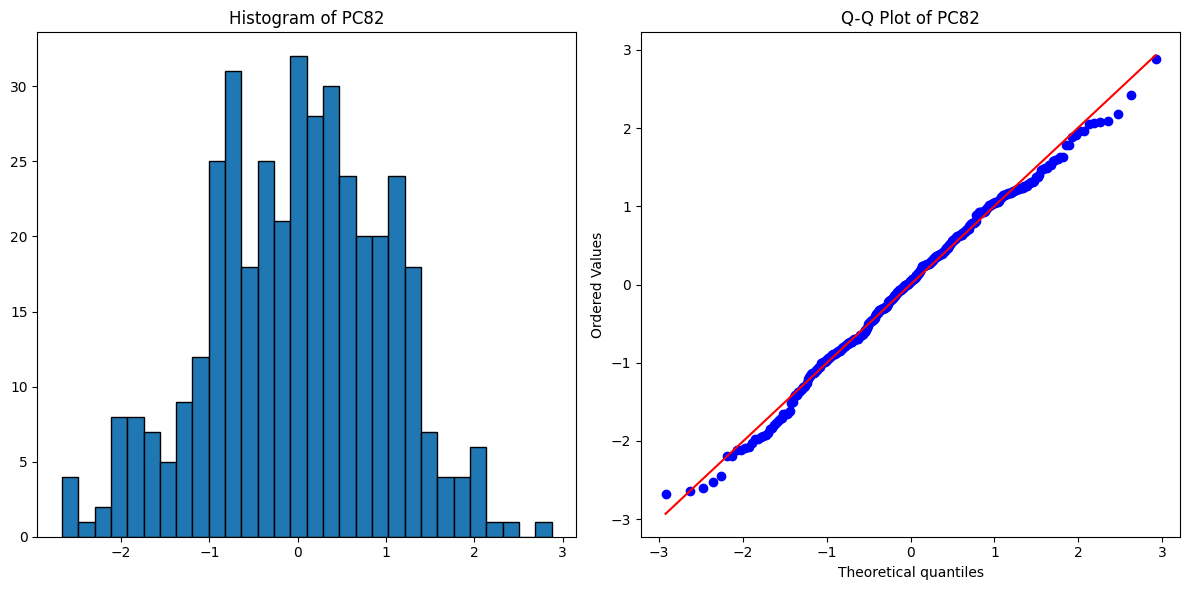

Shapiro-Wilk Test for PC82:
Statistic: 0.9939, p-value: 0.1158
PC82: Sample looks Gaussian (fail to reject H0)


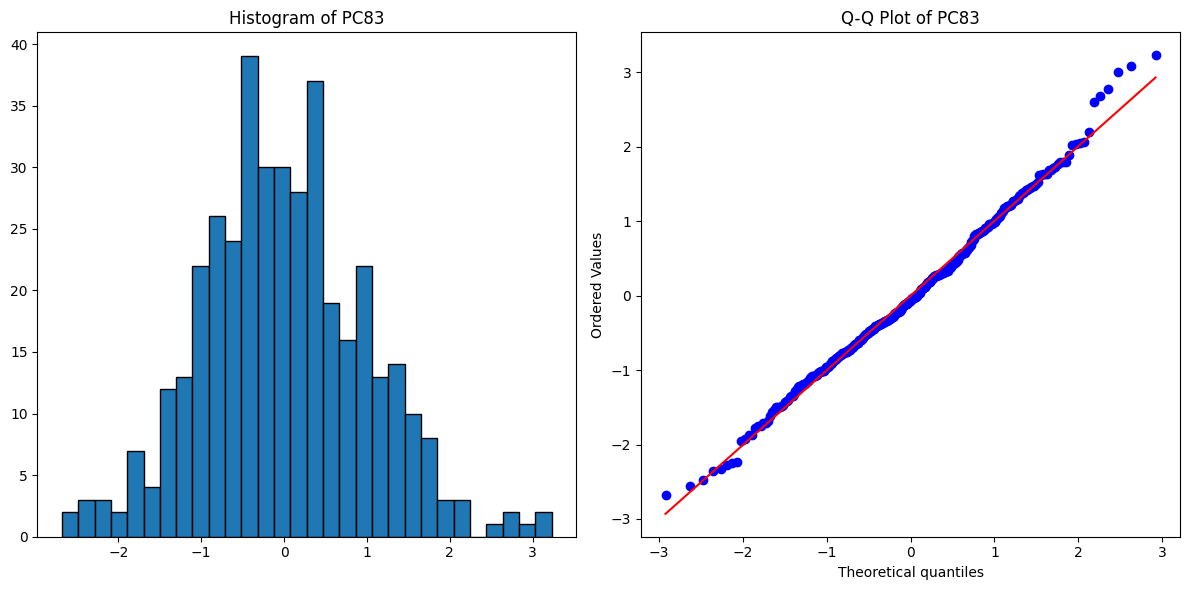

Shapiro-Wilk Test for PC83:
Statistic: 0.9943, p-value: 0.1430
PC83: Sample looks Gaussian (fail to reject H0)


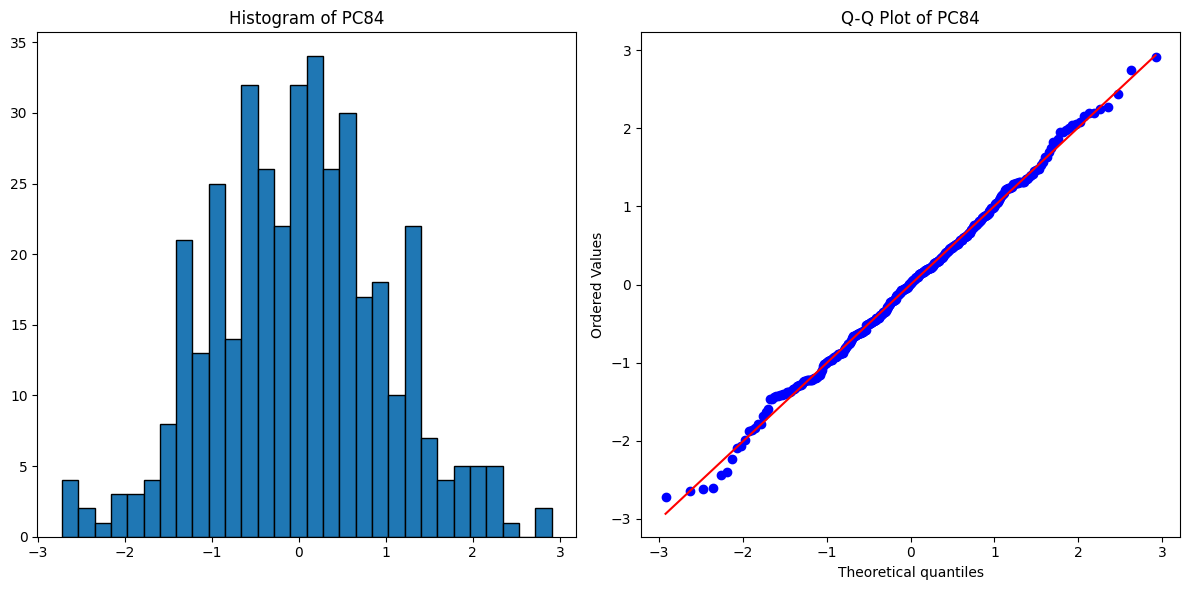

Shapiro-Wilk Test for PC84:
Statistic: 0.9970, p-value: 0.6780
PC84: Sample looks Gaussian (fail to reject H0)


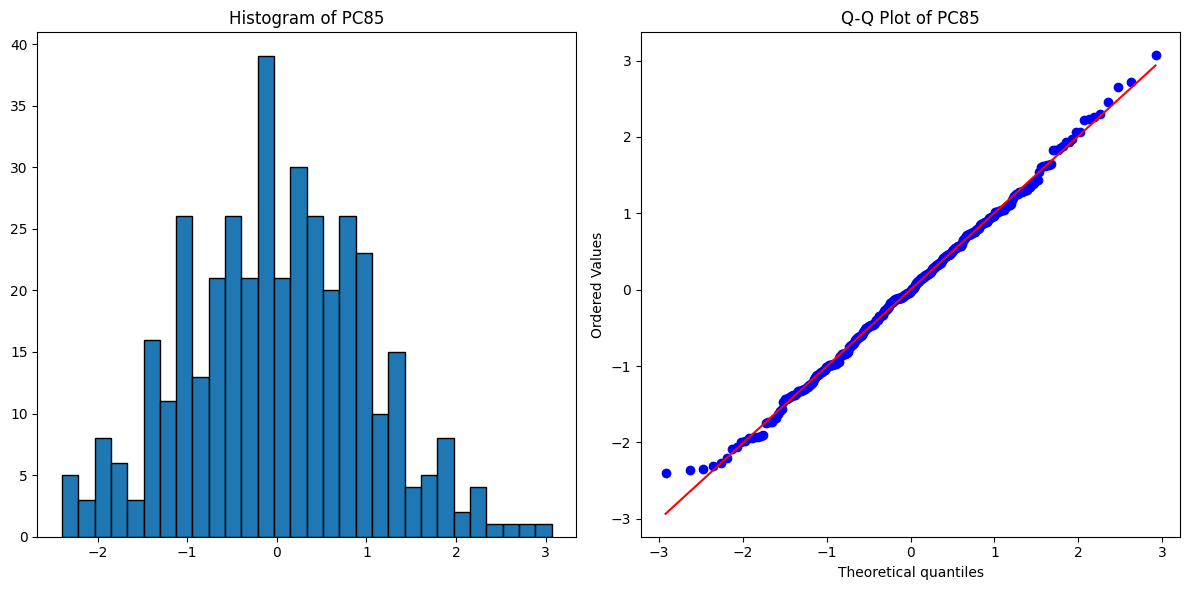

Shapiro-Wilk Test for PC85:
Statistic: 0.9967, p-value: 0.6026
PC85: Sample looks Gaussian (fail to reject H0)


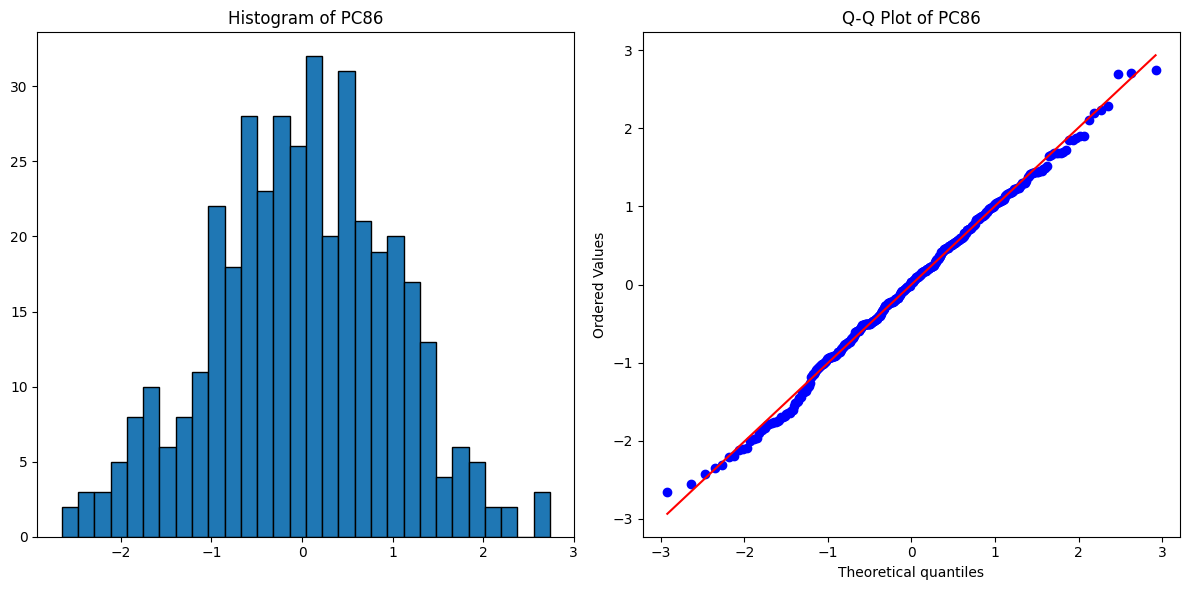

Shapiro-Wilk Test for PC86:
Statistic: 0.9962, p-value: 0.4689
PC86: Sample looks Gaussian (fail to reject H0)


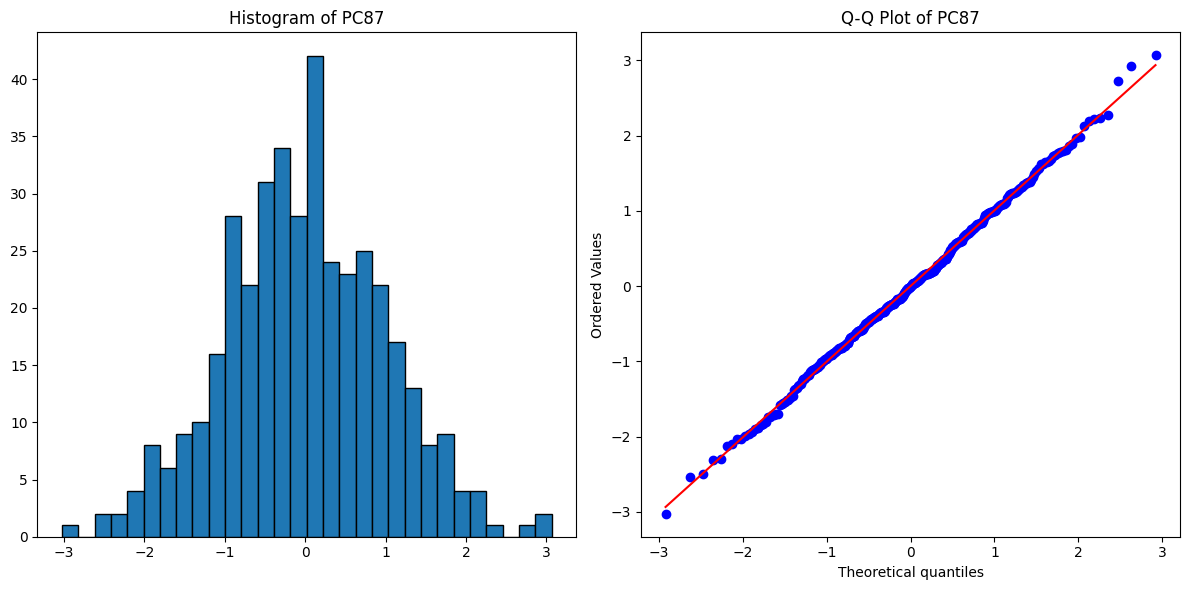

Shapiro-Wilk Test for PC87:
Statistic: 0.9985, p-value: 0.9854
PC87: Sample looks Gaussian (fail to reject H0)


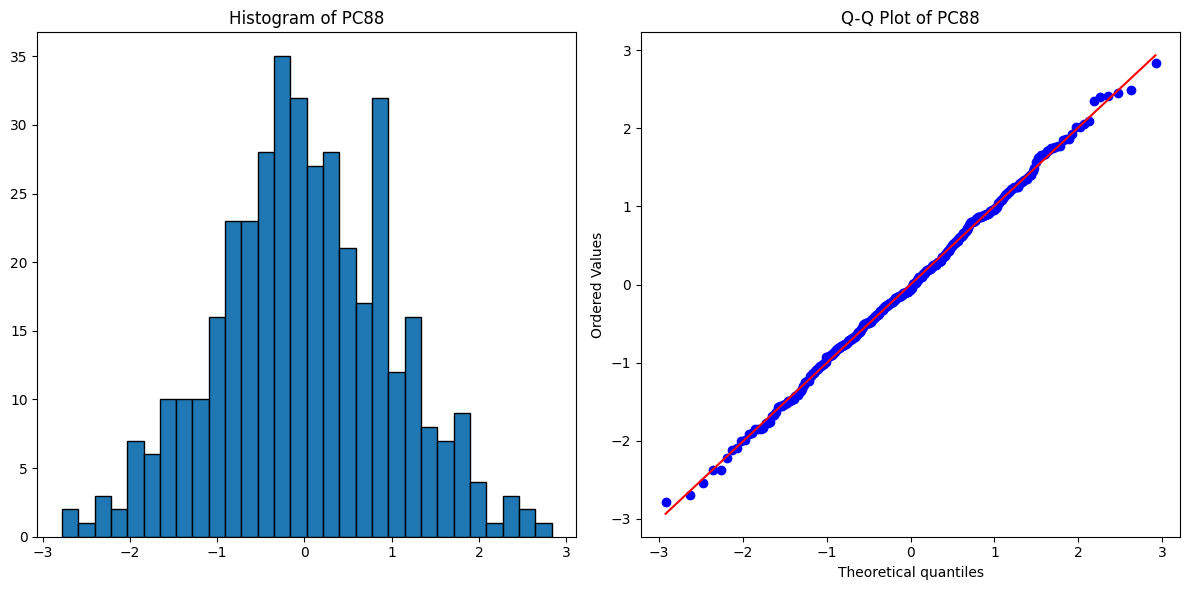

Shapiro-Wilk Test for PC88:
Statistic: 0.9980, p-value: 0.9174
PC88: Sample looks Gaussian (fail to reject H0)


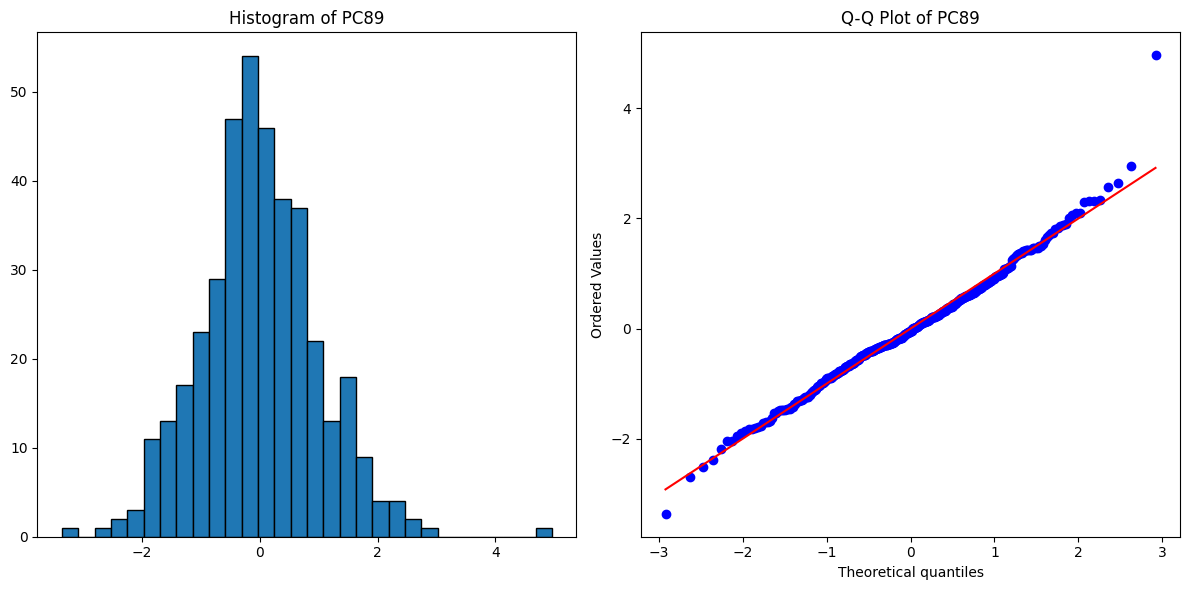

Shapiro-Wilk Test for PC89:
Statistic: 0.9873, p-value: 0.0015
PC89: Sample does not look Gaussian (reject H0)


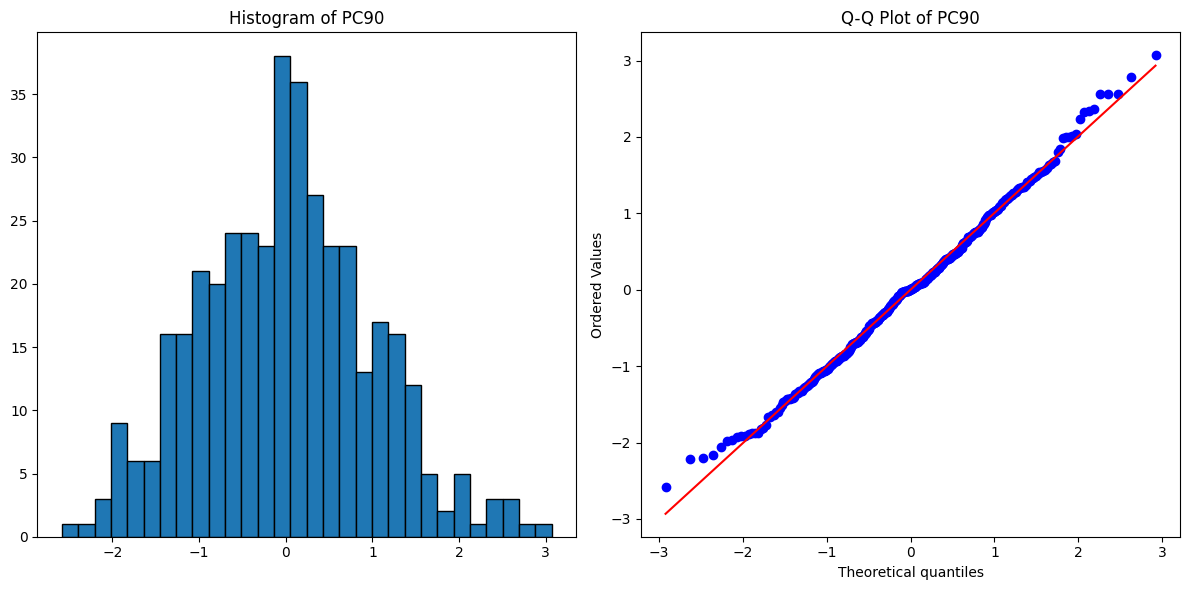

Shapiro-Wilk Test for PC90:
Statistic: 0.9957, p-value: 0.3443
PC90: Sample looks Gaussian (fail to reject H0)


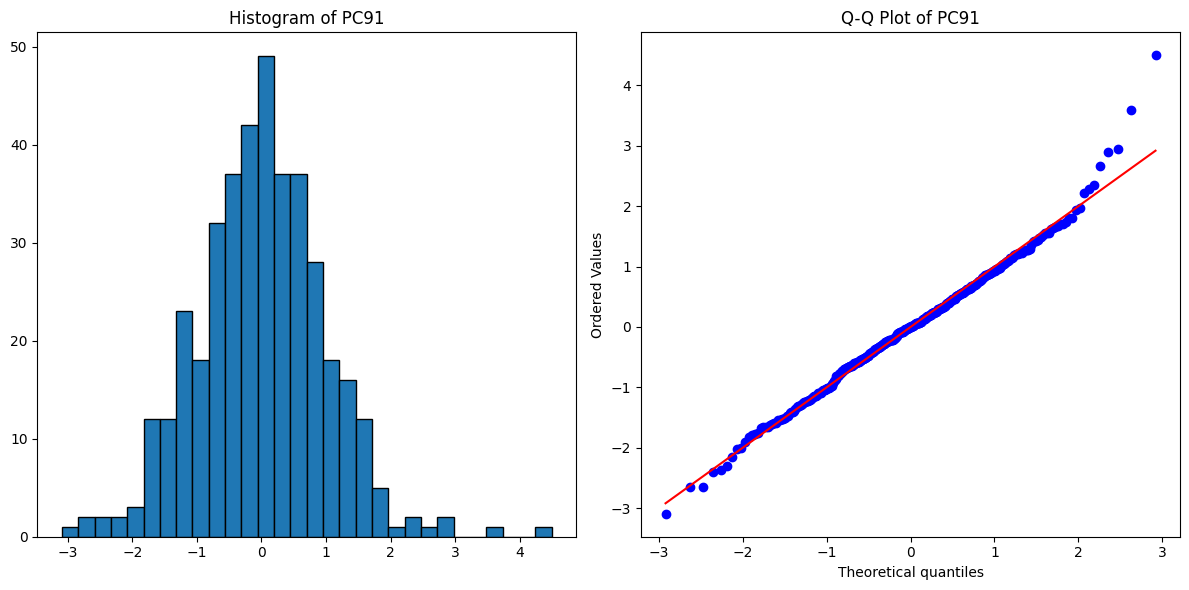

Shapiro-Wilk Test for PC91:
Statistic: 0.9890, p-value: 0.0044
PC91: Sample does not look Gaussian (reject H0)


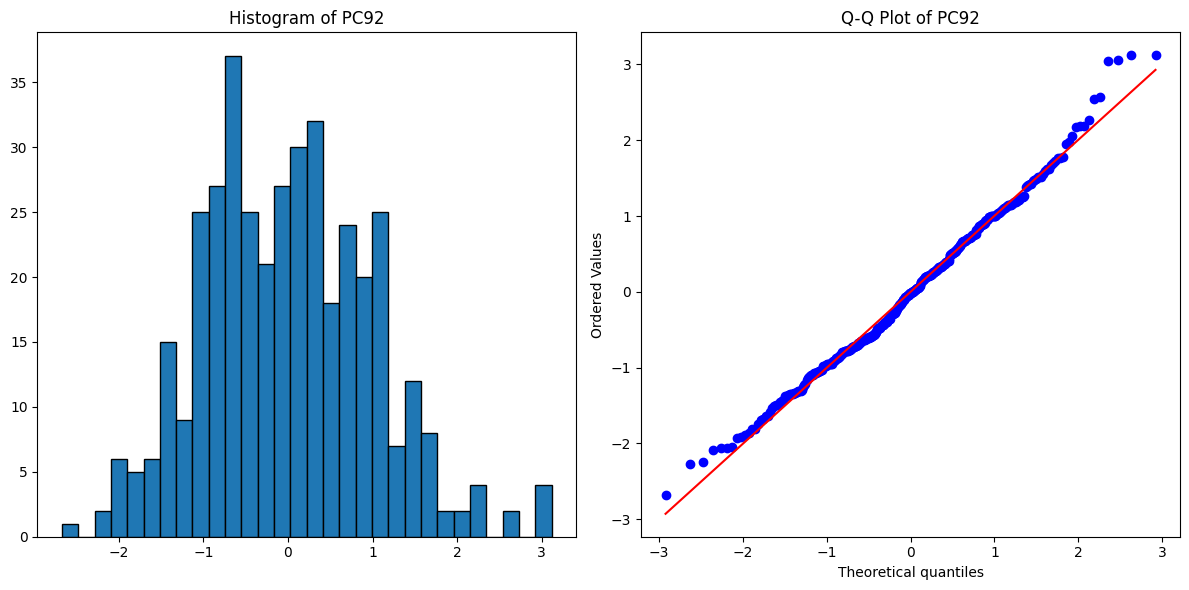

Shapiro-Wilk Test for PC92:
Statistic: 0.9921, p-value: 0.0341
PC92: Sample does not look Gaussian (reject H0)


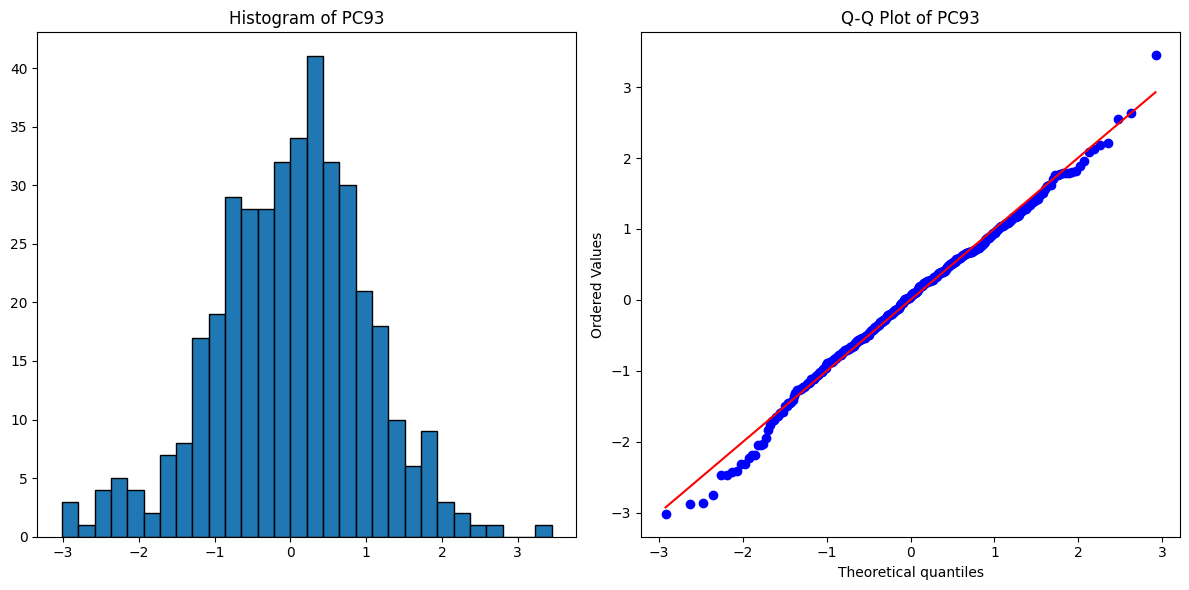

Shapiro-Wilk Test for PC93:
Statistic: 0.9935, p-value: 0.0843
PC93: Sample looks Gaussian (fail to reject H0)


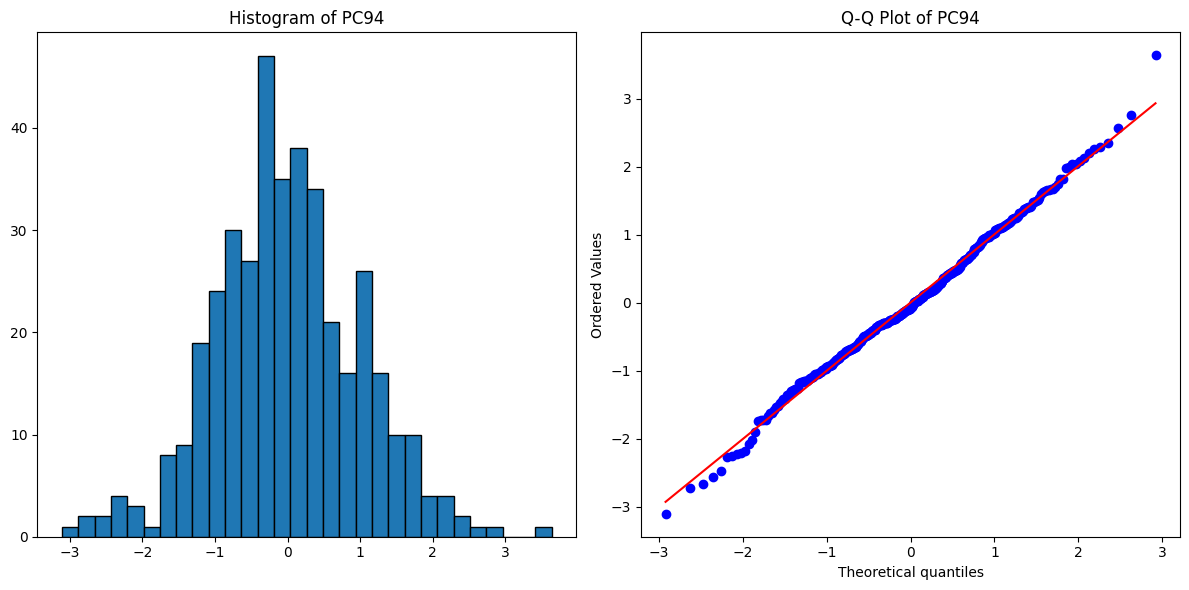

Shapiro-Wilk Test for PC94:
Statistic: 0.9960, p-value: 0.4062
PC94: Sample looks Gaussian (fail to reject H0)


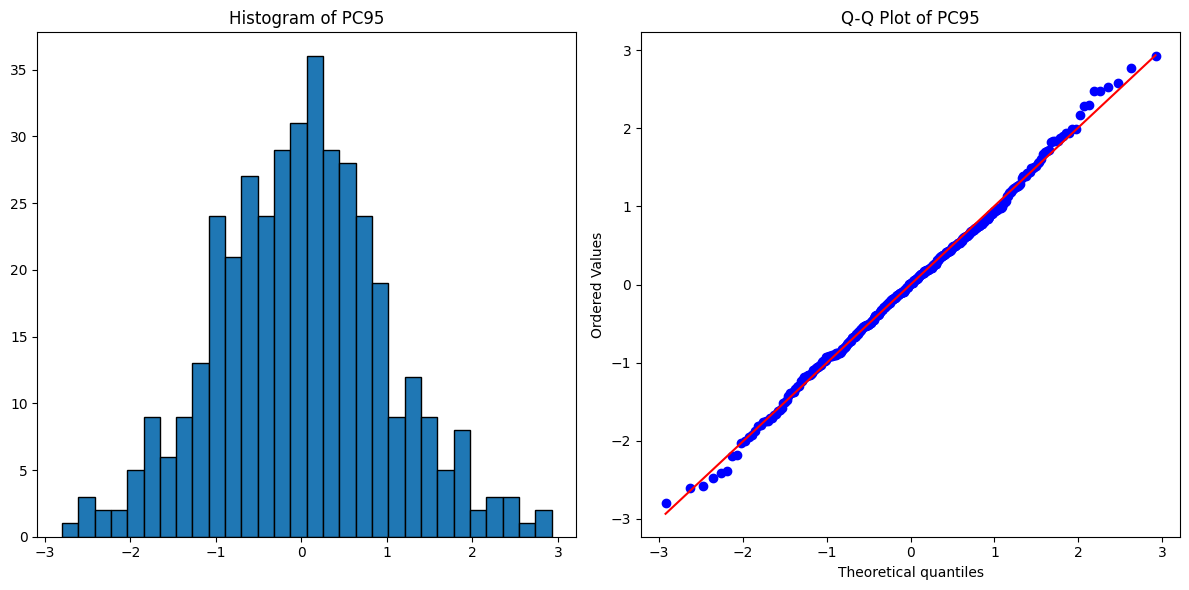

Shapiro-Wilk Test for PC95:
Statistic: 0.9971, p-value: 0.7010
PC95: Sample looks Gaussian (fail to reject H0)


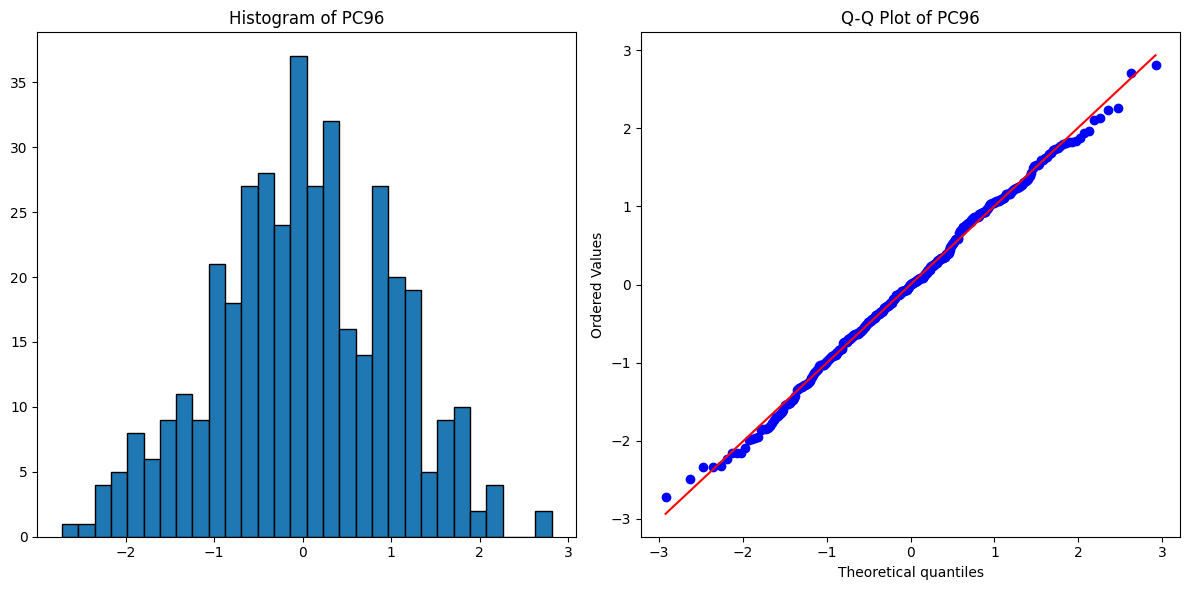

Shapiro-Wilk Test for PC96:
Statistic: 0.9965, p-value: 0.5572
PC96: Sample looks Gaussian (fail to reject H0)


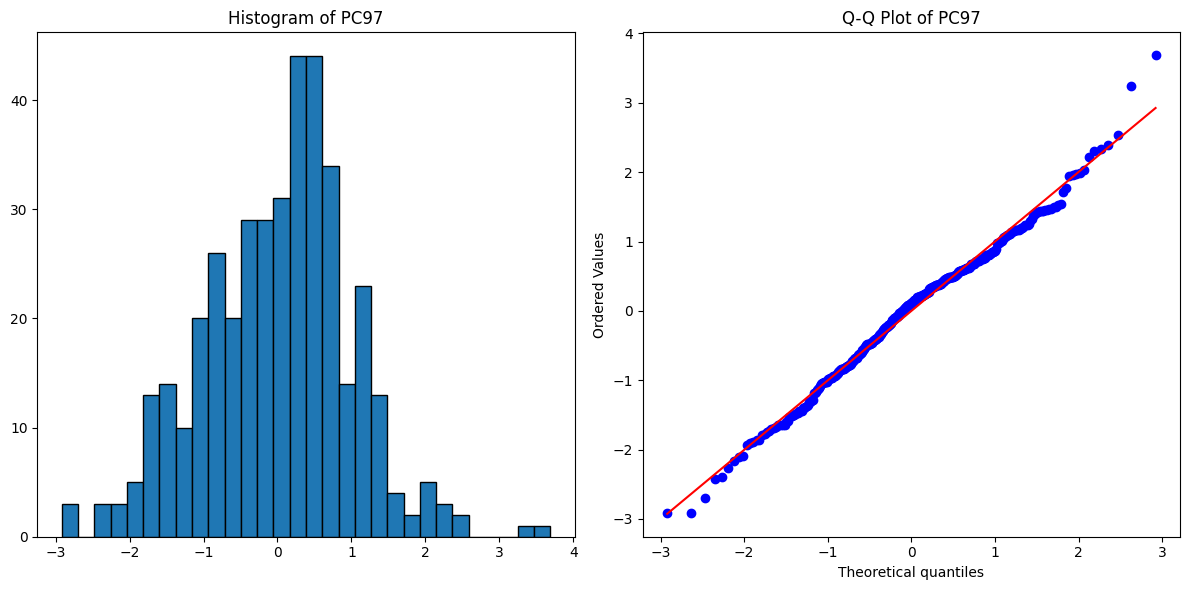

Shapiro-Wilk Test for PC97:
Statistic: 0.9919, p-value: 0.0293
PC97: Sample does not look Gaussian (reject H0)


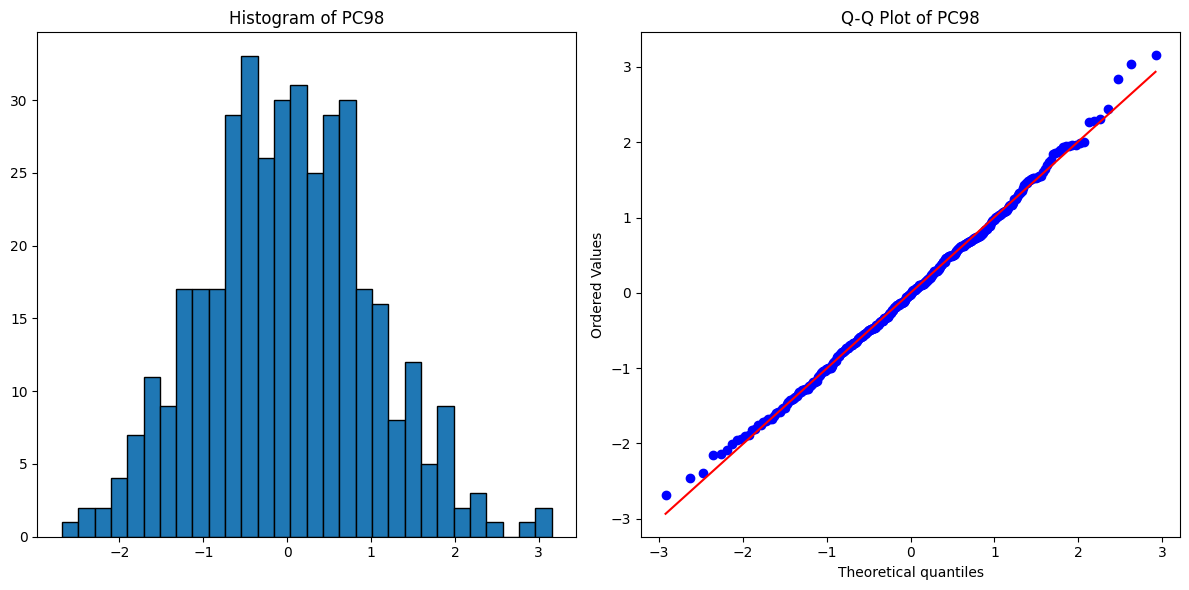

Shapiro-Wilk Test for PC98:
Statistic: 0.9972, p-value: 0.7386
PC98: Sample looks Gaussian (fail to reject H0)


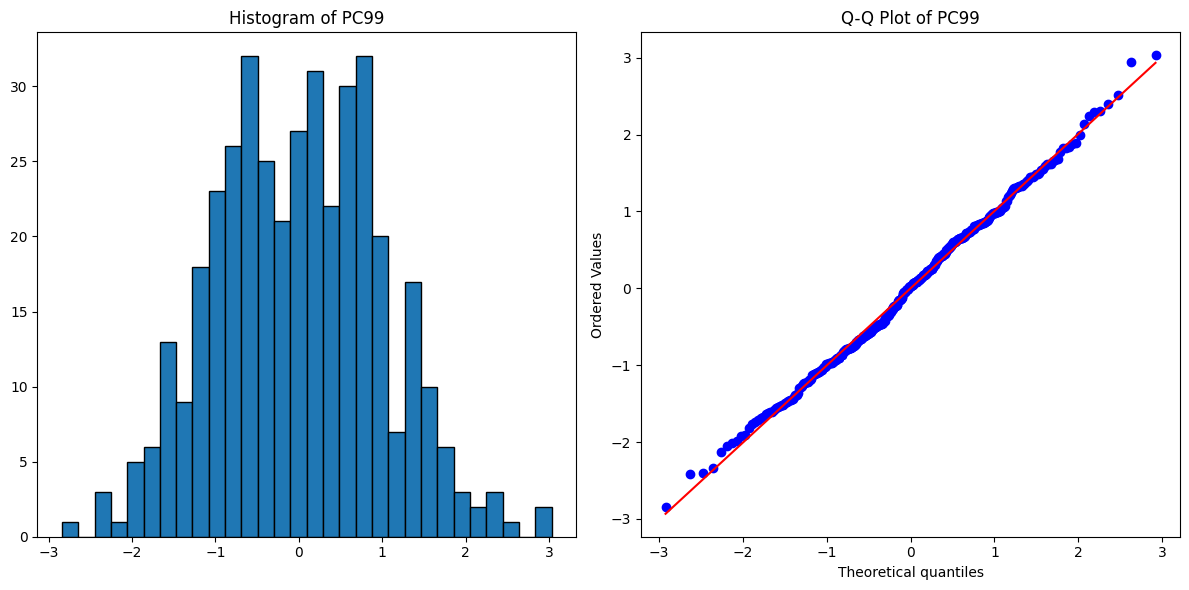

Shapiro-Wilk Test for PC99:
Statistic: 0.9966, p-value: 0.5603
PC99: Sample looks Gaussian (fail to reject H0)


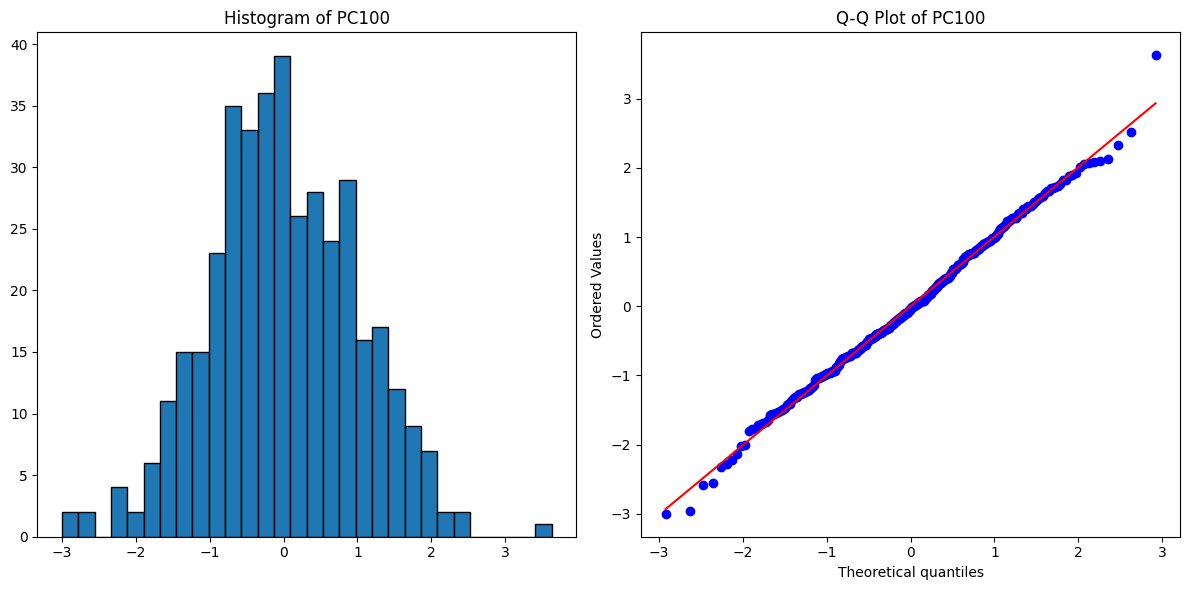

Shapiro-Wilk Test for PC100:
Statistic: 0.9972, p-value: 0.7465
PC100: Sample looks Gaussian (fail to reject H0)


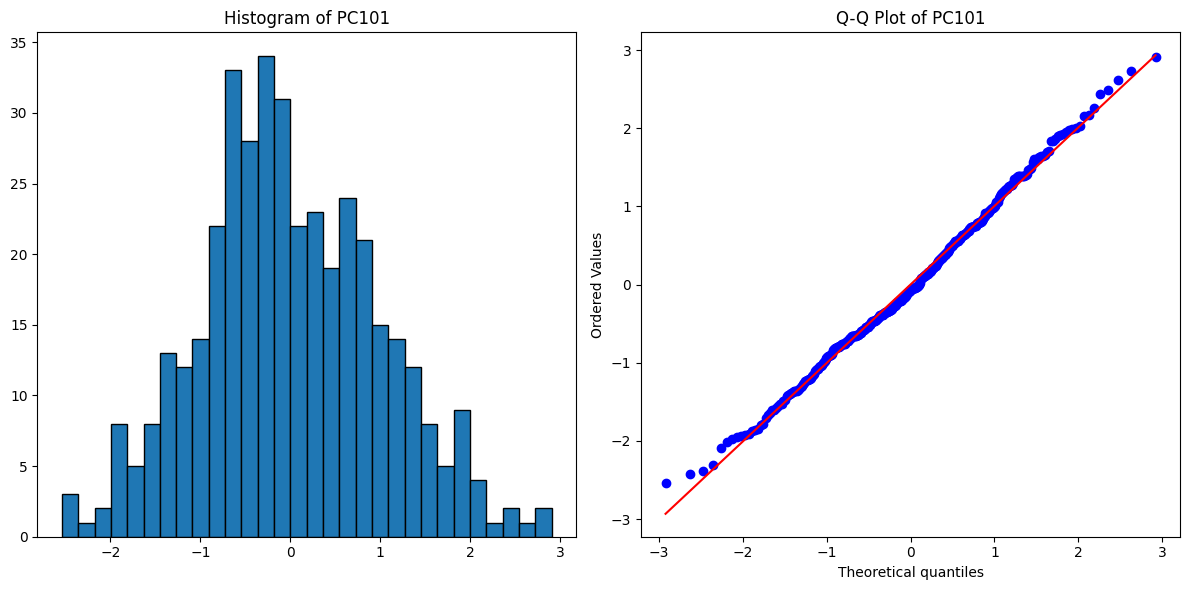

Shapiro-Wilk Test for PC101:
Statistic: 0.9953, p-value: 0.2735
PC101: Sample looks Gaussian (fail to reject H0)


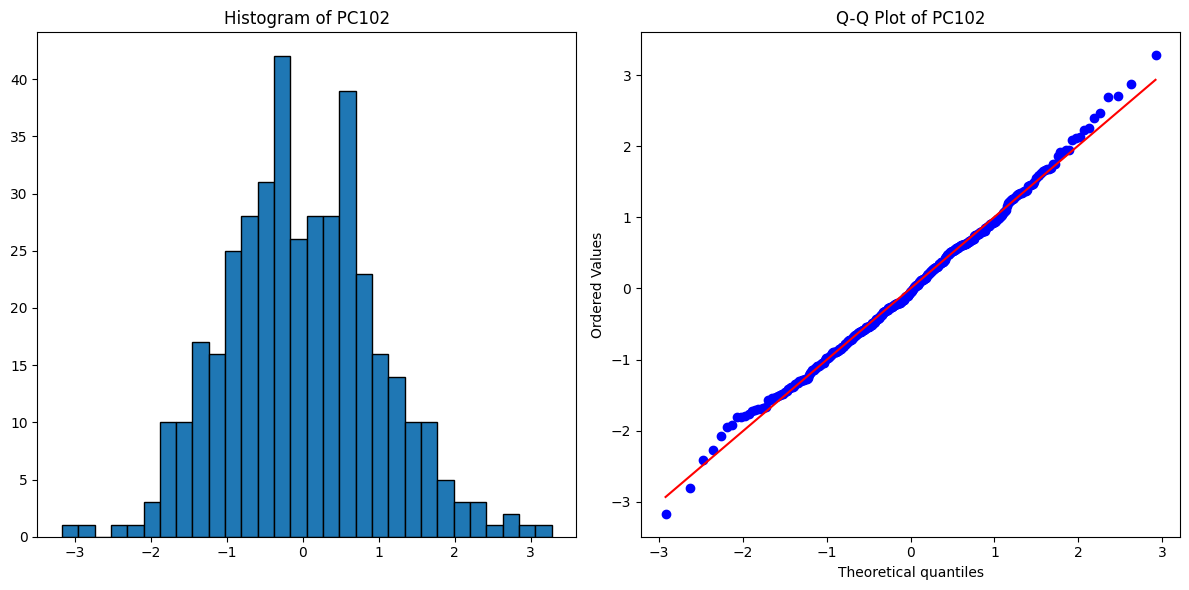

Shapiro-Wilk Test for PC102:
Statistic: 0.9966, p-value: 0.5695
PC102: Sample looks Gaussian (fail to reject H0)


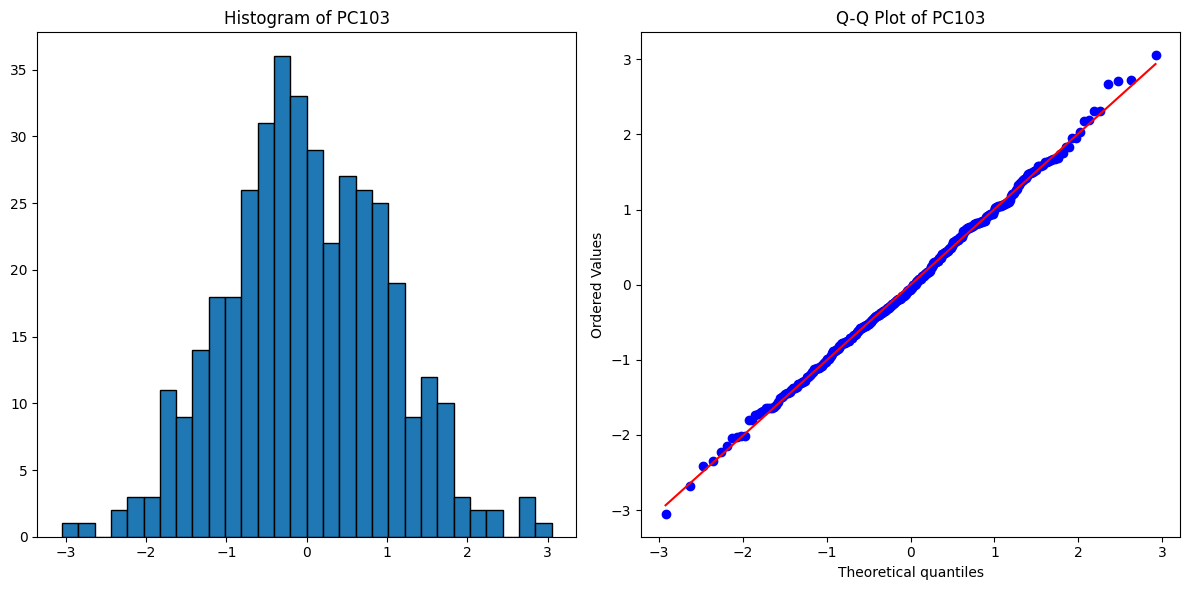

Shapiro-Wilk Test for PC103:
Statistic: 0.9981, p-value: 0.9440
PC103: Sample looks Gaussian (fail to reject H0)


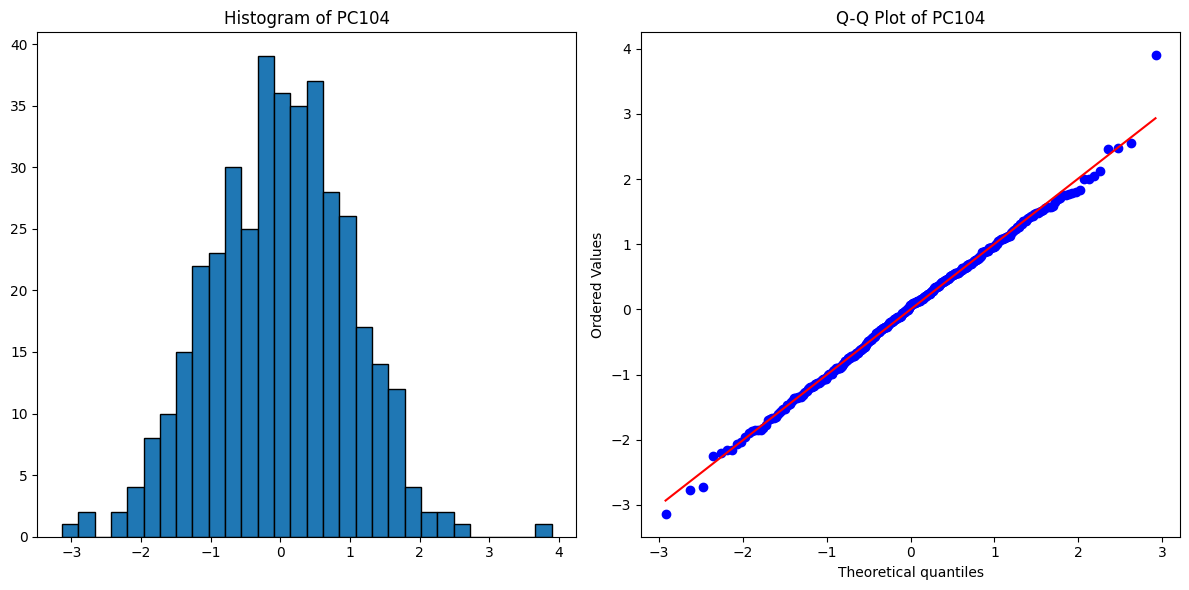

Shapiro-Wilk Test for PC104:
Statistic: 0.9970, p-value: 0.6849
PC104: Sample looks Gaussian (fail to reject H0)


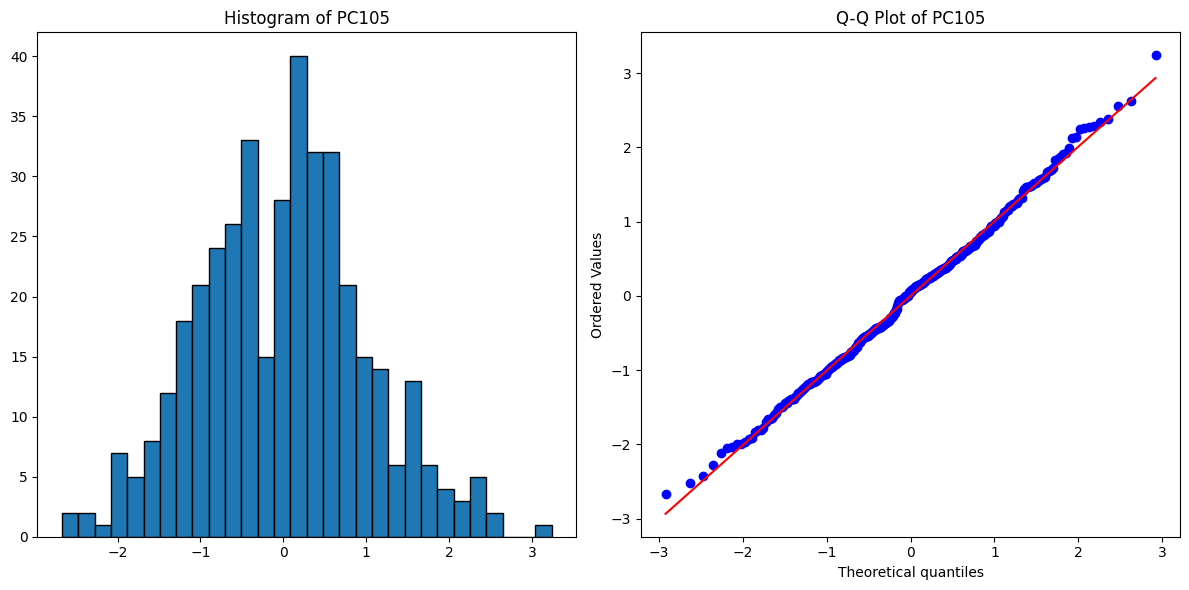

Shapiro-Wilk Test for PC105:
Statistic: 0.9970, p-value: 0.6749
PC105: Sample looks Gaussian (fail to reject H0)


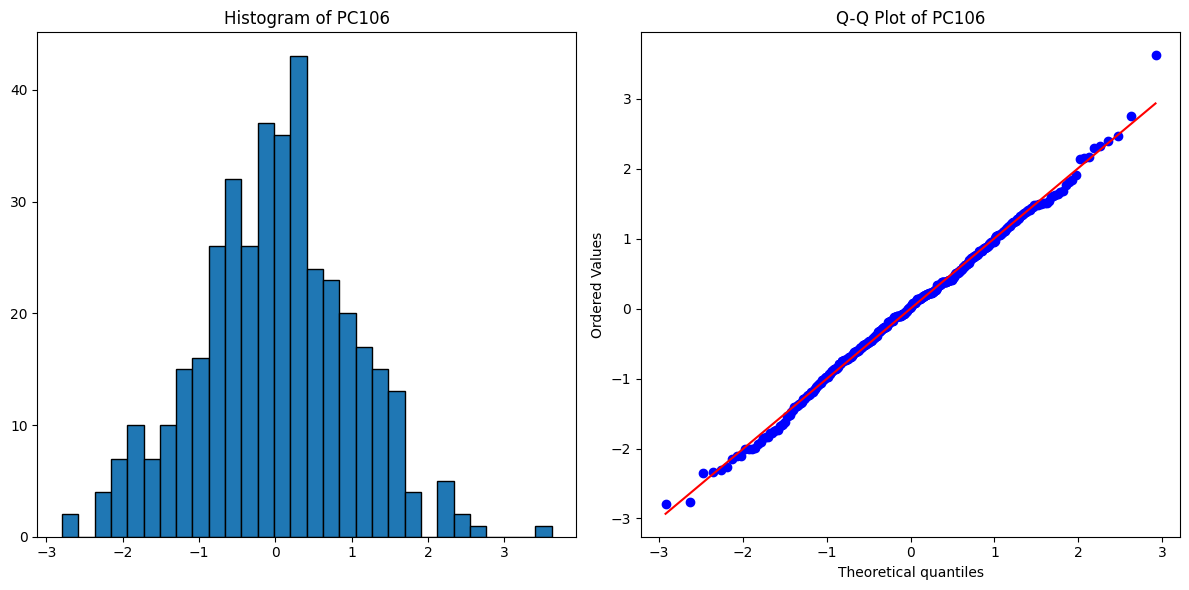

Shapiro-Wilk Test for PC106:
Statistic: 0.9969, p-value: 0.6633
PC106: Sample looks Gaussian (fail to reject H0)


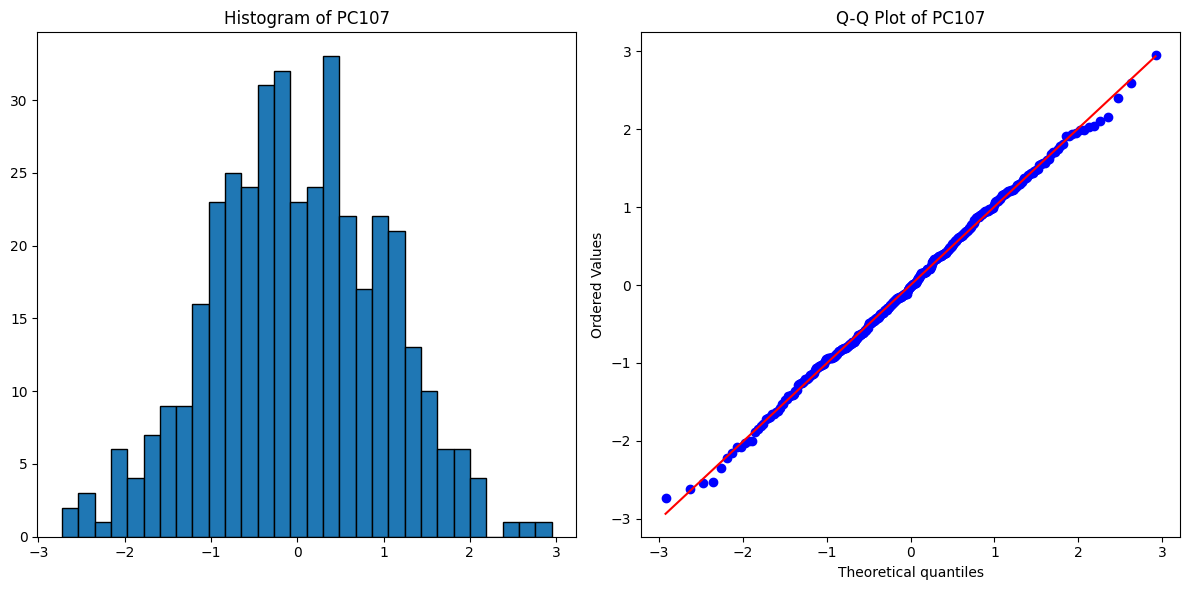

Shapiro-Wilk Test for PC107:
Statistic: 0.9979, p-value: 0.9164
PC107: Sample looks Gaussian (fail to reject H0)


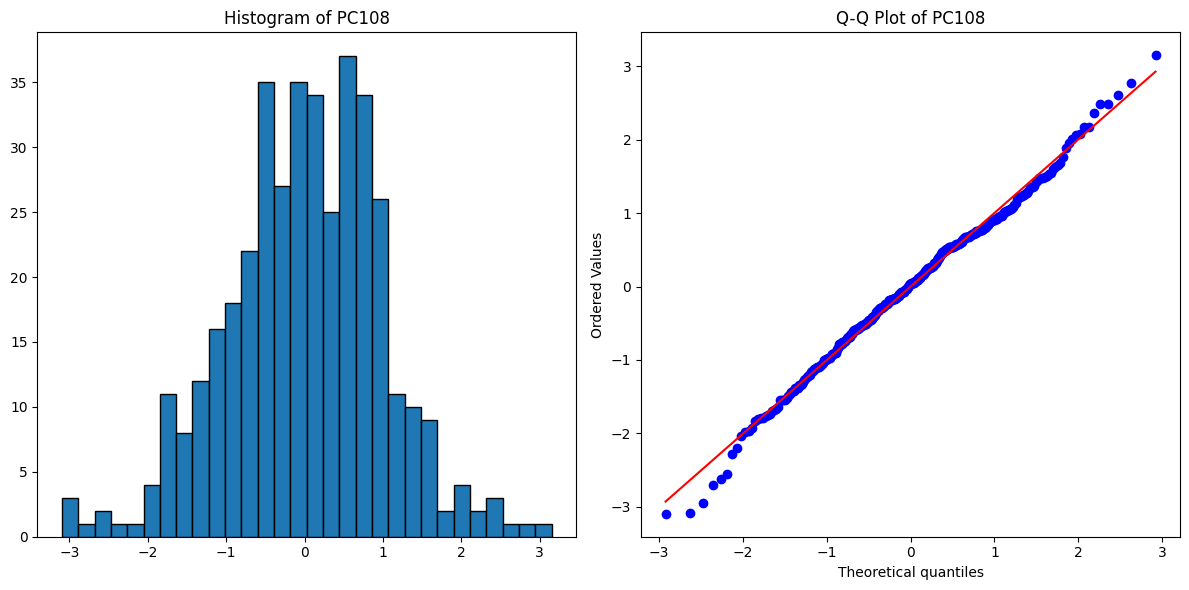

Shapiro-Wilk Test for PC108:
Statistic: 0.9947, p-value: 0.1854
PC108: Sample looks Gaussian (fail to reject H0)


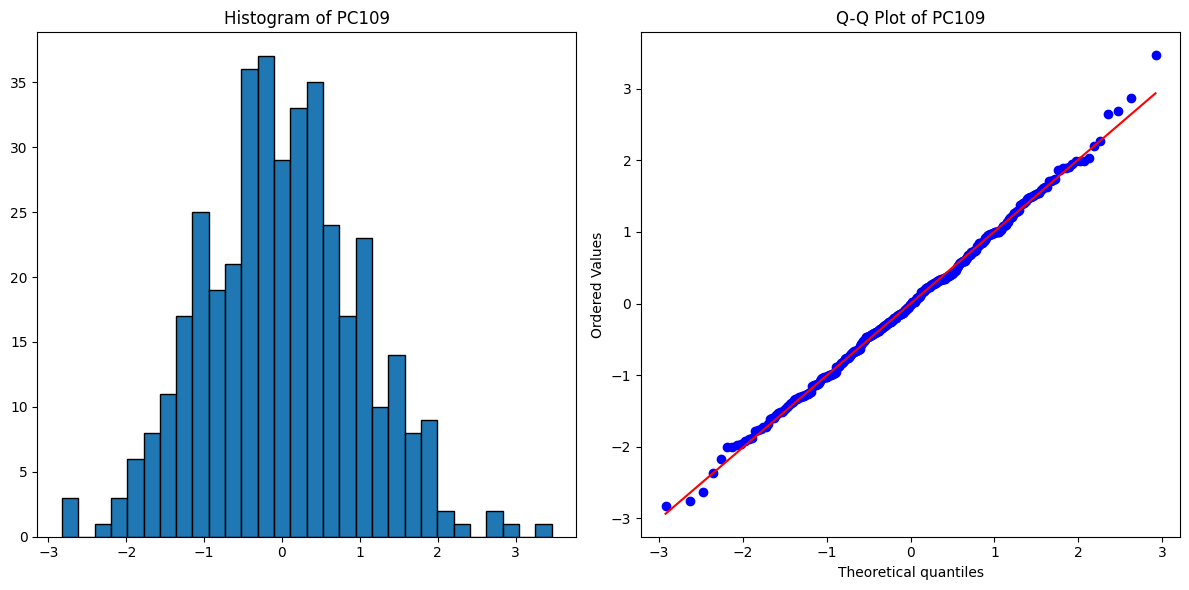

Shapiro-Wilk Test for PC109:
Statistic: 0.9978, p-value: 0.8862
PC109: Sample looks Gaussian (fail to reject H0)


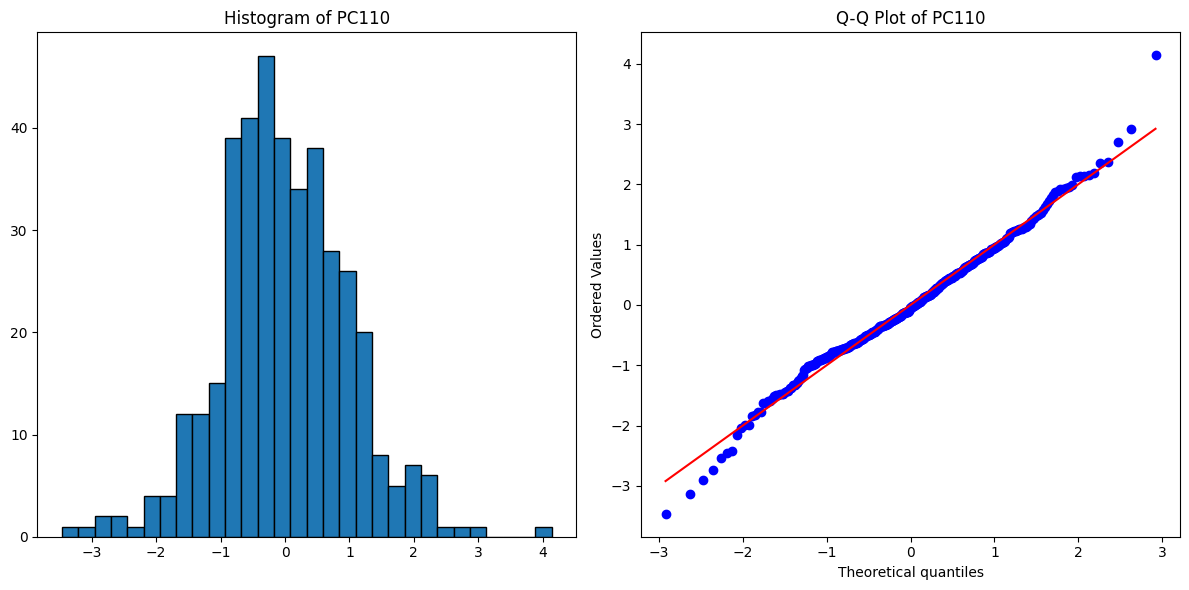

Shapiro-Wilk Test for PC110:
Statistic: 0.9905, p-value: 0.0120
PC110: Sample does not look Gaussian (reject H0)


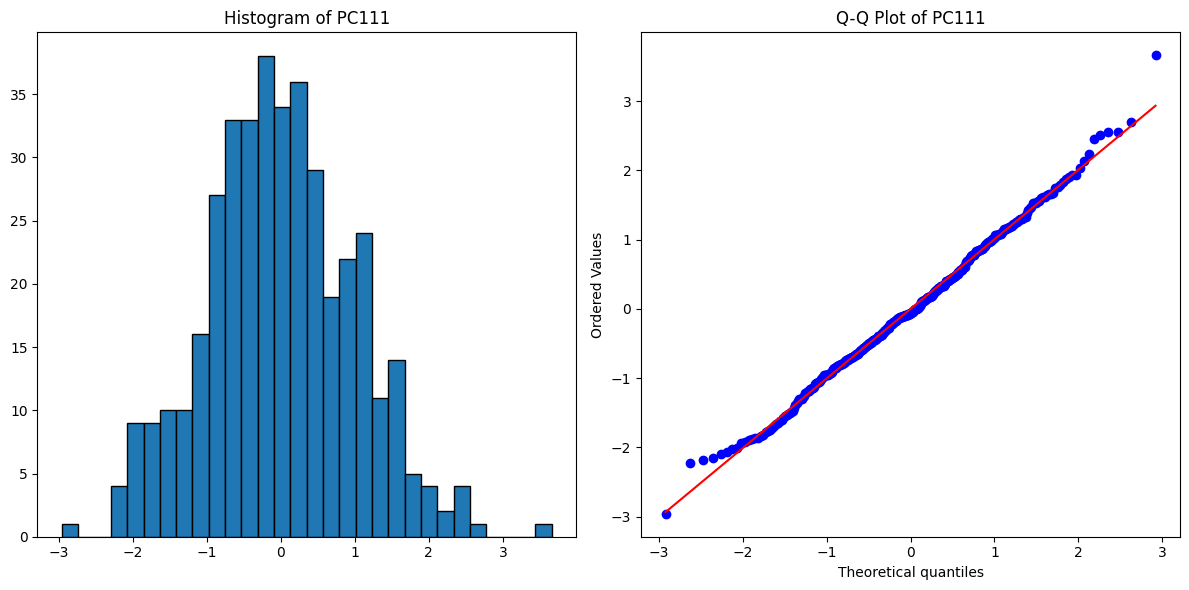

Shapiro-Wilk Test for PC111:
Statistic: 0.9965, p-value: 0.5458
PC111: Sample looks Gaussian (fail to reject H0)


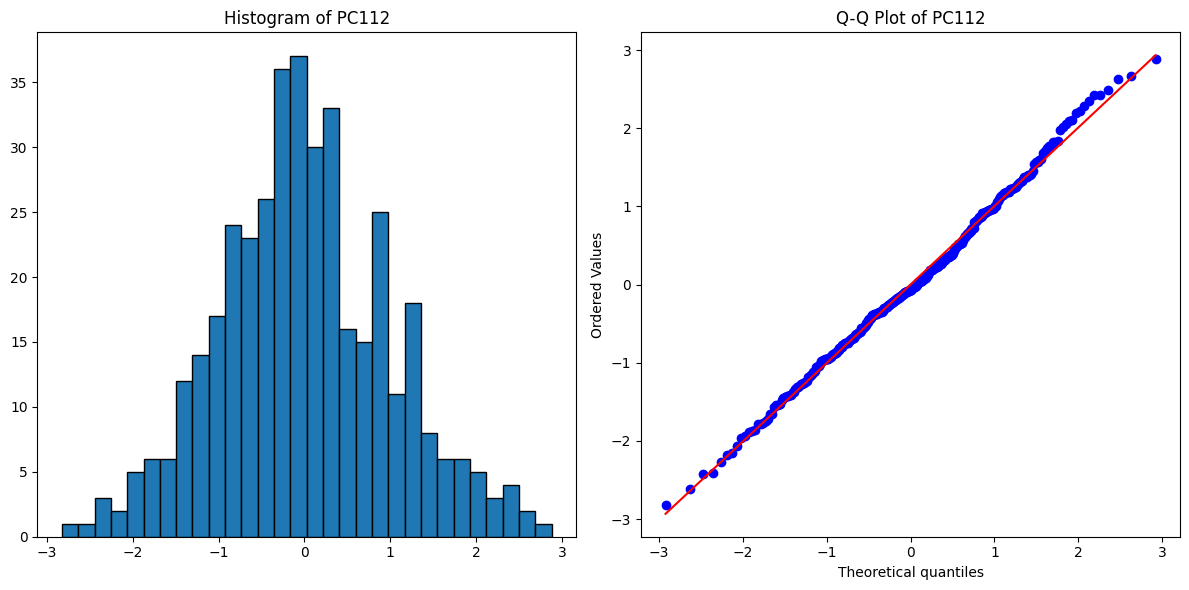

Shapiro-Wilk Test for PC112:
Statistic: 0.9957, p-value: 0.3529
PC112: Sample looks Gaussian (fail to reject H0)


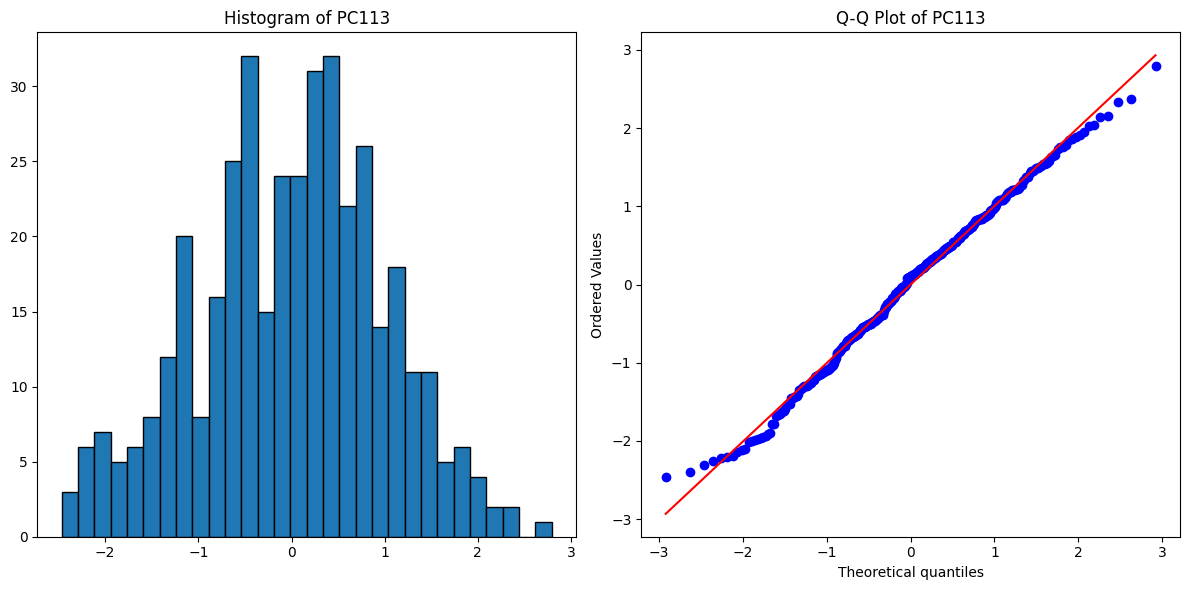

Shapiro-Wilk Test for PC113:
Statistic: 0.9943, p-value: 0.1428
PC113: Sample looks Gaussian (fail to reject H0)


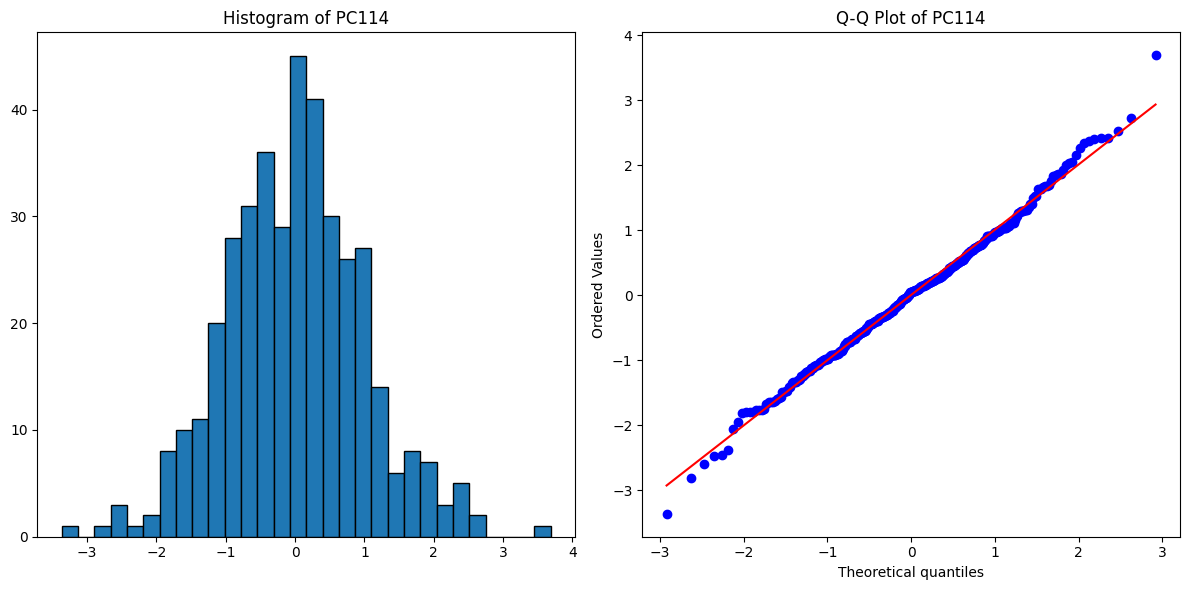

Shapiro-Wilk Test for PC114:
Statistic: 0.9958, p-value: 0.3763
PC114: Sample looks Gaussian (fail to reject H0)


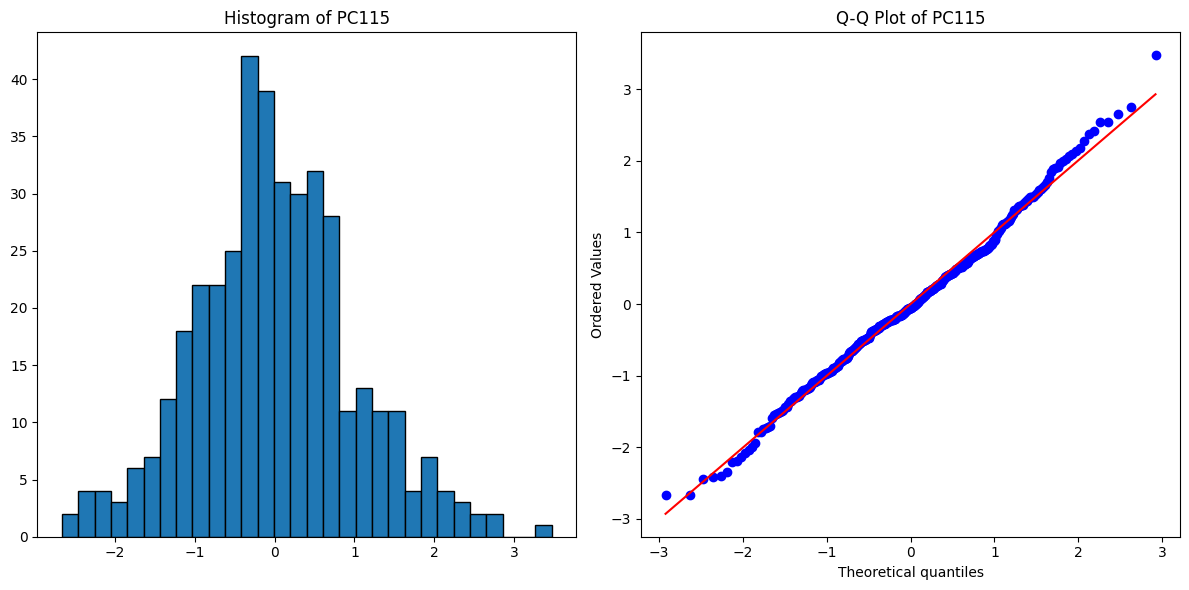

Shapiro-Wilk Test for PC115:
Statistic: 0.9940, p-value: 0.1182
PC115: Sample looks Gaussian (fail to reject H0)


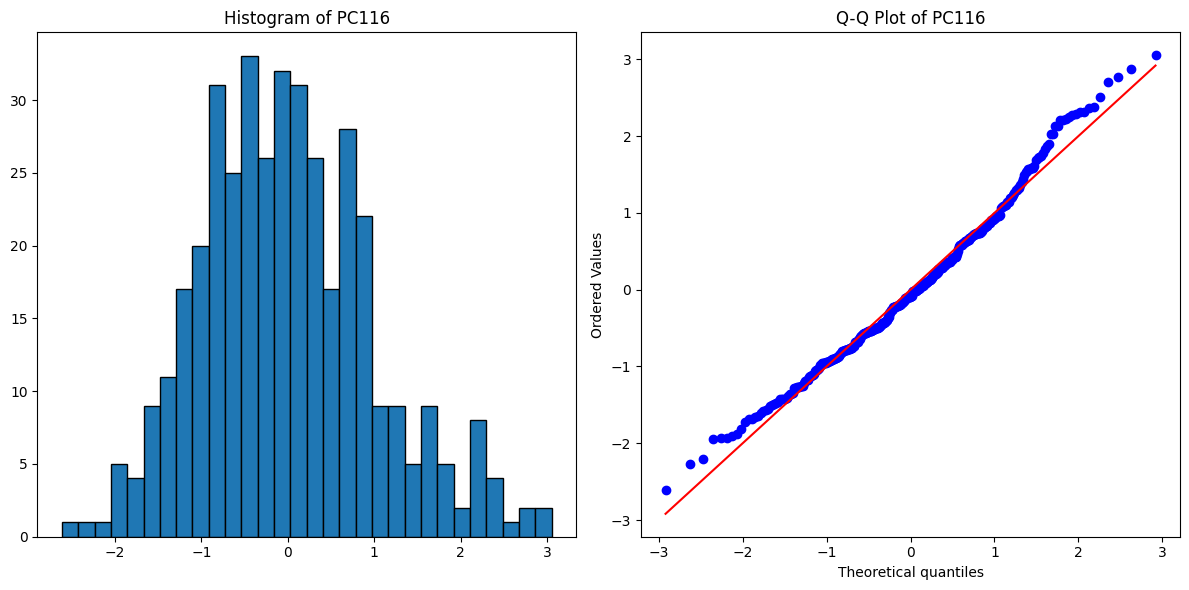

Shapiro-Wilk Test for PC116:
Statistic: 0.9861, p-value: 0.0007
PC116: Sample does not look Gaussian (reject H0)


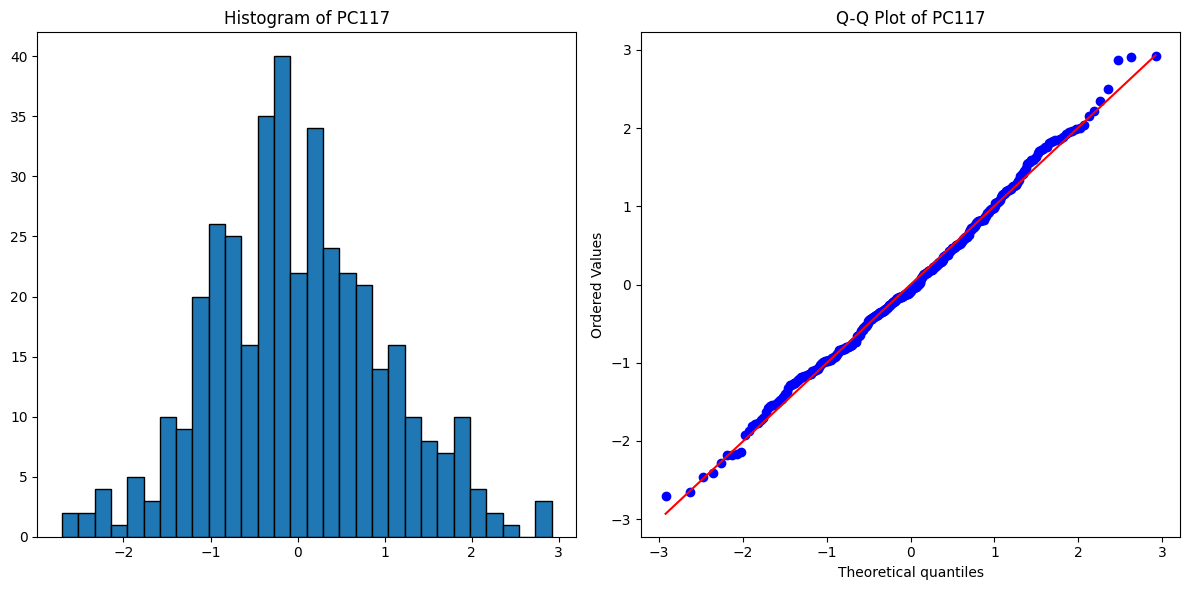

Shapiro-Wilk Test for PC117:
Statistic: 0.9950, p-value: 0.2265
PC117: Sample looks Gaussian (fail to reject H0)


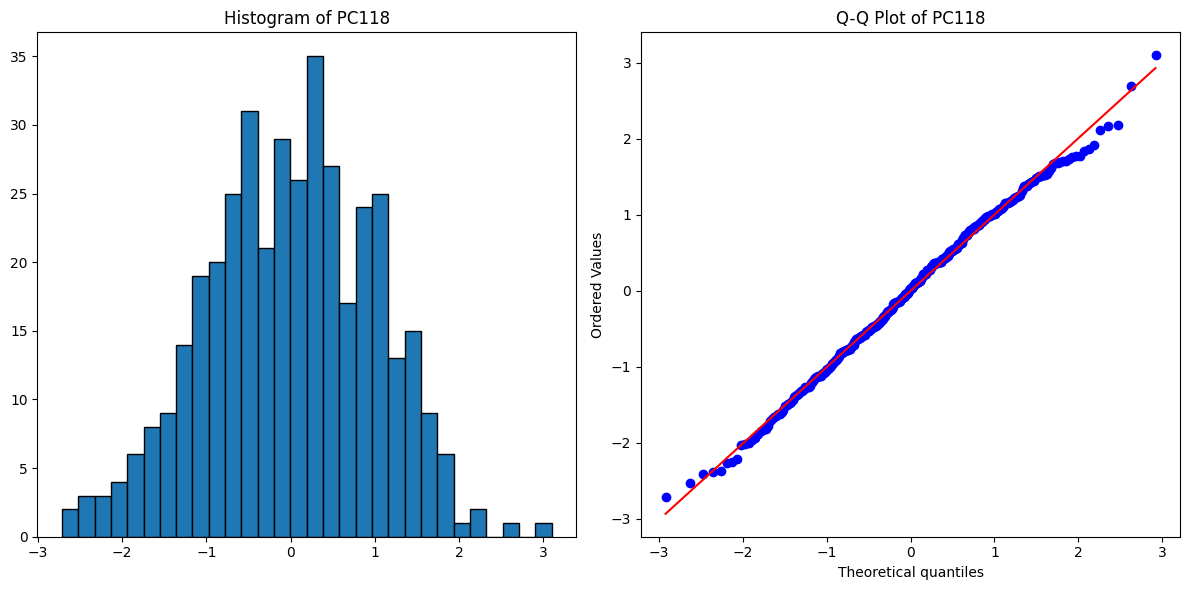

Shapiro-Wilk Test for PC118:
Statistic: 0.9964, p-value: 0.5073
PC118: Sample looks Gaussian (fail to reject H0)


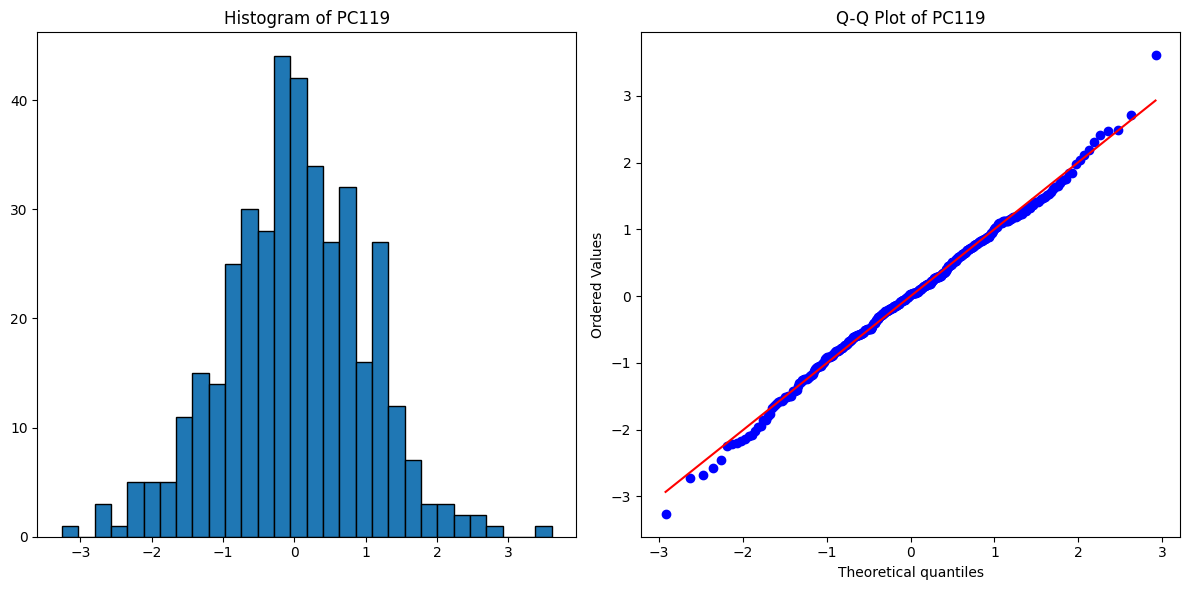

Shapiro-Wilk Test for PC119:
Statistic: 0.9966, p-value: 0.5609
PC119: Sample looks Gaussian (fail to reject H0)


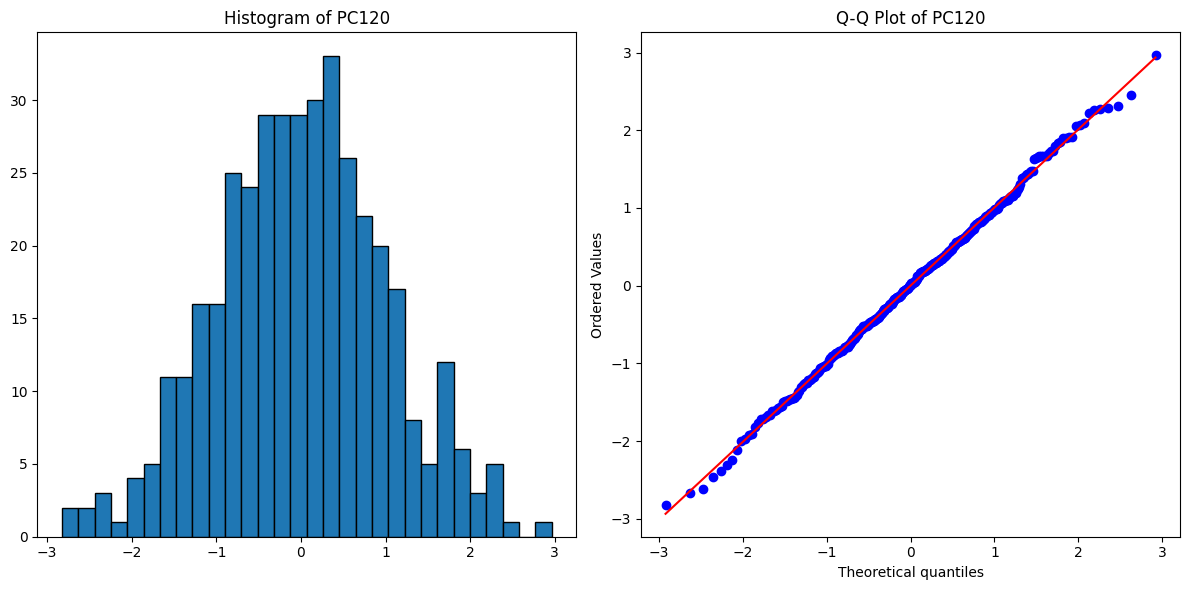

Shapiro-Wilk Test for PC120:
Statistic: 0.9984, p-value: 0.9712
PC120: Sample looks Gaussian (fail to reject H0)


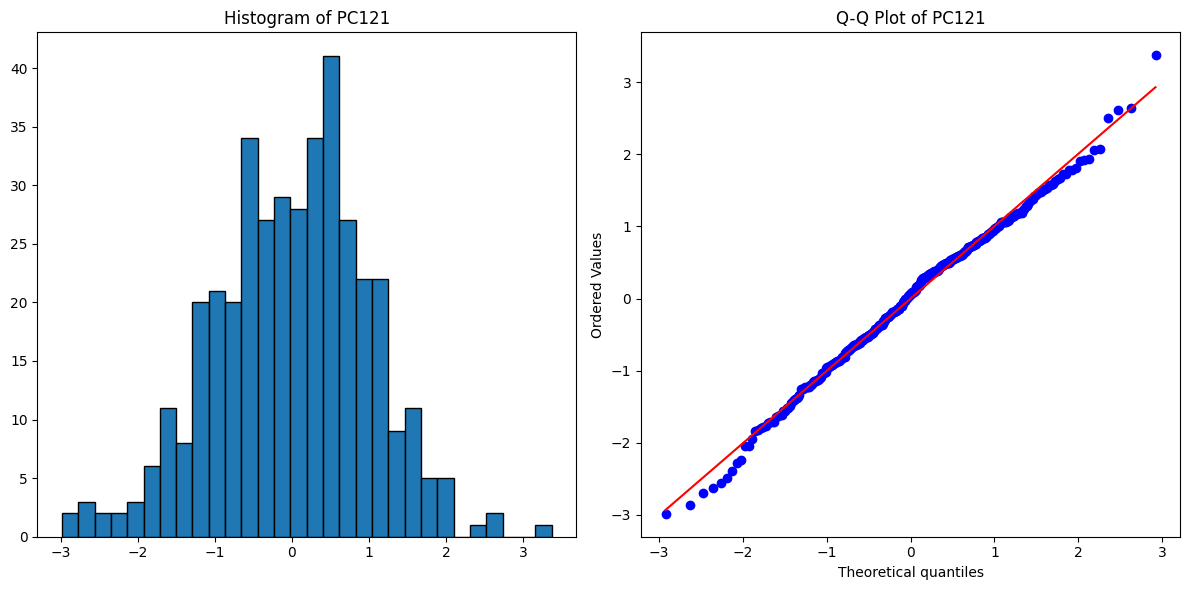

Shapiro-Wilk Test for PC121:
Statistic: 0.9951, p-value: 0.2522
PC121: Sample looks Gaussian (fail to reject H0)


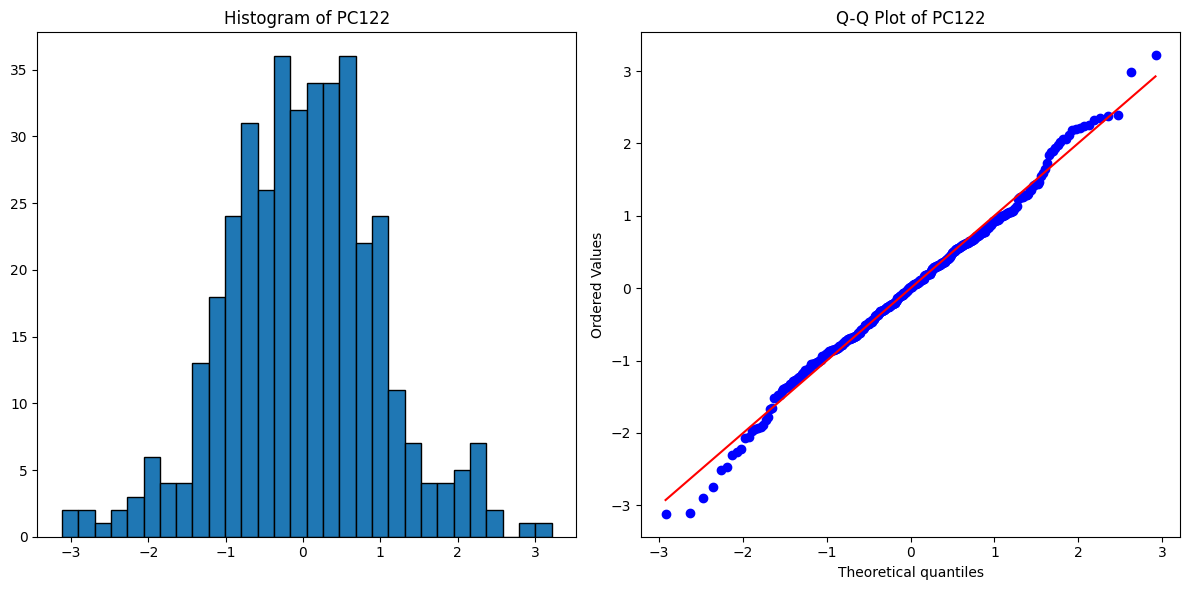

Shapiro-Wilk Test for PC122:
Statistic: 0.9927, p-value: 0.0512
PC122: Sample looks Gaussian (fail to reject H0)


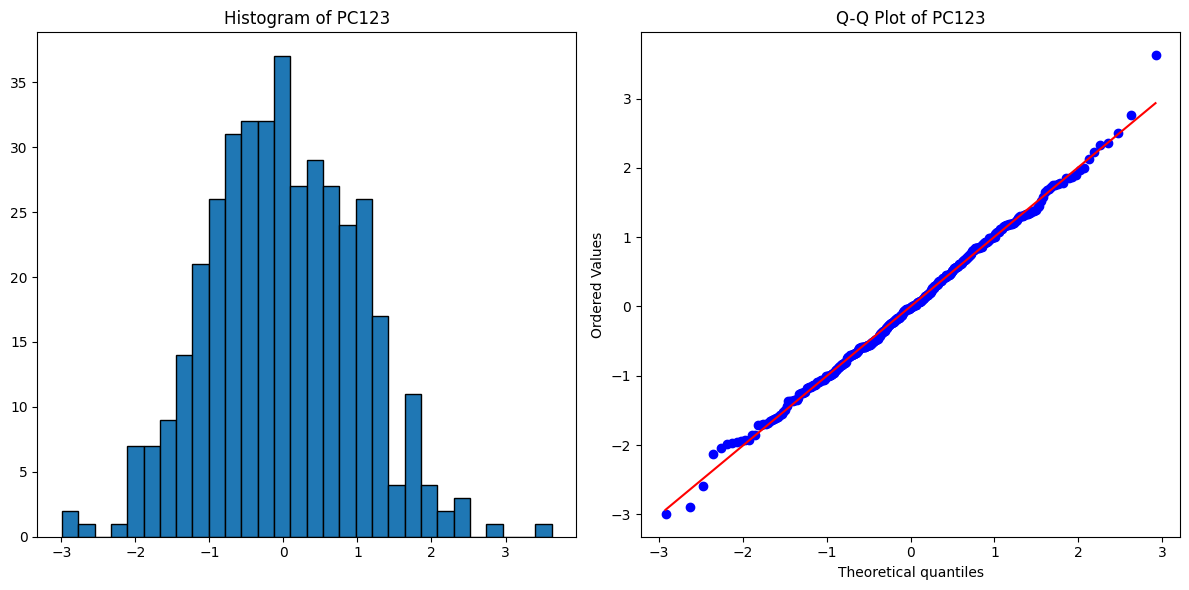

Shapiro-Wilk Test for PC123:
Statistic: 0.9975, p-value: 0.8301
PC123: Sample looks Gaussian (fail to reject H0)


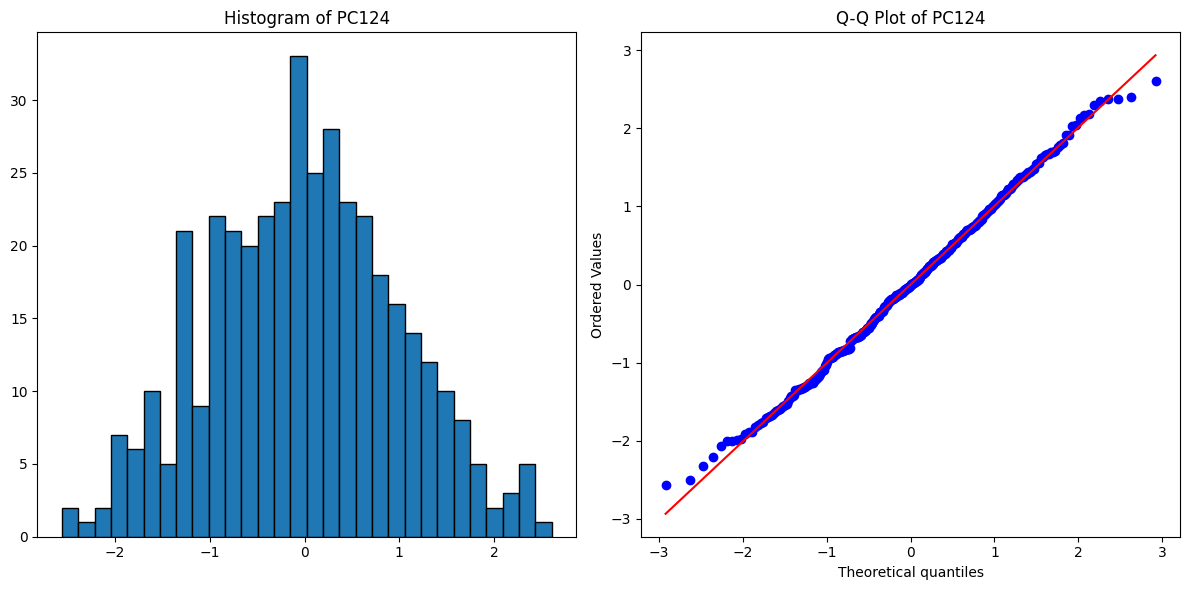

Shapiro-Wilk Test for PC124:
Statistic: 0.9965, p-value: 0.5554
PC124: Sample looks Gaussian (fail to reject H0)


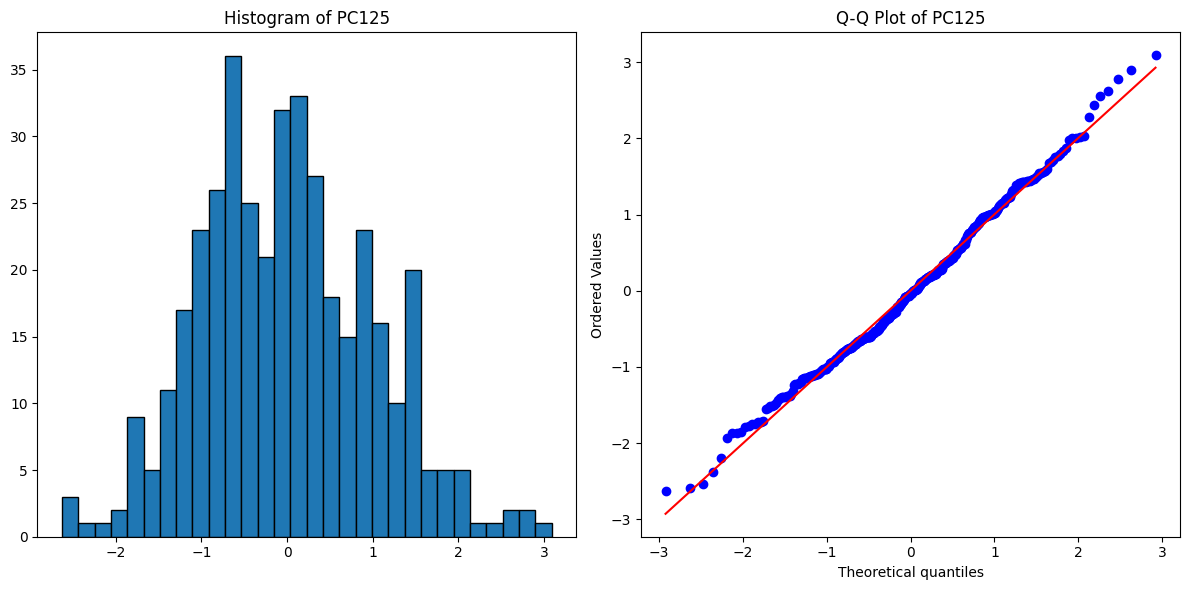

Shapiro-Wilk Test for PC125:
Statistic: 0.9931, p-value: 0.0669
PC125: Sample looks Gaussian (fail to reject H0)


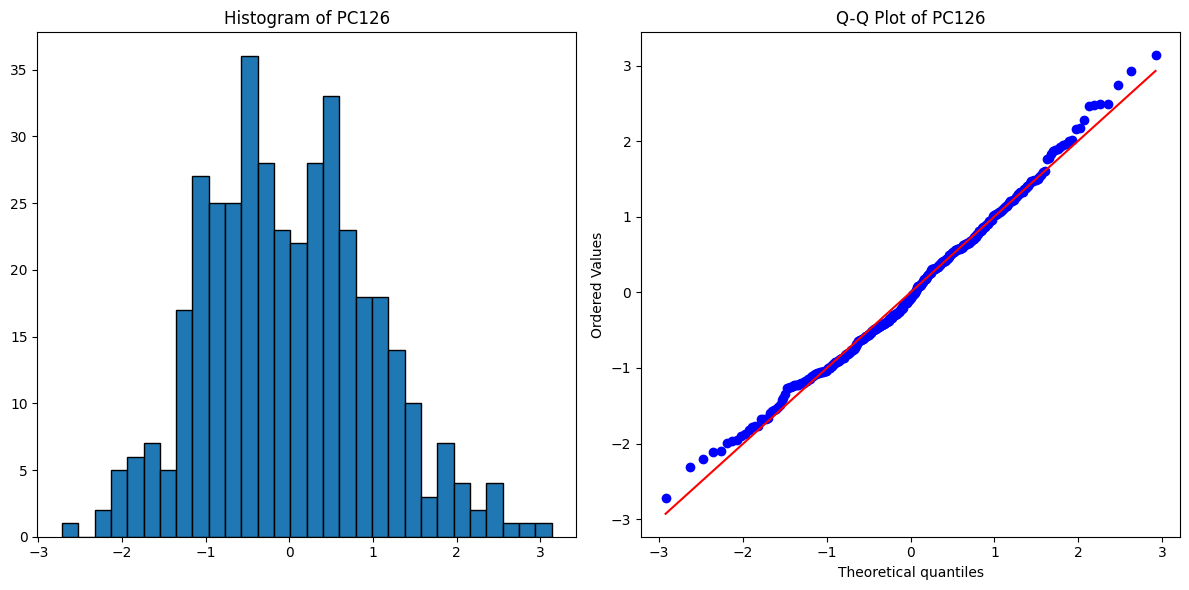

Shapiro-Wilk Test for PC126:
Statistic: 0.9932, p-value: 0.0722
PC126: Sample looks Gaussian (fail to reject H0)


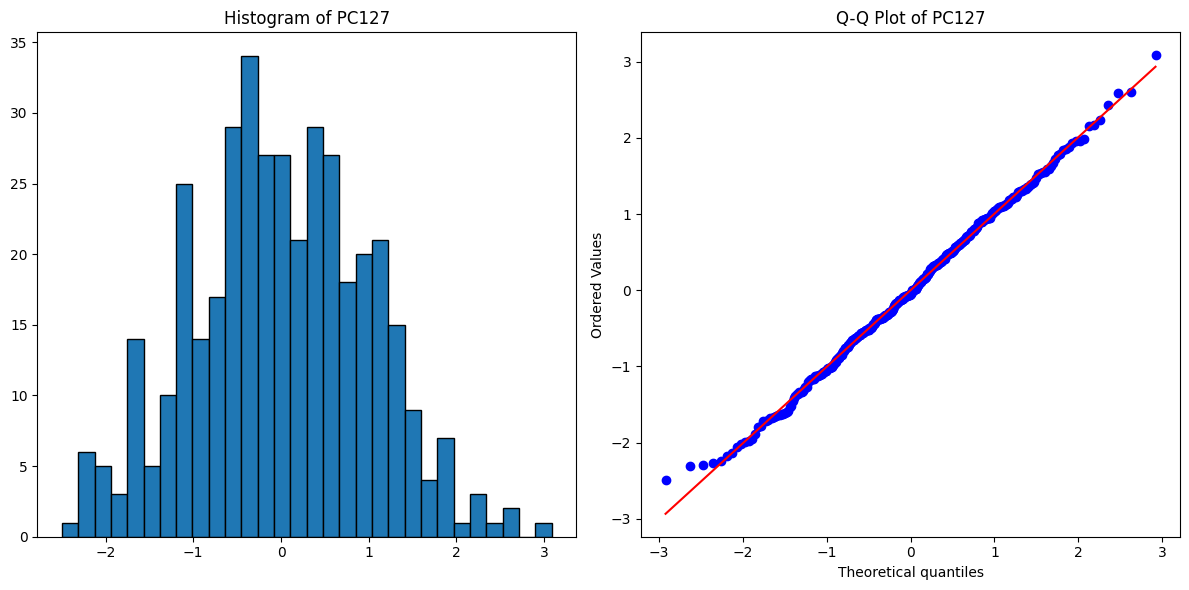

Shapiro-Wilk Test for PC127:
Statistic: 0.9973, p-value: 0.7549
PC127: Sample looks Gaussian (fail to reject H0)


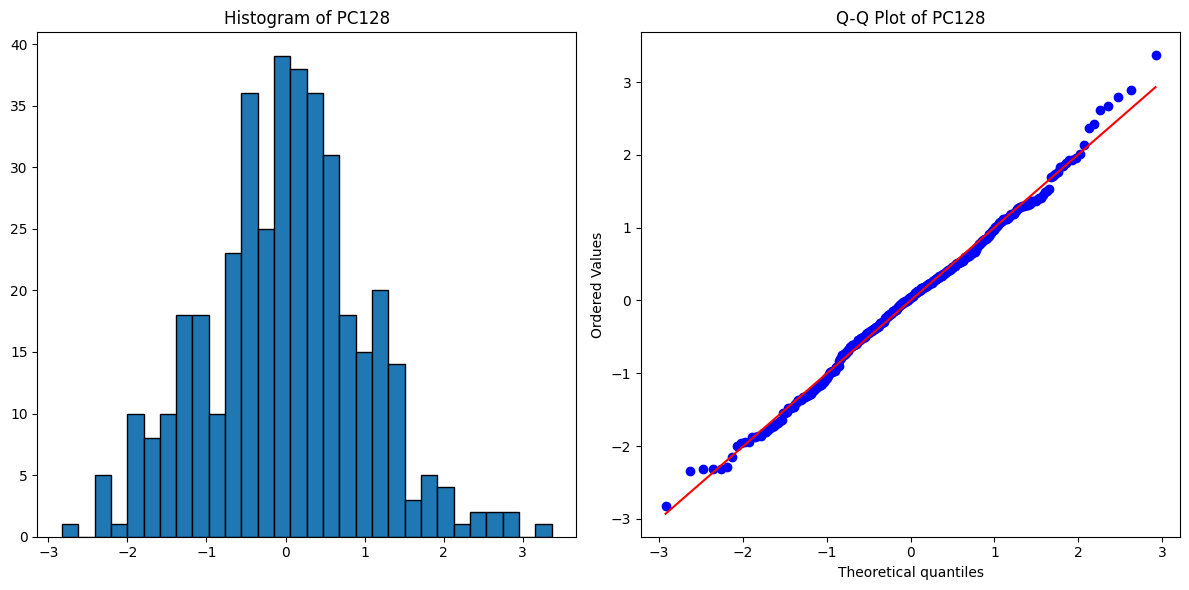

Shapiro-Wilk Test for PC128:
Statistic: 0.9951, p-value: 0.2391
PC128: Sample looks Gaussian (fail to reject H0)


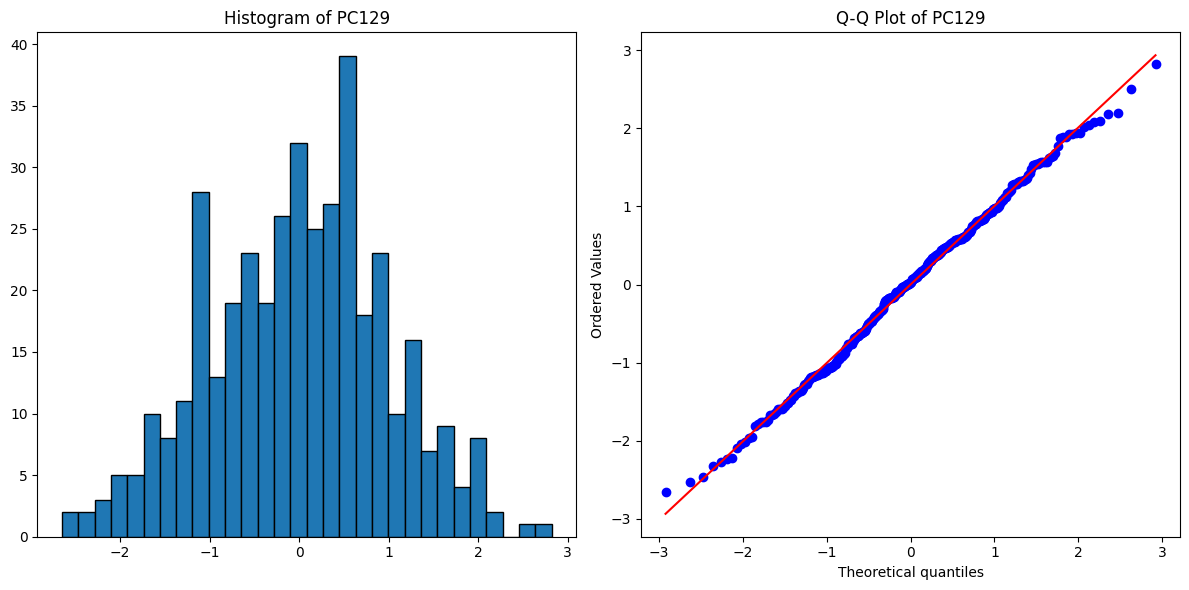

Shapiro-Wilk Test for PC129:
Statistic: 0.9962, p-value: 0.4618
PC129: Sample looks Gaussian (fail to reject H0)


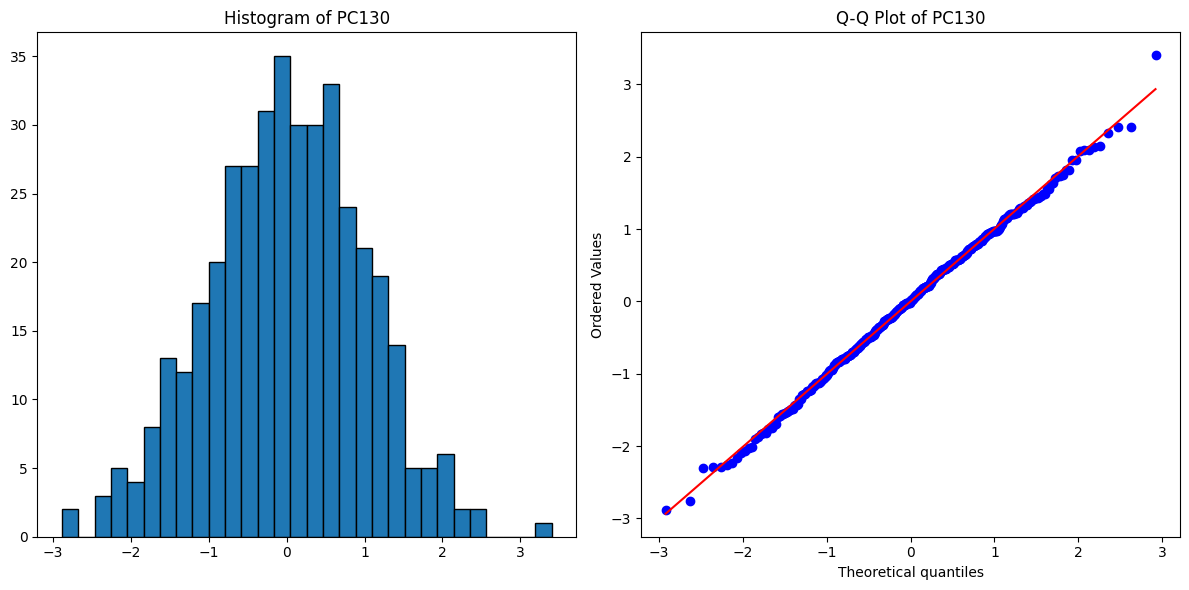

Shapiro-Wilk Test for PC130:
Statistic: 0.9981, p-value: 0.9439
PC130: Sample looks Gaussian (fail to reject H0)


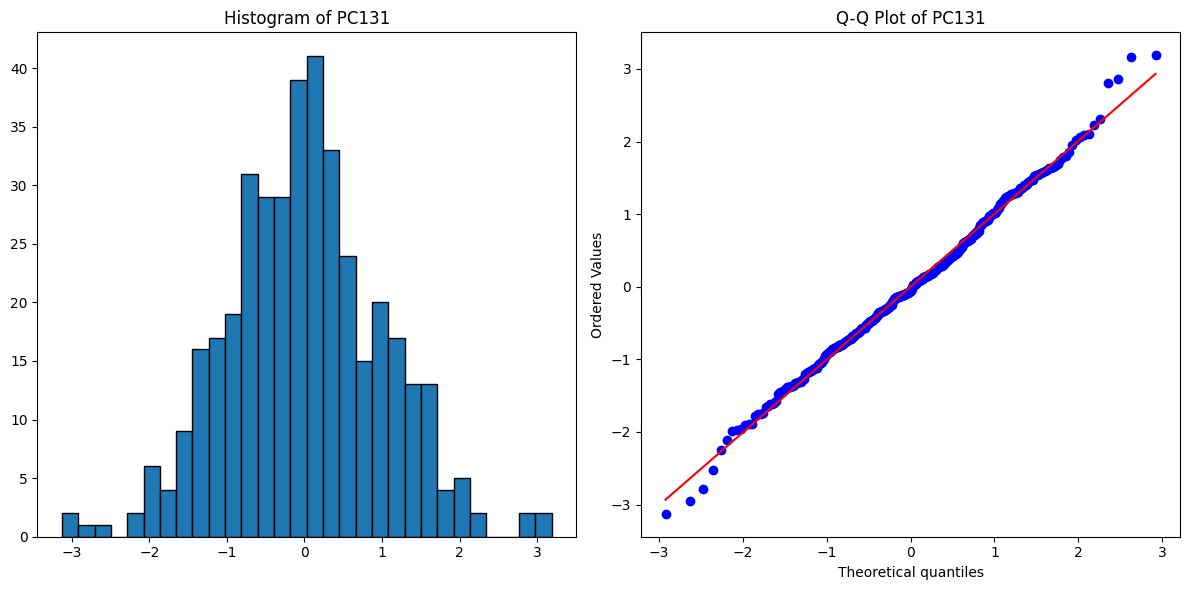

Shapiro-Wilk Test for PC131:
Statistic: 0.9960, p-value: 0.4080
PC131: Sample looks Gaussian (fail to reject H0)


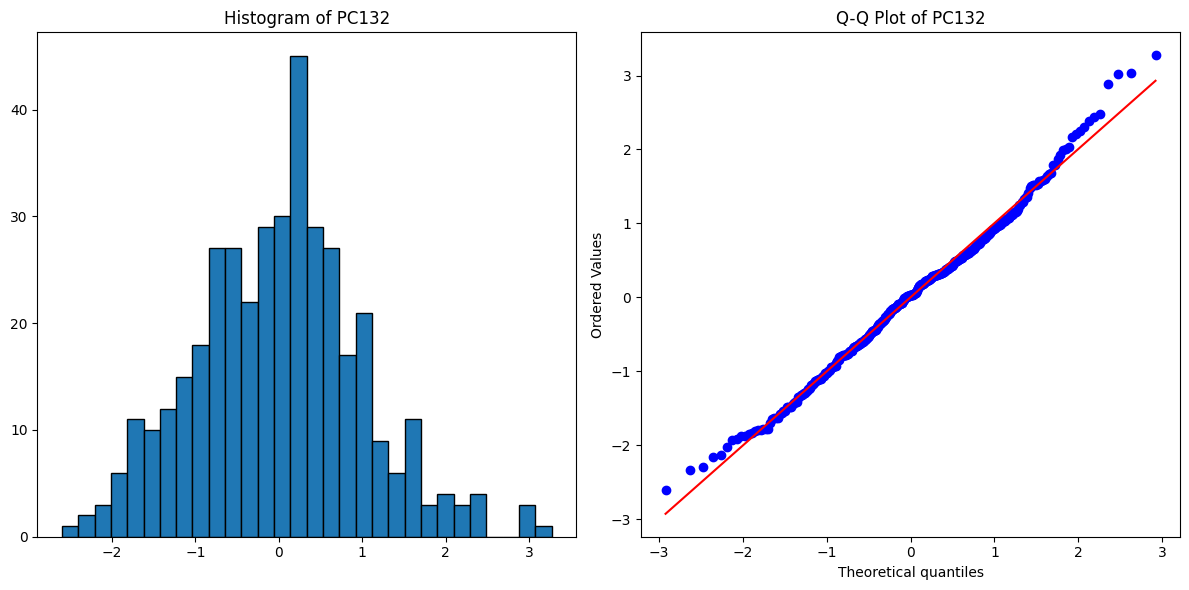

Shapiro-Wilk Test for PC132:
Statistic: 0.9933, p-value: 0.0736
PC132: Sample looks Gaussian (fail to reject H0)


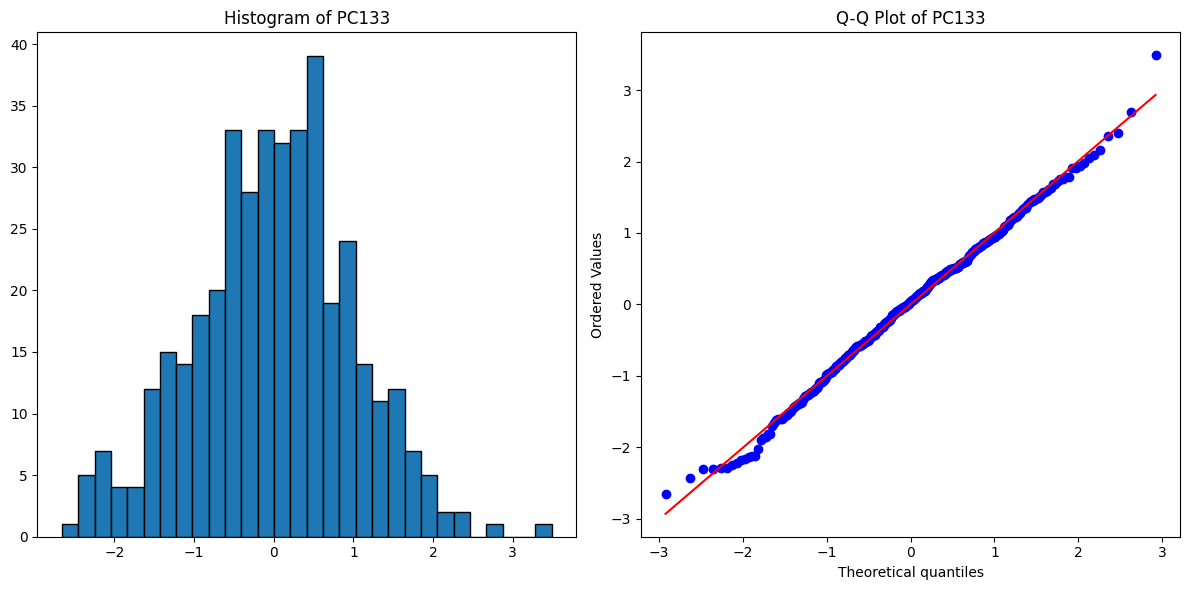

Shapiro-Wilk Test for PC133:
Statistic: 0.9964, p-value: 0.5164
PC133: Sample looks Gaussian (fail to reject H0)


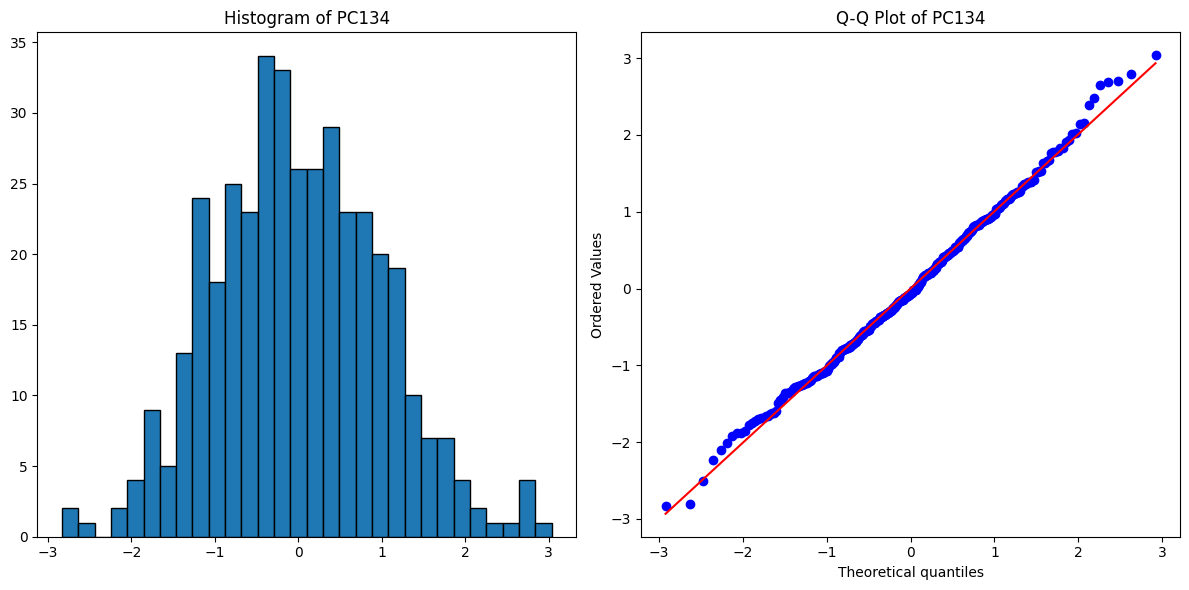

Shapiro-Wilk Test for PC134:
Statistic: 0.9963, p-value: 0.5022
PC134: Sample looks Gaussian (fail to reject H0)


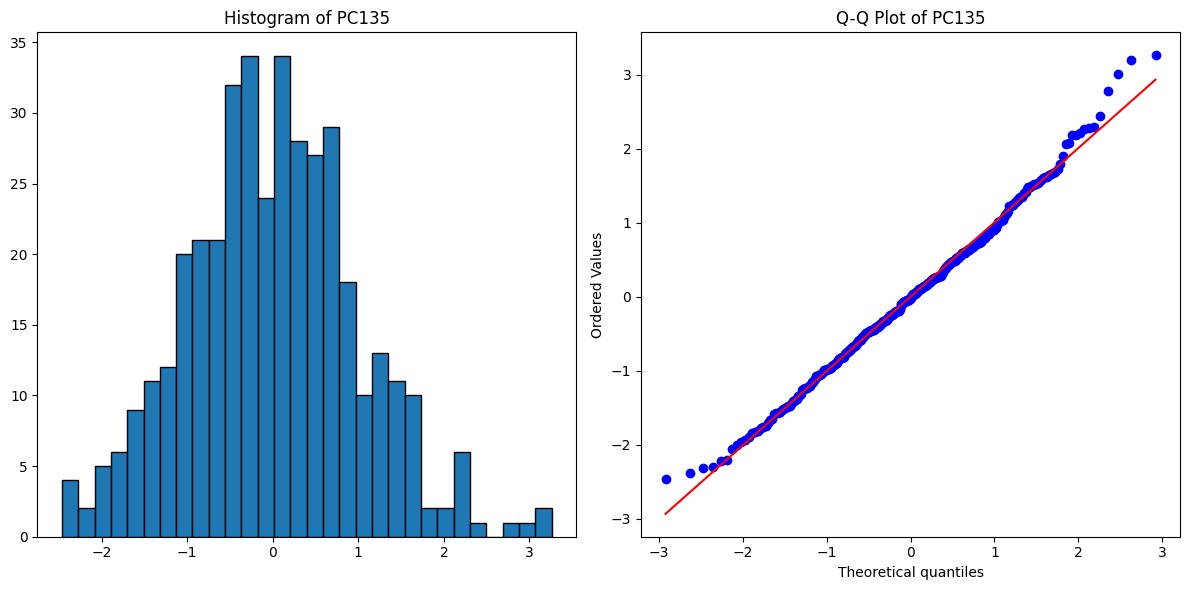

Shapiro-Wilk Test for PC135:
Statistic: 0.9945, p-value: 0.1701
PC135: Sample looks Gaussian (fail to reject H0)


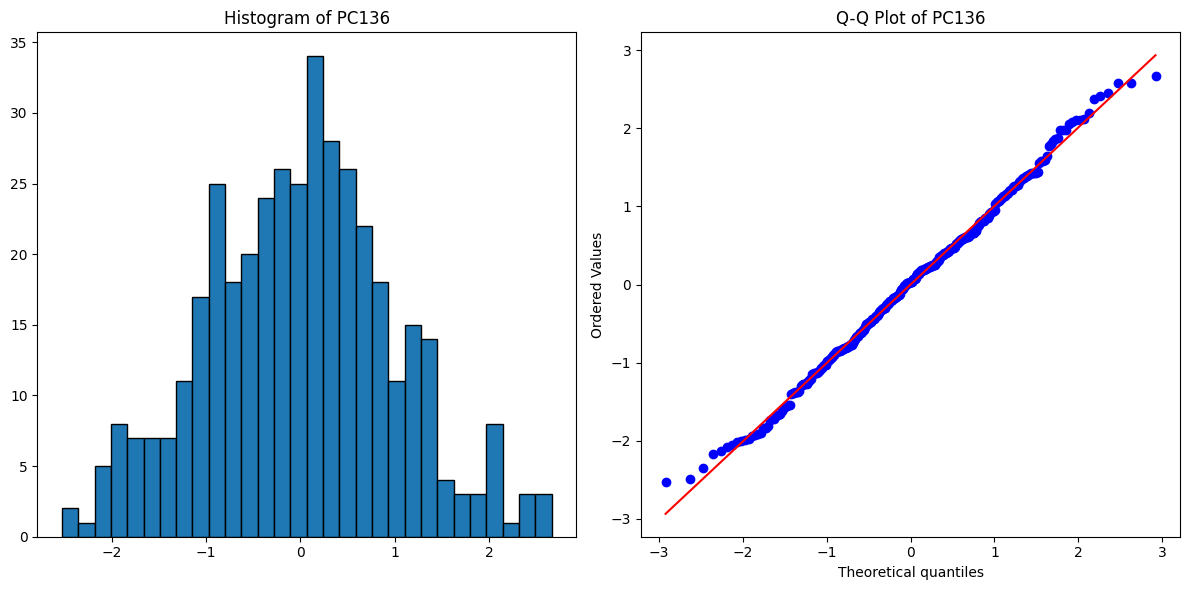

Shapiro-Wilk Test for PC136:
Statistic: 0.9958, p-value: 0.3813
PC136: Sample looks Gaussian (fail to reject H0)


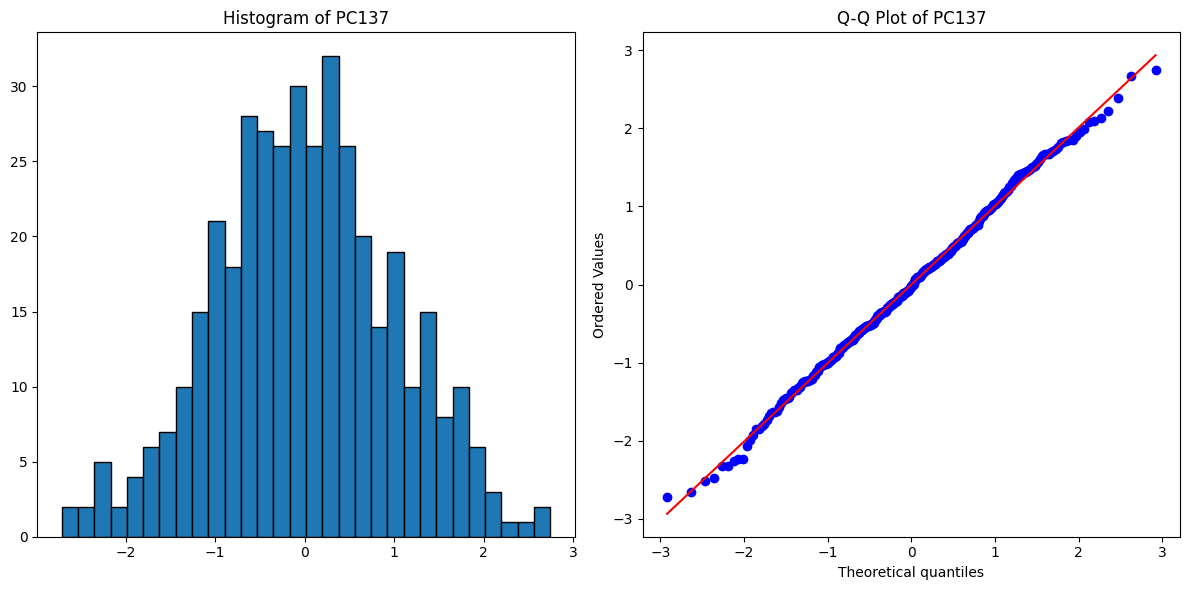

Shapiro-Wilk Test for PC137:
Statistic: 0.9974, p-value: 0.8012
PC137: Sample looks Gaussian (fail to reject H0)


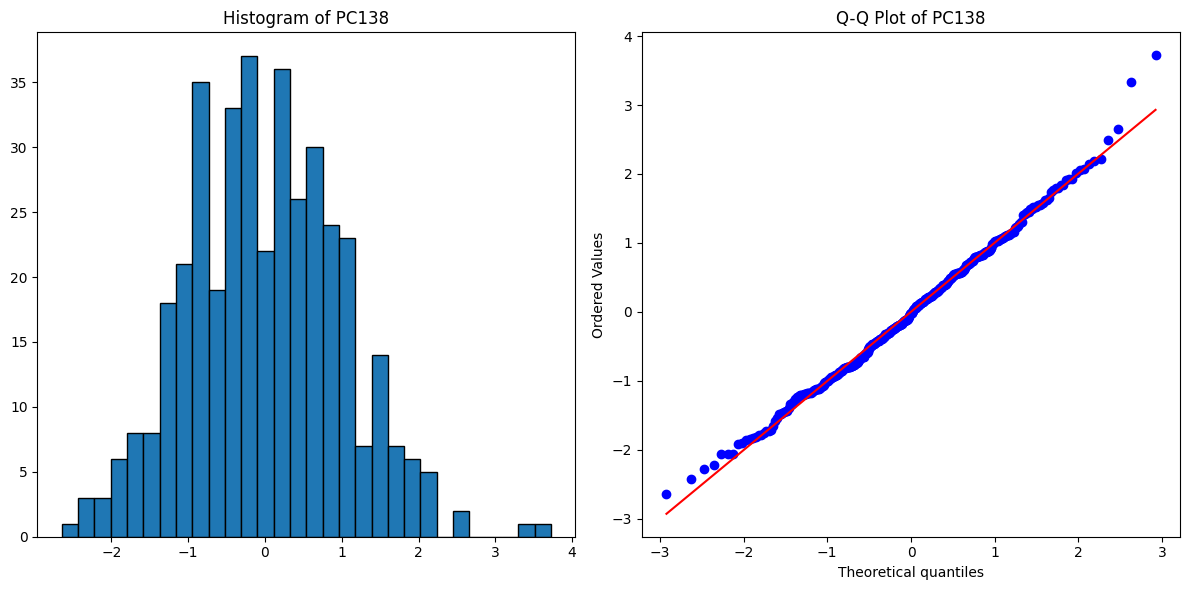

Shapiro-Wilk Test for PC138:
Statistic: 0.9951, p-value: 0.2455
PC138: Sample looks Gaussian (fail to reject H0)


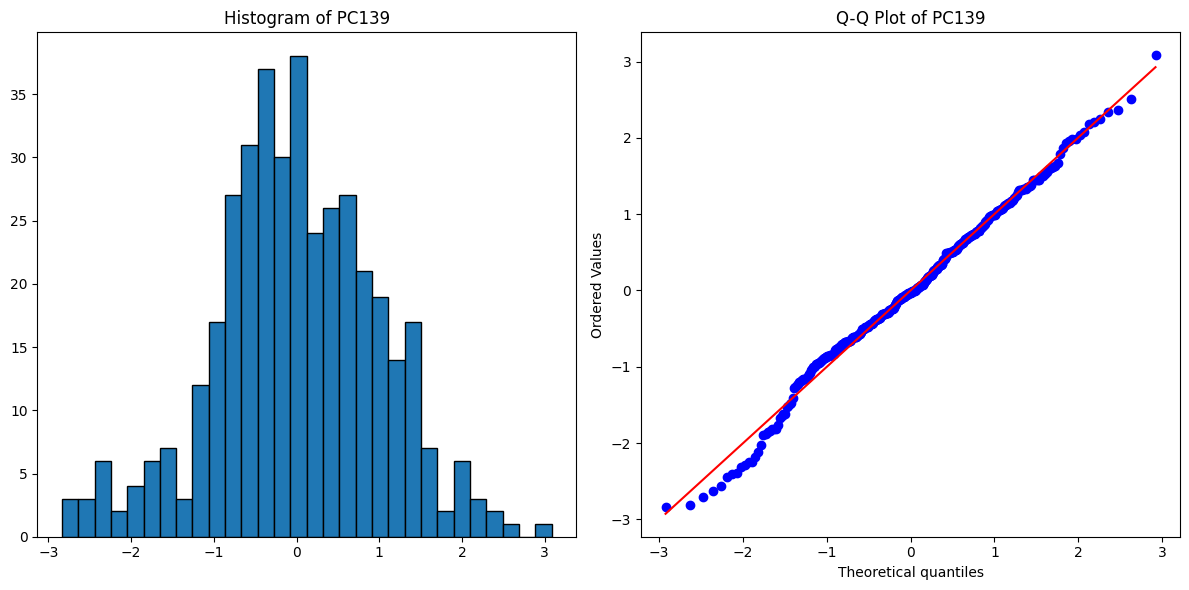

Shapiro-Wilk Test for PC139:
Statistic: 0.9928, p-value: 0.0555
PC139: Sample looks Gaussian (fail to reject H0)


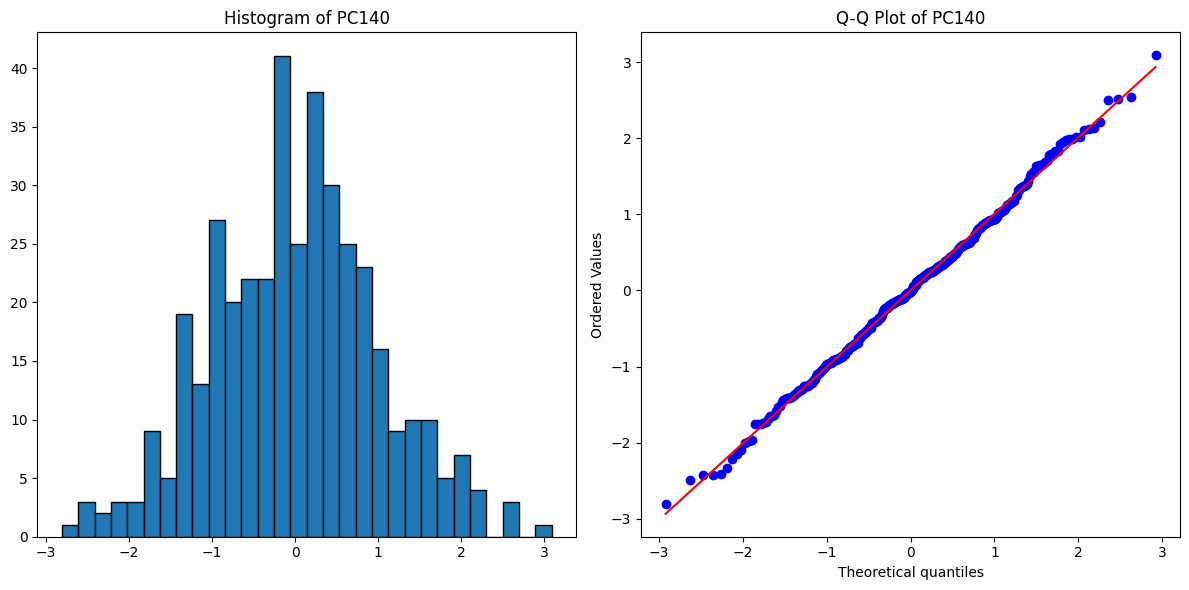

Shapiro-Wilk Test for PC140:
Statistic: 0.9977, p-value: 0.8598
PC140: Sample looks Gaussian (fail to reject H0)


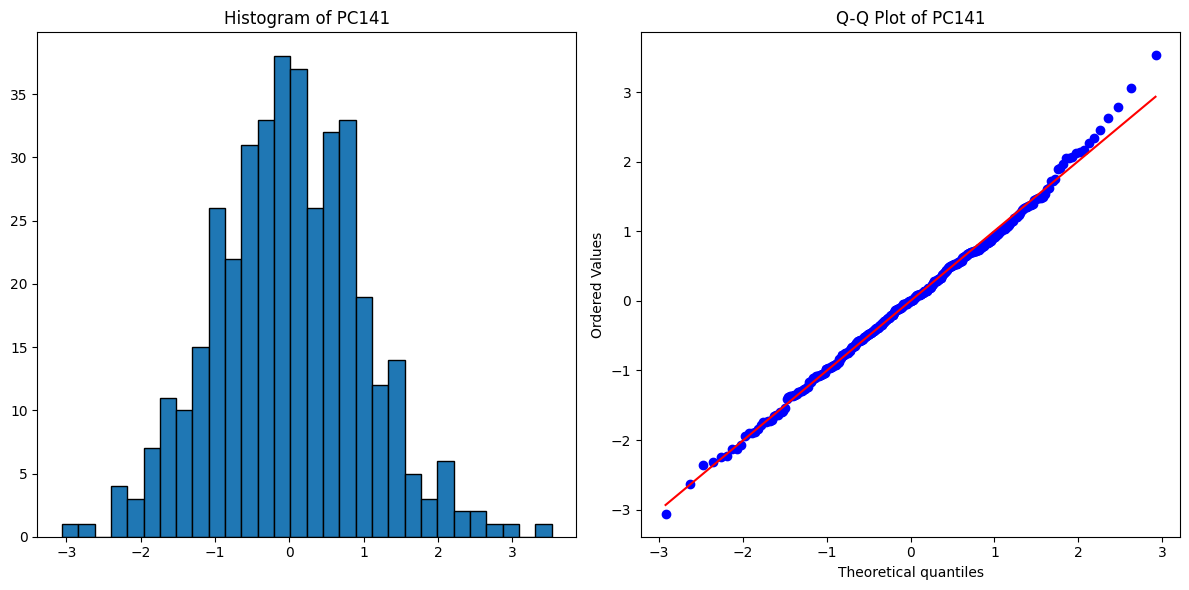

Shapiro-Wilk Test for PC141:
Statistic: 0.9968, p-value: 0.6276
PC141: Sample looks Gaussian (fail to reject H0)


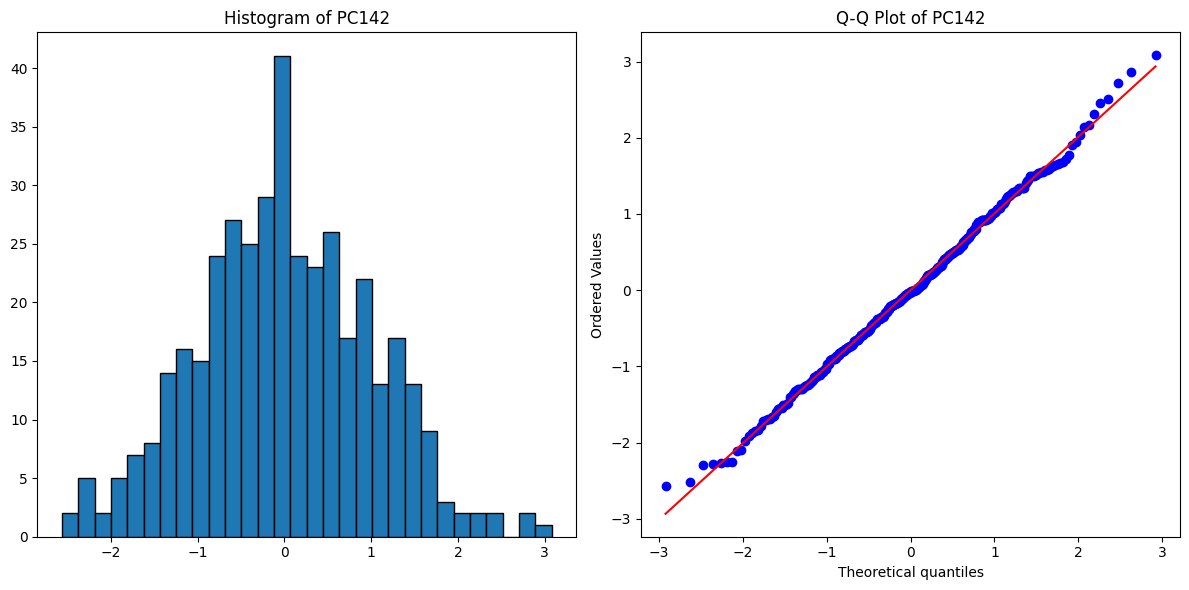

Shapiro-Wilk Test for PC142:
Statistic: 0.9973, p-value: 0.7756
PC142: Sample looks Gaussian (fail to reject H0)


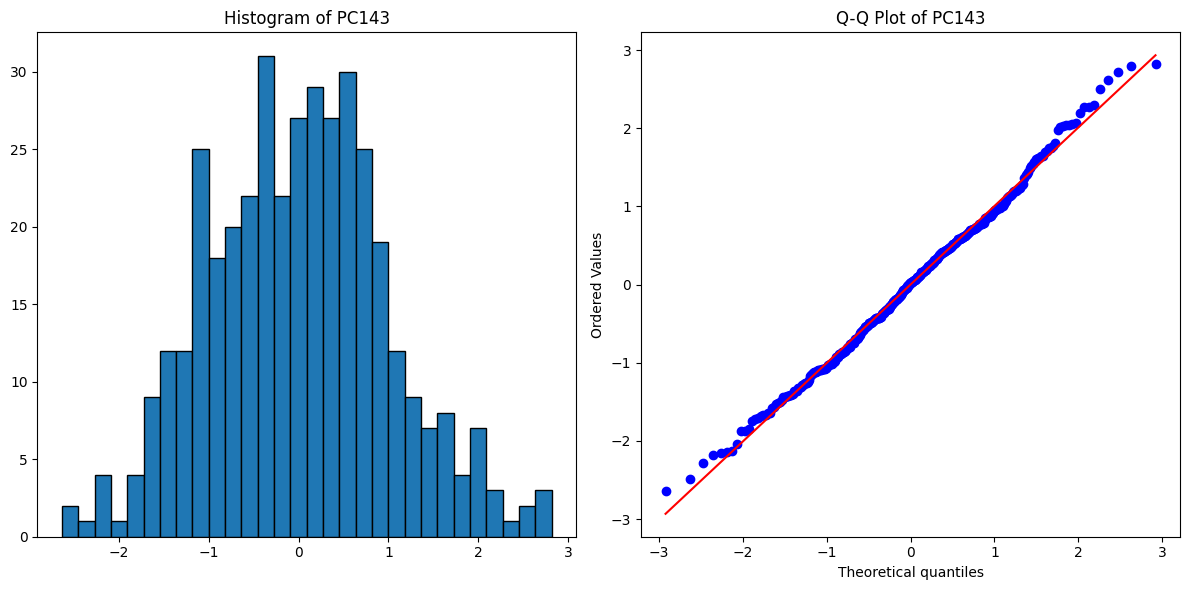

Shapiro-Wilk Test for PC143:
Statistic: 0.9955, p-value: 0.3063
PC143: Sample looks Gaussian (fail to reject H0)


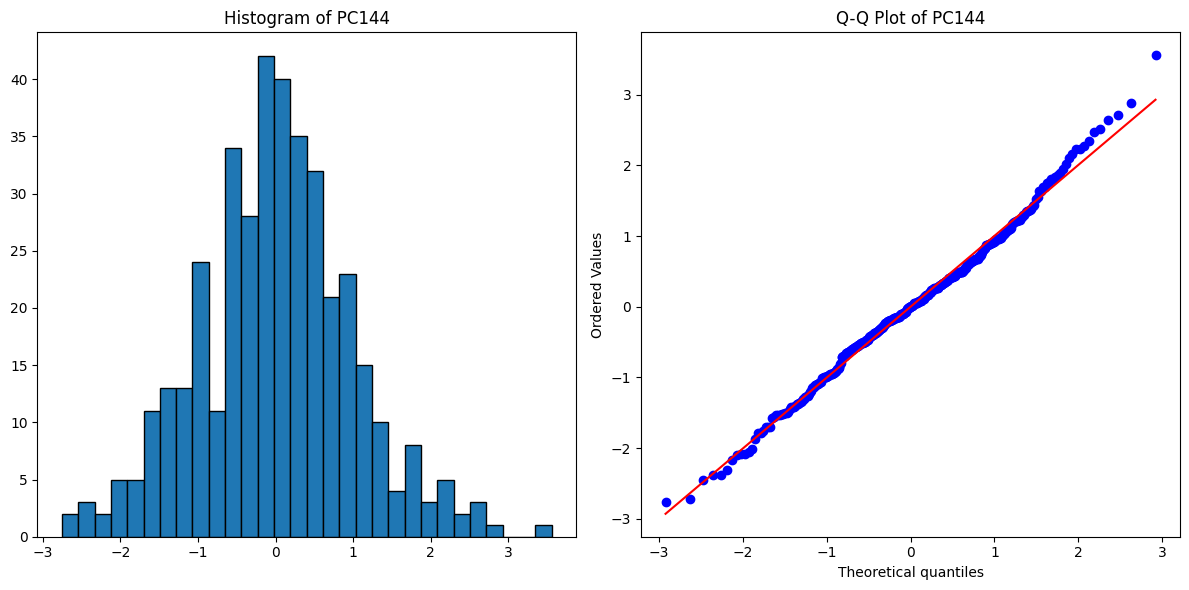

Shapiro-Wilk Test for PC144:
Statistic: 0.9939, p-value: 0.1119
PC144: Sample looks Gaussian (fail to reject H0)


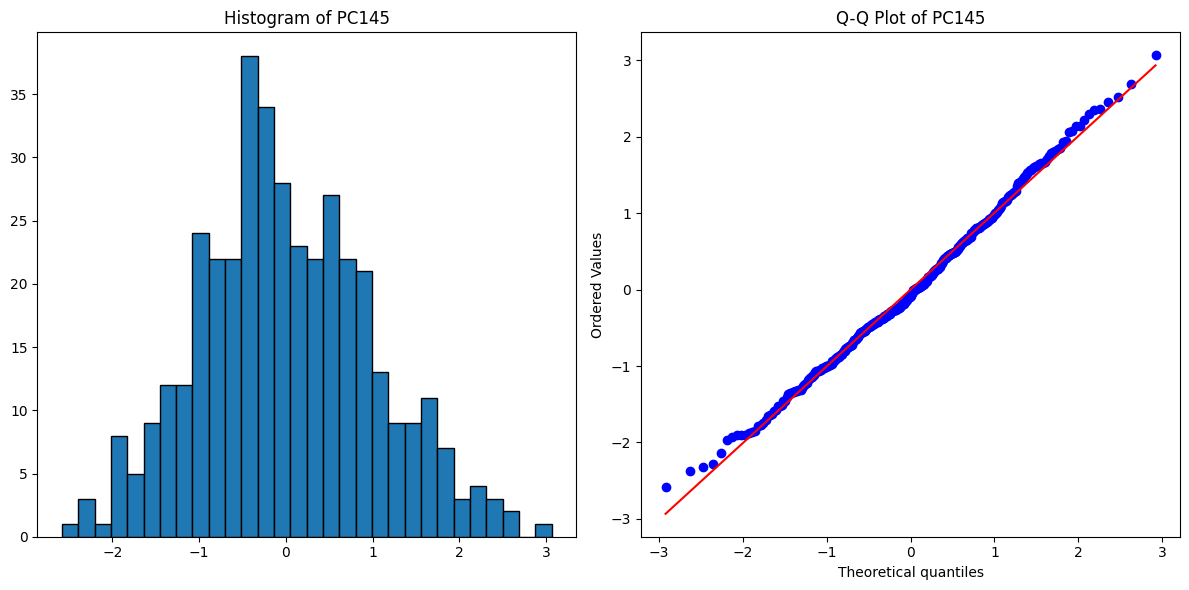

Shapiro-Wilk Test for PC145:
Statistic: 0.9953, p-value: 0.2854
PC145: Sample looks Gaussian (fail to reject H0)


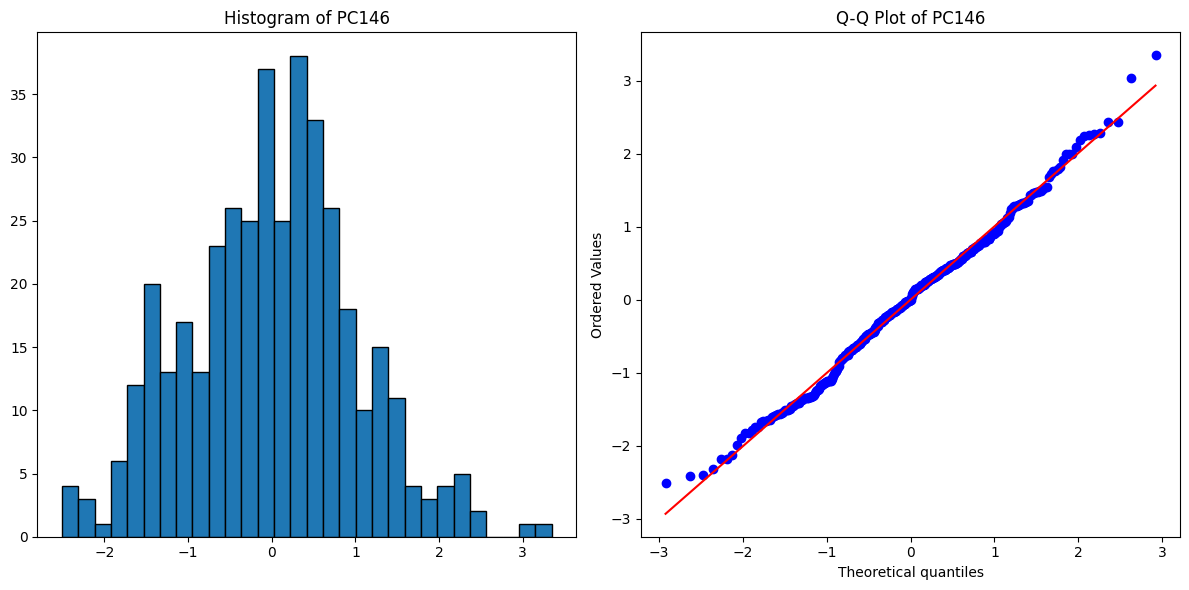

Shapiro-Wilk Test for PC146:
Statistic: 0.9945, p-value: 0.1718
PC146: Sample looks Gaussian (fail to reject H0)


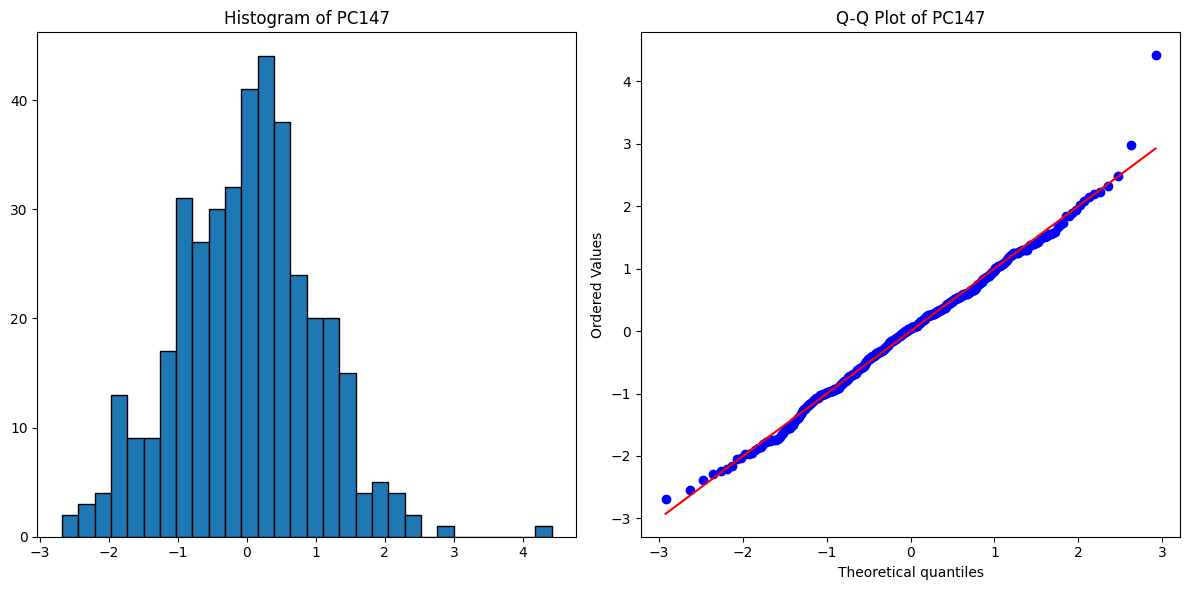

Shapiro-Wilk Test for PC147:
Statistic: 0.9930, p-value: 0.0611
PC147: Sample looks Gaussian (fail to reject H0)


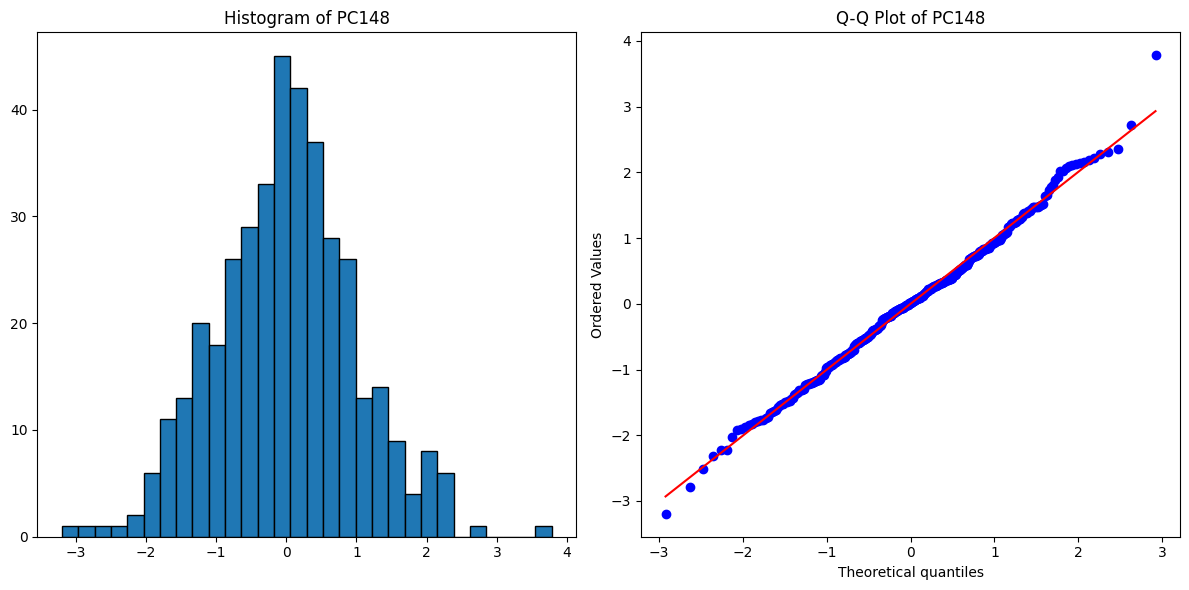

Shapiro-Wilk Test for PC148:
Statistic: 0.9962, p-value: 0.4576
PC148: Sample looks Gaussian (fail to reject H0)


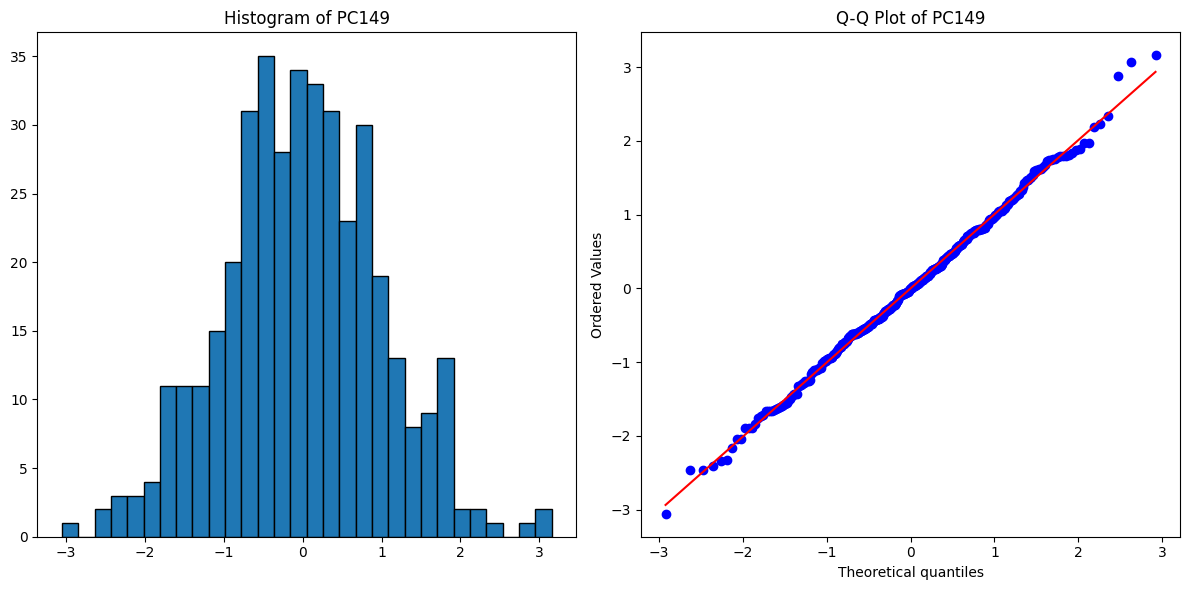

Shapiro-Wilk Test for PC149:
Statistic: 0.9976, p-value: 0.8537
PC149: Sample looks Gaussian (fail to reject H0)


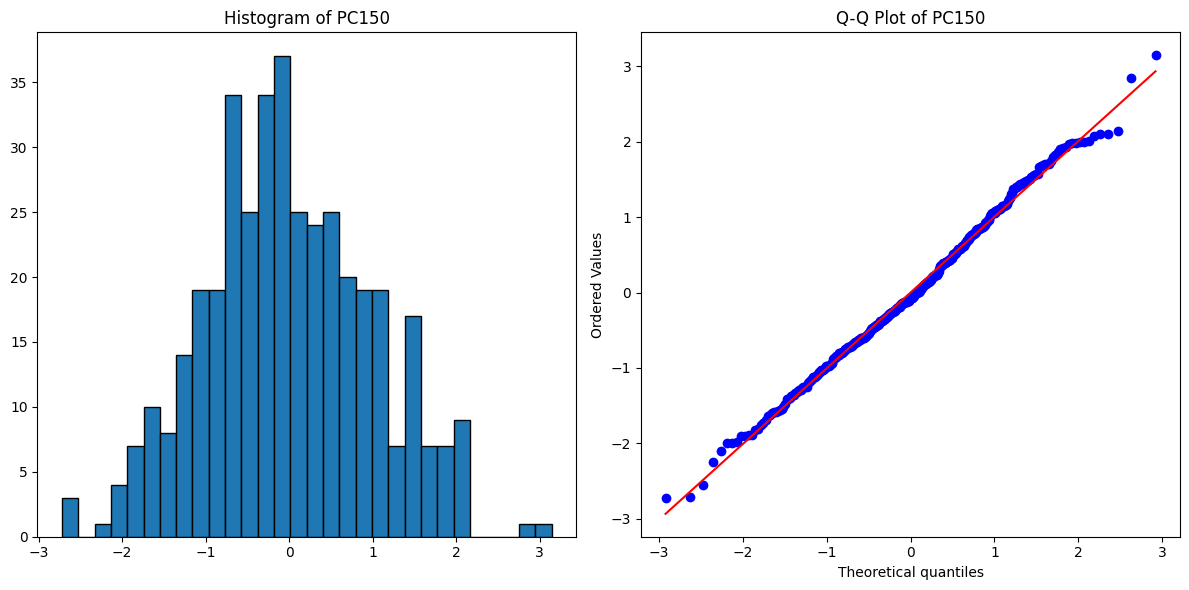

Shapiro-Wilk Test for PC150:
Statistic: 0.9959, p-value: 0.3926
PC150: Sample looks Gaussian (fail to reject H0)


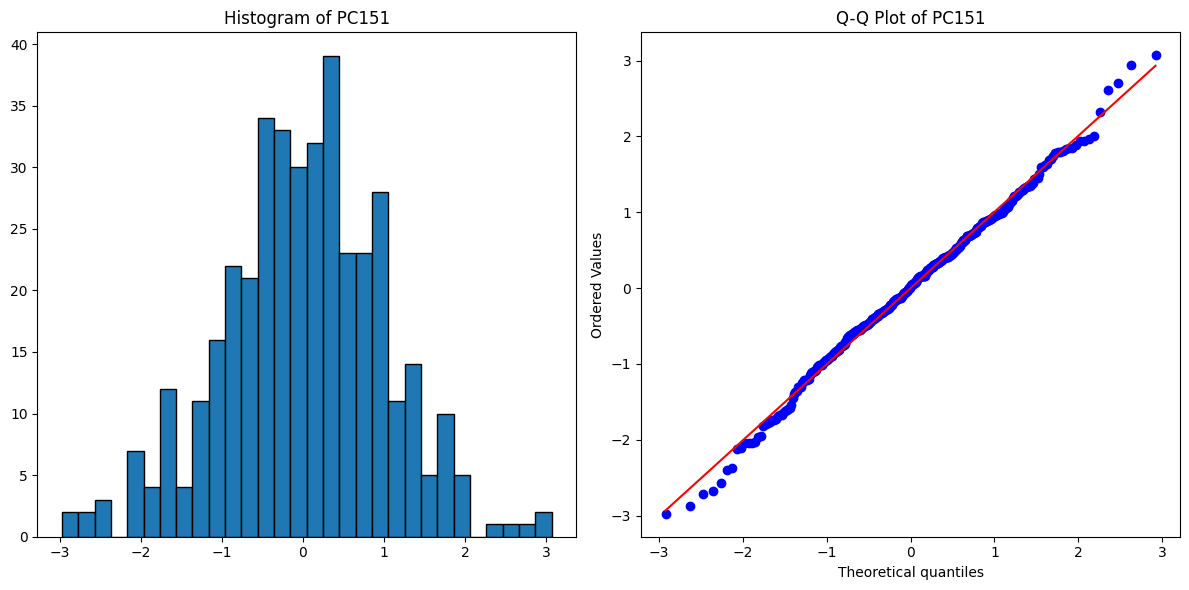

Shapiro-Wilk Test for PC151:
Statistic: 0.9958, p-value: 0.3633
PC151: Sample looks Gaussian (fail to reject H0)


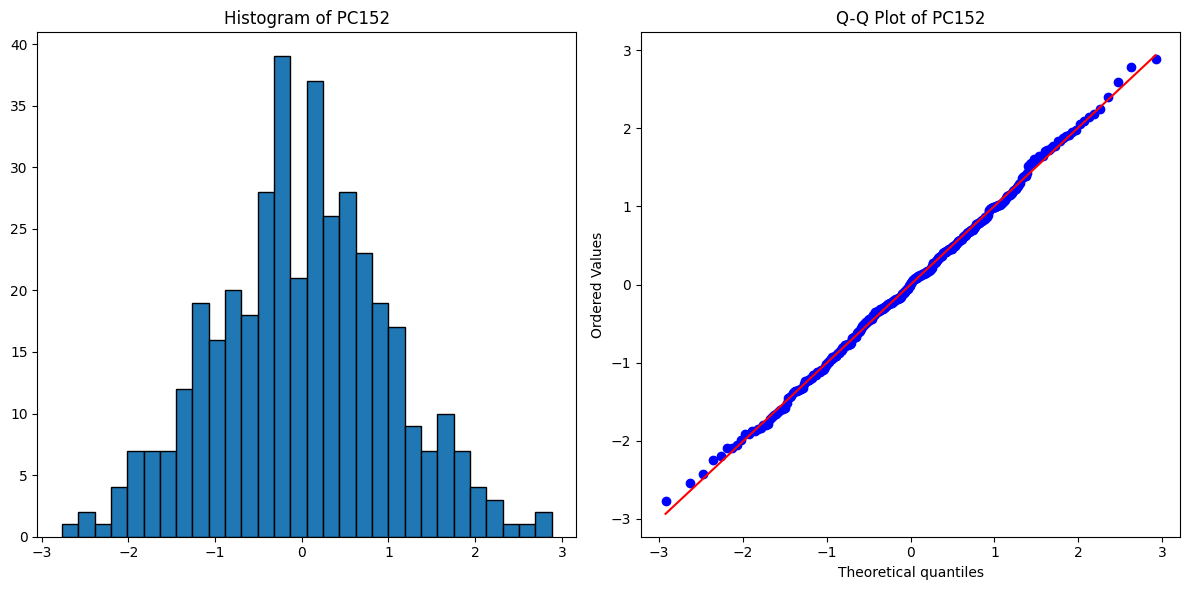

Shapiro-Wilk Test for PC152:
Statistic: 0.9980, p-value: 0.9313
PC152: Sample looks Gaussian (fail to reject H0)


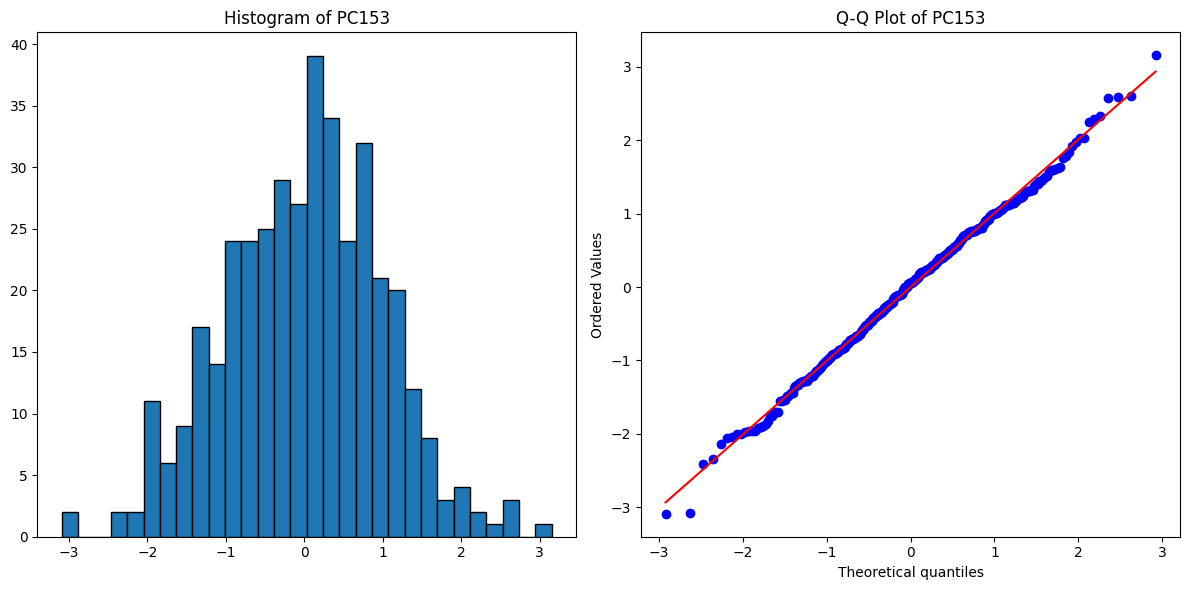

Shapiro-Wilk Test for PC153:
Statistic: 0.9972, p-value: 0.7380
PC153: Sample looks Gaussian (fail to reject H0)


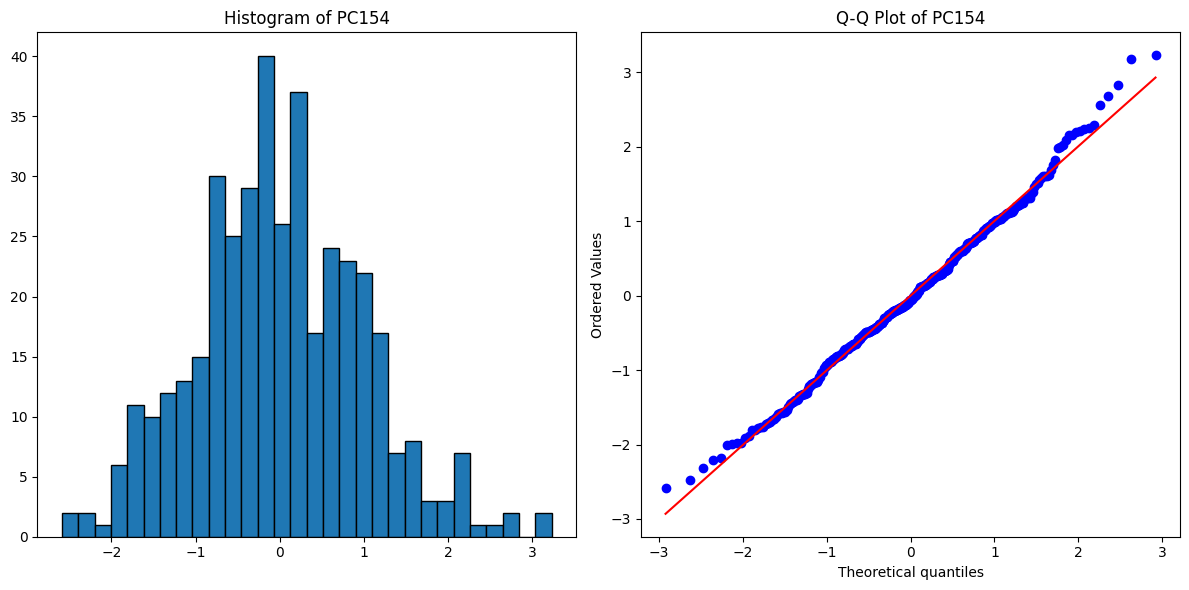

Shapiro-Wilk Test for PC154:
Statistic: 0.9945, p-value: 0.1690
PC154: Sample looks Gaussian (fail to reject H0)


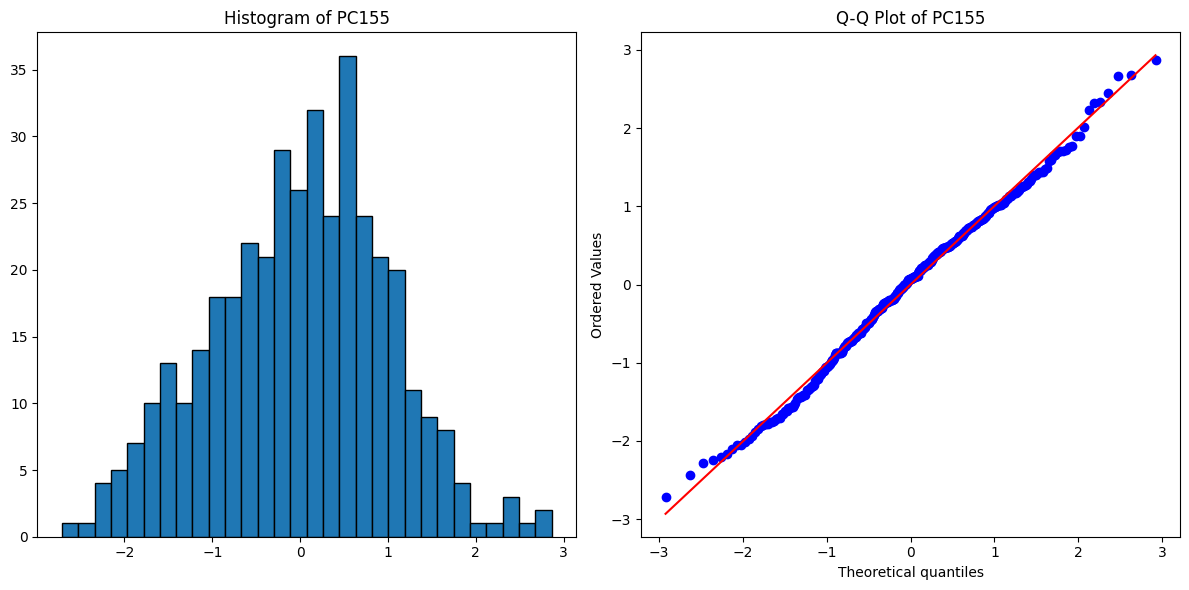

Shapiro-Wilk Test for PC155:
Statistic: 0.9947, p-value: 0.1848
PC155: Sample looks Gaussian (fail to reject H0)


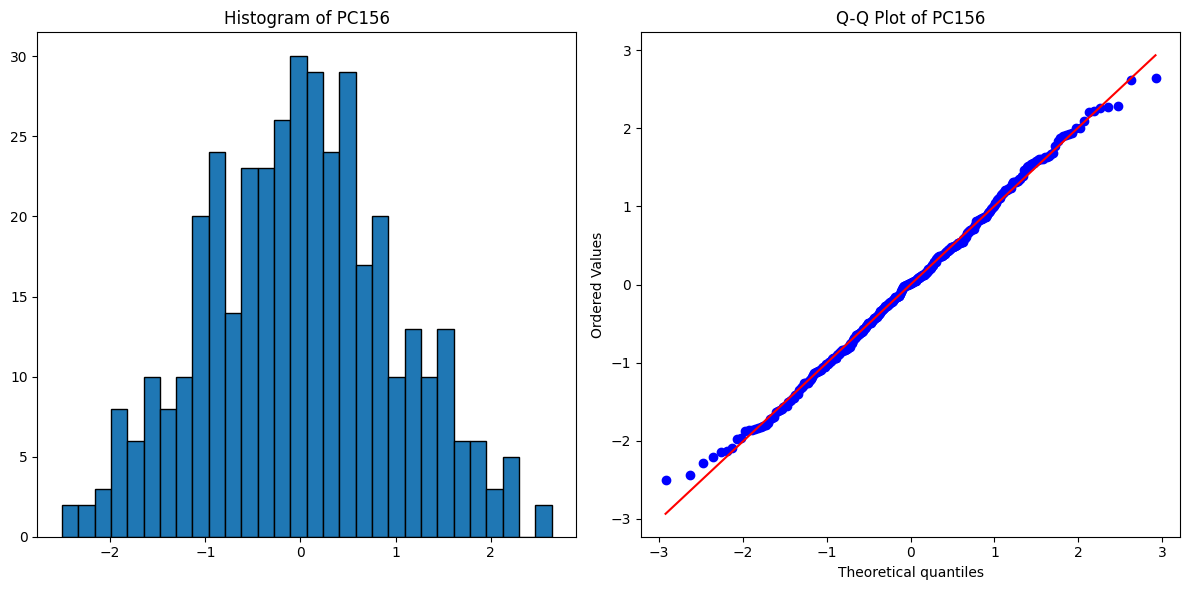

Shapiro-Wilk Test for PC156:
Statistic: 0.9964, p-value: 0.5102
PC156: Sample looks Gaussian (fail to reject H0)



KeyboardInterrupt



In [14]:
import pandas as pd

# Read data from CSV
df = pd.read_csv('Datasets/HOG/ml/HOG_car_featuresPCAstand.csv')


# Step 2: Filter numerical columns
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
df_numerical = df[numerical_columns]

# Step 3: Summary statistics
summary_stats = df_numerical.describe()
print("Summary Statistics:")
print(summary_stats)

# Step 4: Visual inspection and normality checks for numerical features
for column in df_numerical.columns:
    data = df_numerical[column].values
    
    # Histogram
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(data, bins=30, edgecolor='black')
    plt.title(f'Histogram of {column}')
    
    # Q-Q plot
    plt.subplot(1, 2, 2)
    stats.probplot(data, dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of {column}')
    
    plt.tight_layout()
    plt.show()

    # Shapiro-Wilk test
    stat, p = stats.shapiro(data)

    print(f'Shapiro-Wilk Test for {column}:')
    print(f'Statistic: {stat:.4f}, p-value: {p:.4f}')

    alpha = 0.05
    if p > alpha:
        print(f'{column}: Sample looks Gaussian (fail to reject H0)')
    else:
        print(f'{column}: Sample does not look Gaussian (reject H0)')


In [18]:


import pandas as pd

# Read the first CSV file
first_df = pd.read_csv('Datasets/raw/CarsWithStocksPrices.csv')

# Read the second CSV file
second_df = pd.read_csv('Datasets/HOG/HOG_car_featuresPCAstand.csv') 

# Create a dictionary mapping CarName to Date from the first dataframe
carname_date_mapping = dict(zip(first_df['CarName'], first_df['Date']))

# Add the Date column to the second dataframe based on CarName
second_df['Date'] = second_df['CarName'].map(carname_date_mapping)

# Save the updated second dataframe to a new CSV file
second_df.to_csv('Datasets/HOG/FullHOG.csv', index=False)



In [1]:
import os
import pickle
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Function to standardize and save data
def standardize_and_save(input_file, output_directory):
    # Load the CSV file into a DataFrame
    df = pd.read_csv(input_file)

    # Identify the numerical columns
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

    # Standardize all numerical columns
    scaler = StandardScaler()
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

    # Specify the directory to save the file
    os.makedirs(output_directory, exist_ok=True)  # Create the directory if it doesn't exist

    # Save the standardized DataFrame to a new CSV file
    output_file = os.path.join(output_directory, 'XHOG_car_featuresPCAstand.csv')
    df.to_csv(output_file, index=False)

    # Save the scaler object using pickle
    scaler_file = os.path.join(output_directory, 'scaler.pkl')
    with open(scaler_file, 'wb') as f:
        pickle.dump(scaler, f)

    # Print confirmation message
    print("Standardization complete. The standardized data has been saved to 'HOG_car_featuresPCAstand.csv' and the scaler object to 'scaler.pkl' in the '{}' directory.".format(output_directory))

# Example usage:
if __name__ == "__main__":
    input_file = 'Datasets/HOG_car_featuresPCA.csv'
    output_directory = 'Datasets/HOG'
    standardize_and_save(input_file, output_directory)


Standardization complete. The standardized data has been saved to 'HOG_car_featuresPCAstand.csv' and the scaler object to 'scaler.pkl' in the 'Datasets/HOG' directory.


In [61]:
import pickle
import numpy as np

# Load the scaler object from file
scaler_file = 'Datasets/HOG/scaler.pkl'
with open(scaler_file, 'rb') as f:
    scaler = pickle.load(f)

# Example of a standardized value for the "Price" column
price_standardized = 0.978061835

# Construct a mock standardized data array with correct shape
# Replace this with actual data from your dataset
num_features = len(scaler.scale_)
standardized_data = np.zeros((1, num_features))
standardized_data[:, 0] = price_standardized  # Assuming "Price" is the second column (index 1)

# Inverse transform the standardized value
price_original = scaler.inverse_transform(standardized_data)

print("Original Price:", price_original[0, 0])  # Access the original value of the second column (Price)


Original Price: 100.26802998957304
